# Developing a unified representation of Alzheimer’s subtypes

# Part 5: Cluster Testing

After finding the unified representation and their significance, we want to know how robust they are and if the data-driven approach is biologically consisitant. 

Here I will perform 3 types of tests:
1. I will run the multimodal test set through each individual SuStaIn model and add the subtype for each modality, then I can assess the combinations per subject and see if they correspond with our unified representations.
2. 3 individual longitudinal test sets with the previous SuStaIn models (per their modality) and see if subjects get reassigned to the same subtype at different stages to assess model consistency.


## Import Packages

In [1]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import spearmanr, linregress, shapiro, mannwhitneyu, ttest_ind, ttest_1samp, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact, ttest_1samp, norm
import sklearn.model_selection
from collections import Counter
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle
import re
import IPython.display as display
import itertools
from statsmodels.stats.multicomp import pairwise_tukeyhsd



sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

Loading the old data to use the sustain models. 

In [2]:
# Define key columns and Column indicators for results of different modalities
rid = "RID"
dat = "EXAMDATE"
dx = "DIAGNOSIS_STRING"
diagnosis_num = "DIAGNOSIS" 
mmse_score = "MMSCORE" #memory scores - lower indicate more impairment
apoe4 = "APOE4" #presence of the gene APOE4
educ = "PTEDUCAT" #years of education
gender = "PTGENDER" #Gender- Male=1, Female=2
y_startadsym = "PTADBEG" #year of onset of AD symptoms
headsize_mri = "ICV_CorticalVolume" #overall headsize
y_of_birth = "PTDOBYY"
age = "Age"
retire_age = "AGE_RETIRE"
retirement = "PTNOTRT" #retired = 1, not retired = 0
y_retirement = "PTRTYR" #year of retirement


continuous_vars = [age, mmse_score, educ]
categorical_vars = [dx, gender, apoe4]


#Sustain data per modality
N_startpoints = 50
N_iterations_MCMC = int(1e5)

#MRI
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
biomarkers_mri = zdata_mri.columns[11:16]
N_mri = len(biomarkers_mri)         # number of biomarkers
SuStaInLabels_mri = biomarkers_mri
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]
pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
pickle_file_mri.close()    

#AB
zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
biomarkers_ab = zdata_ab.columns[10:15]
N_ab = len(biomarkers_ab)         # number of biomarkers
SuStaInLabels_ab = biomarkers_ab
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
pickle_file_ab.close()              


#TAU
zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
biomarkers_tau = zdata_tau.columns[10:15]
N_tau = len(biomarkers_tau)         # number of biomarkers
SuStaInLabels_tau = biomarkers_tau
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
pickle_file_tau.close()              


## 1. Multimodal Testset
Load new data and assign the correct columns for the biomarkers. 

In [3]:
data_multi = pd.read_csv("Test_Multi_Modality_4.csv")
print(f"Multimodal: {data_multi.DIAGNOSIS_STRING.value_counts()}\n")

# store biomarker labels as a variable
biomarkers_mri = data_multi.columns[11:16]
print(biomarkers_mri)

biomarkers_ab = data_multi.columns[26:31]
print(biomarkers_ab)

biomarkers_tau = data_multi.columns[41:46]
print(biomarkers_tau)


Multimodal: DIAGNOSIS_STRING
CN          181
MCI          90
Dementia     34
Name: count, dtype: int64

Index(['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume',
       'Temporal_lobe_volume', 'MTL_volume'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab',
       'Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab',
       'MTL_SUVR_weighted_ab'],
      dtype='object')
Index(['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau',
       'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau',
       'MTL_SUVR_weighted_tau'],
      dtype='object')


We need to normalise the new data the same way we normalised per modality. 

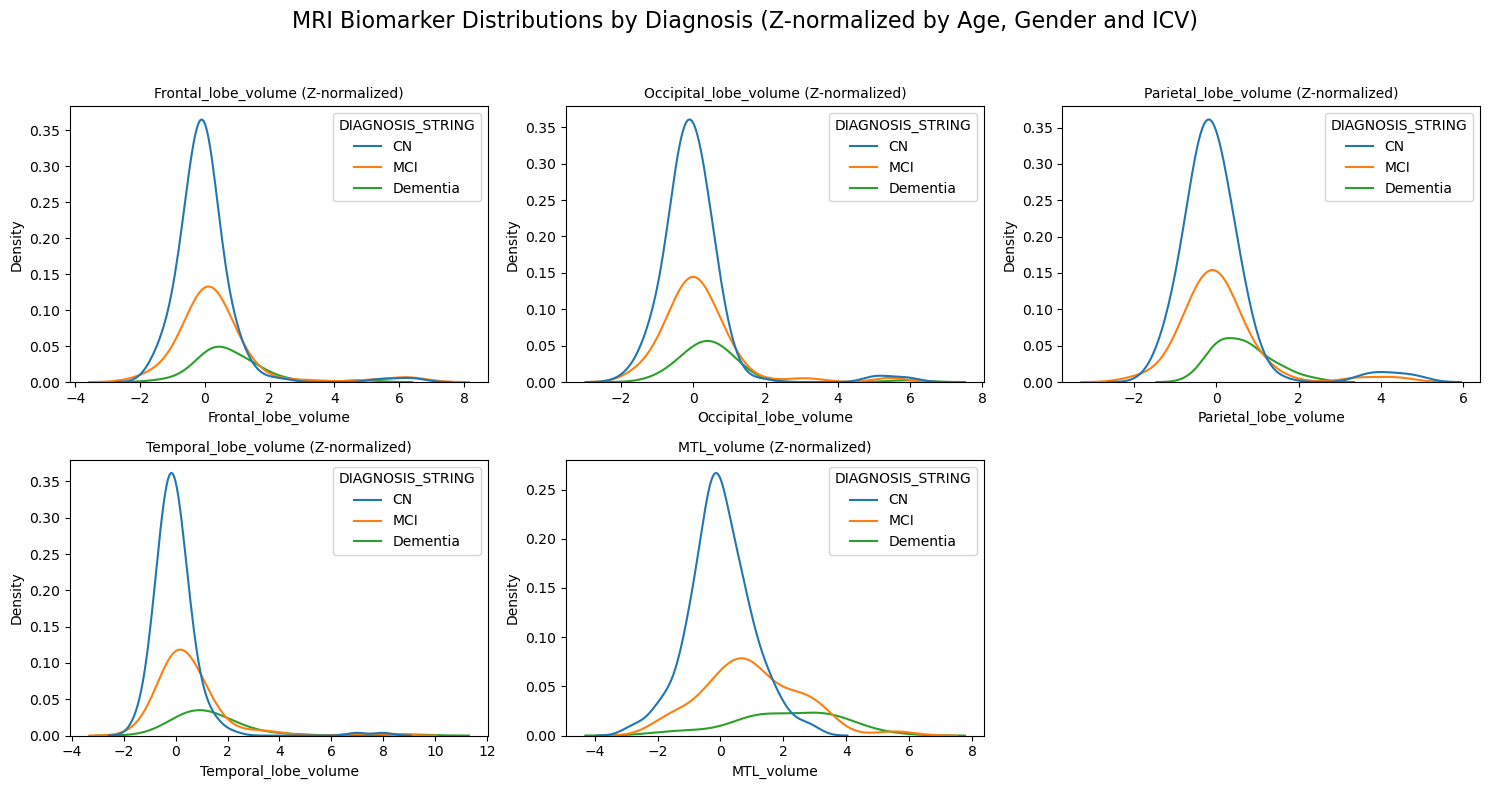

In [4]:
#Normalisation of the Multi MRI data 

# Make a copy of data_mri to store normalized values
zdata_multi_mri = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_mri: 
    model = smf.wls(f'{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'ICV_CorticalVolume', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_mri[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_mri)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_mri):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_mri, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("MRI Biomarker Distributions by Diagnosis (Z-normalized by Age, Gender and ICV)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



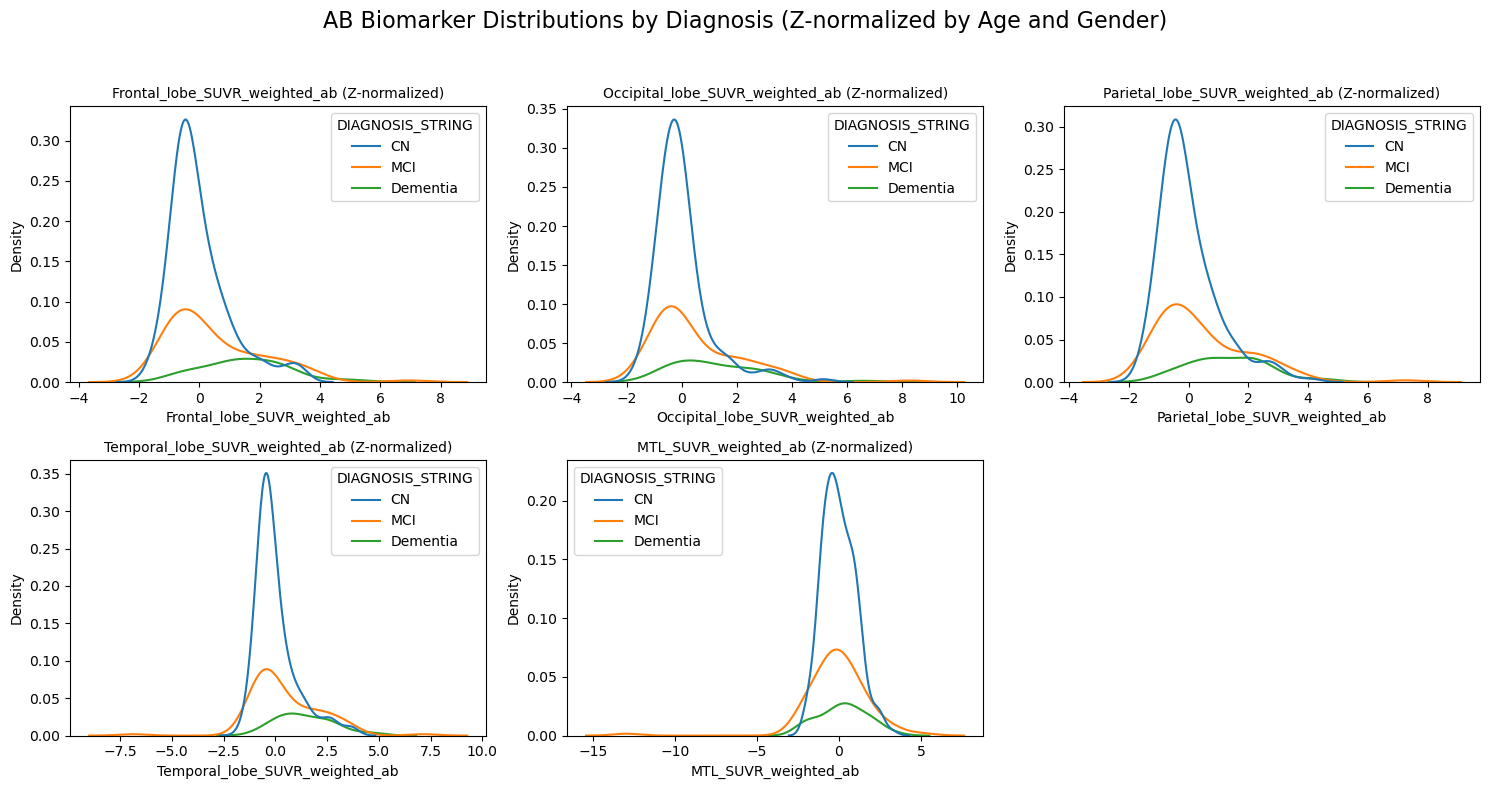

In [5]:
#Normalisation of the Multi AB data 

# Make a copy of data_mri to store normalized values
zdata_multi_ab = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_ab: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_ab[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_ab):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_ab, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("AB Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


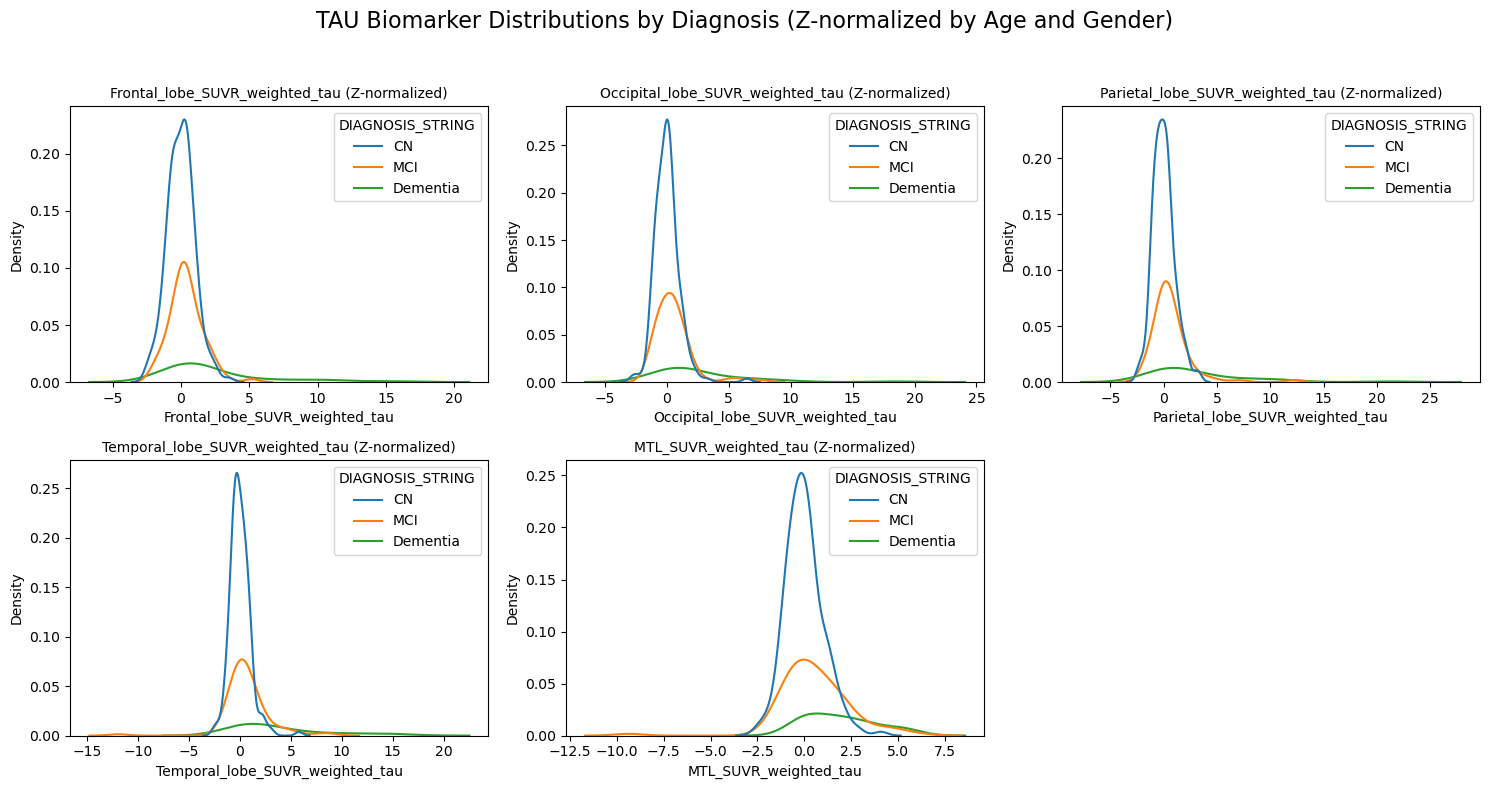

In [6]:
#Normalisation of the Multi TAU data 

# Make a copy of data_mri to store normalized values
zdata_multi_tau = pd.DataFrame(data_multi.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_tau: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_multi[data_multi['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_multi[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_multi[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_multi['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_multi['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_multi_tau[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_tau)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_tau):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_multi_tau, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("TAU Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


We load the data and run the same normalisations as before. Then we can load the data into the existing sustain models and assess subjects assignment over time. 

In [7]:
#Run the new data into the old models and assign subtype and stage per indivividual

N_samples = 1000 

def assign_sustain_subtypes(zdata_modality, biomarkers, sustain_model, samples_sequence, samples_f, modality_label, N_samples=1000):
    """Assign SuStaIn subtype/stage and return labels and full probability matrices."""
    zdata_array = zdata_modality[biomarkers].values

    ml_subtype, \
    prob_ml_subtype, \
    ml_stage, \
    prob_ml_stage, \
    prob_subtype, \
    prob_stage, \
    prob_subtype_stage = sustain_model.subtype_and_stage_individuals_newData(
        zdata_array, samples_sequence, samples_f, N_samples
    )

    # Flatten for DataFrame
    df_results = pd.DataFrame({
        f"{modality_label}_ml_subtype": np.ravel(ml_subtype),
        f"{modality_label}_ml_stage": np.ravel(ml_stage),
        f"{modality_label}_prob_ml_subtype": np.ravel(prob_ml_subtype),
        f"{modality_label}_prob_ml_stage": np.ravel(prob_ml_stage)
    }, index=zdata_modality.index)

    # Return all
    return df_results, prob_subtype, prob_stage, prob_subtype_stage


# Assign subtypes/stages for each modality
results_mri, prob_mri_subtype, prob_mri_stage, prob_mri_subtype_stage = assign_sustain_subtypes(zdata_multi_mri, biomarkers_mri, sustain_input_mri, samples_sequence_mri, samples_f_mri, "mri")
results_ab, prob_ab_subtype, prob_ab_stage, prob_ab_subtype_stage = assign_sustain_subtypes(zdata_multi_ab, biomarkers_ab, sustain_input_ab, samples_sequence_ab, samples_f_ab, "ab")
results_tau, prob_tau_subtype, prob_tau_stage, prob_tau_subtype_stage = assign_sustain_subtypes(zdata_multi_tau, biomarkers_tau, sustain_input_tau, samples_sequence_tau, samples_f_tau, "tau")

# Combine all SuStaIn assignments
results_combined = pd.concat([results_mri, results_ab, results_tau], axis=1)

# Merge with the full data_multi if needed
final_combined_df = pd.concat([data_multi, results_combined], axis=1)

final_combined_df["subtype_combo"] = ( "AB" +
    final_combined_df["ab_ml_subtype"].astype(str) + "_TAU" +
    final_combined_df["tau_ml_subtype"].astype(str) + "_MRI" +
    final_combined_df["mri_ml_subtype"].astype(str) 
)

def clean_and_increment_subtype_combo(combo_str):
    # Convert something like 'AB1.0_TAU2.0_MRI0.0' to 'AB2_TAU3_MRI1'
    parts = combo_str.split('_')
    cleaned_parts = []
    for part in parts:
        match = re.match(r'([A-Za-z]+)(\d+\.?\d*)', part)
        if match:
            label = match.group(1)
            number = int(float(match.group(2))) + 1  # force to int, then increment
            cleaned_parts.append(f"{label}{number}")
        else:
            cleaned_parts.append(part)  # fallback
    return '_'.join(cleaned_parts)
final_combined_df["subtype_combo"] = final_combined_df["subtype_combo"].apply(clean_and_increment_subtype_combo)



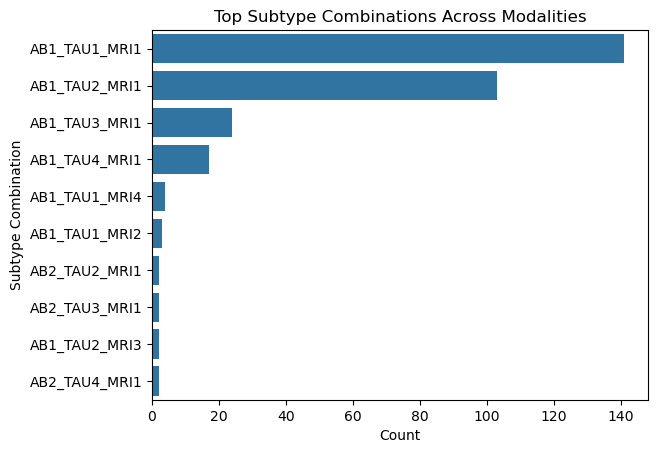

                 Count                          Proportion              \
DIAGNOSIS_STRING    CN Dementia MCI n_subjects          CN    Dementia   
subtype_combo                                                            
AB1_TAU1_MRI1       89       11  41        141   63.120567    7.801418   
AB1_TAU2_MRI1       70        6  27        103   67.961165    5.825243   
AB1_TAU3_MRI1        3       11  10         24   12.500000   45.833333   
AB1_TAU4_MRI1        8        3   6         17   47.058824   17.647059   
AB1_TAU1_MRI4        3        0   1          4   75.000000    0.000000   
AB1_TAU1_MRI2        2        0   1          3   66.666667    0.000000   
AB1_TAU1_MRI3        1        0   1          2   50.000000    0.000000   
AB1_TAU2_MRI3        1        0   1          2   50.000000    0.000000   
AB1_TAU2_MRI4        2        0   0          2  100.000000    0.000000   
AB2_TAU2_MRI1        1        0   1          2   50.000000    0.000000   
AB2_TAU3_MRI1        0        1   1   

In [8]:

#Count and visualise common subtype combinations
combo_counts = final_combined_df["subtype_combo"].value_counts()
#print(combo_counts.head(10))

top_combos = combo_counts.head(10).reset_index()
top_combos.columns = ["Subtype Combination", "Count"]
sns.barplot(x="Count", y="Subtype Combination", data=top_combos)
plt.title("Top Subtype Combinations Across Modalities")
plt.show()

#Association with Diagnosis
crosstab_counts = pd.crosstab(final_combined_df["subtype_combo"], final_combined_df[dx]) # Crosstab: raw counts
crosstab_props = pd.crosstab(final_combined_df["subtype_combo"], final_combined_df[dx], normalize='index') * 100 # Crosstab: row-normalized percentages
crosstab_counts["n_subjects"] = crosstab_counts.sum(axis=1) # Add total number of subjects per subtype_combo
# Sort by total number of subjects per subtype_combo
crosstab_counts_sorted = crosstab_counts.sort_values("n_subjects", ascending=False)

# Get corresponding rows for proportions
crosstab_props_sorted = crosstab_props.loc[crosstab_counts_sorted.index]

# Combine sorted tables
combined_table = pd.concat(
    [crosstab_counts_sorted, crosstab_props_sorted],
    axis=1,
    keys=["Count", "Proportion"]
)
print(combined_table)


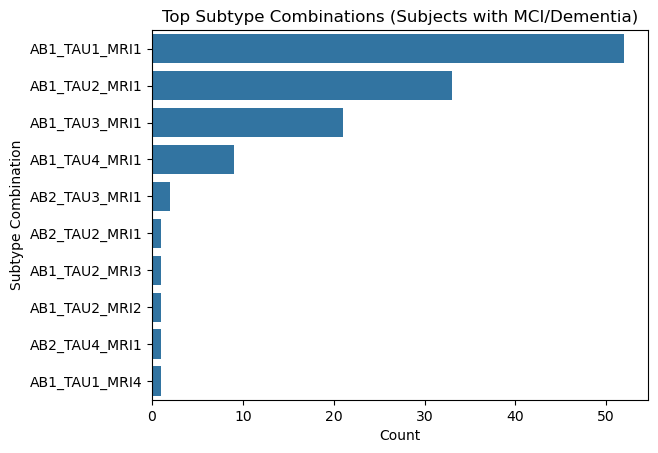

                    Count                 Proportion            
DIAGNOSIS_STRING Dementia MCI n_subjects    Dementia         MCI
subtype_combo                                                   
AB1_TAU1_MRI1          11  41         52   21.153846   78.846154
AB1_TAU2_MRI1           6  27         33   18.181818   81.818182
AB1_TAU3_MRI1          11  10         21   52.380952   47.619048
AB1_TAU4_MRI1           3   6          9   33.333333   66.666667
AB2_TAU3_MRI1           1   1          2   50.000000   50.000000
AB1_TAU1_MRI2           0   1          1    0.000000  100.000000
AB1_TAU1_MRI3           0   1          1    0.000000  100.000000
AB1_TAU1_MRI4           0   1          1    0.000000  100.000000
AB1_TAU2_MRI2           1   0          1  100.000000    0.000000
AB1_TAU2_MRI3           0   1          1    0.000000  100.000000
AB2_TAU2_MRI1           0   1          1    0.000000  100.000000
AB2_TAU4_MRI1           1   0          1  100.000000    0.000000


In [9]:
# modalities = ['mri', 'tau', 'ab']
# stage_cols = [f"{mod}_ml_stage" for mod in modalities]

# # Filter to keep only rows where all stages > 0 (i.e., exclude any with 0 stage in any modality)
# filtered_df = final_combined_df[
#     (final_combined_df[stage_cols] > 0).all(axis=1)
# ]

filtered_df = final_combined_df[final_combined_df[dx] != 'CN']


# Count subtype combos in filtered data
combo_counts = filtered_df["subtype_combo"].value_counts()

top_combos = combo_counts.head(10).reset_index()
top_combos.columns = ["Subtype Combination", "Count"]

# Plot barplot
sns.barplot(x="Count", y="Subtype Combination", data=top_combos)
plt.title("Top Subtype Combinations (Subjects with MCI/Dementia)")
plt.show()

# Crosstab counts and proportions on filtered_df
crosstab_counts = pd.crosstab(filtered_df["subtype_combo"], filtered_df[dx])  # raw counts
crosstab_props = pd.crosstab(filtered_df["subtype_combo"], filtered_df[dx], normalize='index') * 100  # row-wise %

crosstab_counts["n_subjects"] = crosstab_counts.sum(axis=1)
crosstab_counts_sorted = crosstab_counts.sort_values("n_subjects", ascending=False)
crosstab_props_sorted = crosstab_props.loc[crosstab_counts_sorted.index]

combined_table = pd.concat(
    [crosstab_counts_sorted, crosstab_props_sorted],
    axis=1,
    keys=["Count", "Proportion"]
)

print(combined_table)


In [10]:
# --- EFFECT SIZE FUNCTIONS ---

def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / dof)

def eta_squared(f_val, df_tuple):
    df1, df2 = df_tuple
    return f_val * df1 / (f_val * df1 + df2)

def epsilon_squared(H, N, k):
    return (H - k + 1) / (N - k)

# --- CRAMER'S V FOR CATEGORICAL ASSOCIATION ---

def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# --- POST-HOC MANN-WHITNEY WITH BONFERRONI ---

def pairwise_posthoc_mannwhitney(df, value_col, group_col, alpha=0.05):
    """Performs pairwise Mann-Whitney U test with Bonferroni correction."""
    results = []
    groups = df[group_col].unique()
    combinations = list(itertools.combinations(groups, 2))
    m = len(combinations)

    for g1, g2 in combinations:
        x = df[df[group_col] == g1][value_col]
        y = df[df[group_col] == g2][value_col]
        stat, p = mannwhitneyu(x, y)
        p_adj = min(p * m, 1.0)
        results.append({
            'Group 1': g1,
            'Group 2': g2,
            'p': p,
            'p_adj': p_adj,
            'significant': p_adj < alpha
        })

    return pd.DataFrame(results)




====== Multimodal Triplet Subtype Analysis (4 triplets) ======

 AGE (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 141, 'AB1_TAU2_MRI1': 103, 'AB1_TAU3_MRI1': 24, 'AB1_TAU4_MRI1': 17}
→ ANOVA p = 0.0490 | Eta² = 0.028

Tukey HSD post hoc results:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
AB1_TAU1_MRI1 AB1_TAU2_MRI1  -2.3209 0.0617 -4.7179 0.0761  False
AB1_TAU1_MRI1 AB1_TAU3_MRI1   0.2074 0.9992  -3.876 4.2909  False
AB1_TAU1_MRI1 AB1_TAU4_MRI1   0.9967 0.9485 -3.7512 5.7445  False
AB1_TAU2_MRI1 AB1_TAU3_MRI1   2.5283 0.4039 -1.6633 6.7199  False
AB1_TAU2_MRI1 AB1_TAU4_MRI1   3.3175 0.2895 -1.5236 8.1587  False
AB1_TAU3_MRI1 AB1_TAU4_MRI1   0.7892 0.9855  -5.073 6.6515  False
-----------------------------------------------------------------


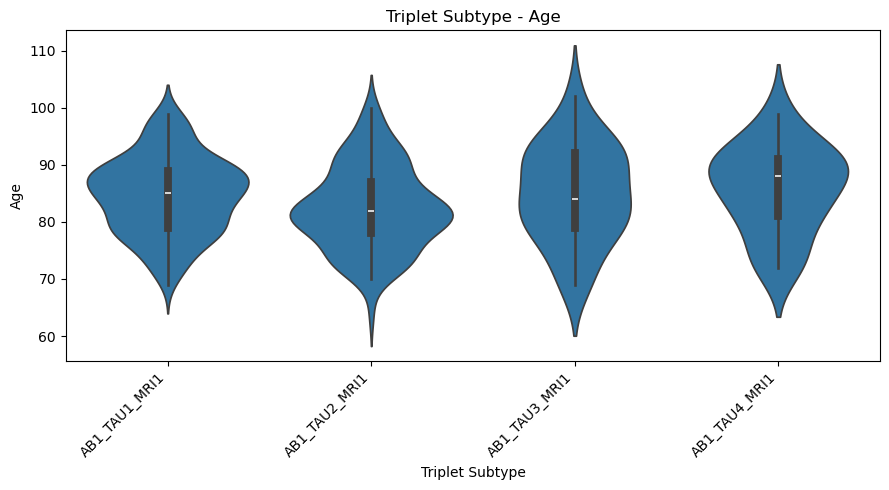


 MMSCORE (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 141, 'AB1_TAU2_MRI1': 102, 'AB1_TAU3_MRI1': 24, 'AB1_TAU4_MRI1': 17}
→ Kruskal-Wallis p = 0.0000 | Epsilon² = 0.106

Post hoc pairwise Mann-Whitney U test results (Bonferroni corrected):
         Group 1        Group 2             p         p_adj  significant
1  AB1_TAU1_MRI1  AB1_TAU3_MRI1  7.880452e-08  4.728271e-07         True
3  AB1_TAU2_MRI1  AB1_TAU3_MRI1  1.255844e-07  7.535062e-07         True
5  AB1_TAU3_MRI1  AB1_TAU4_MRI1  7.911620e-03  4.746972e-02         True


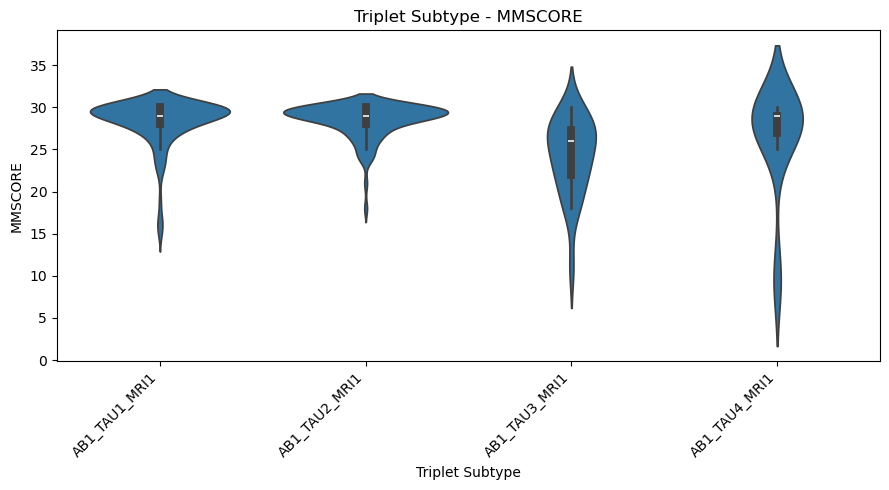


 PTEDUCAT (Continuous)
  Group sizes: {'AB1_TAU1_MRI1': 141, 'AB1_TAU2_MRI1': 103, 'AB1_TAU3_MRI1': 24, 'AB1_TAU4_MRI1': 17}
→ Kruskal-Wallis p = 0.1135 | Epsilon² = 0.011


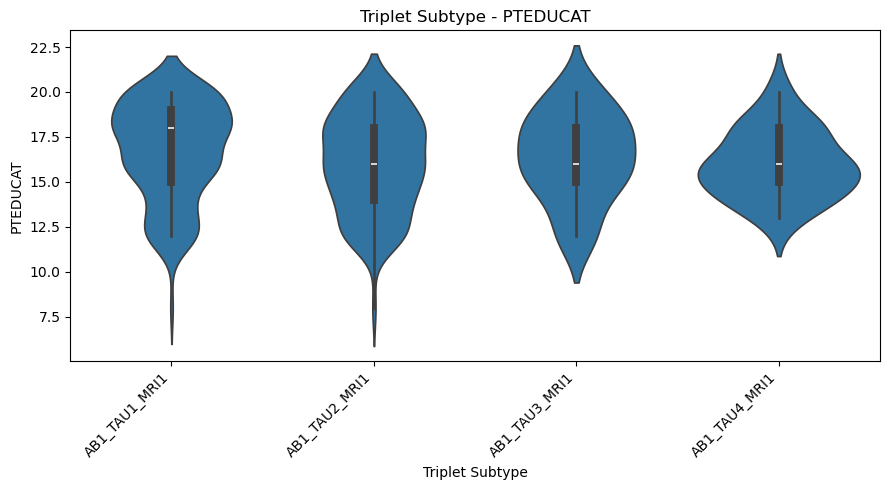


 DIAGNOSIS_STRING (Categorical)
→ Chi-squared p = 0.0000 | Cramér’s V = 0.278

Post hoc (adjusted residuals with Bonferroni correction):
         Subtype DIAGNOSIS_STRING             p     p_adj         direction
7  AB1_TAU3_MRI1         Dementia  2.075666e-07  0.000002   Overrepresented
6  AB1_TAU3_MRI1               CN  2.783115e-03  0.033397  Underrepresented


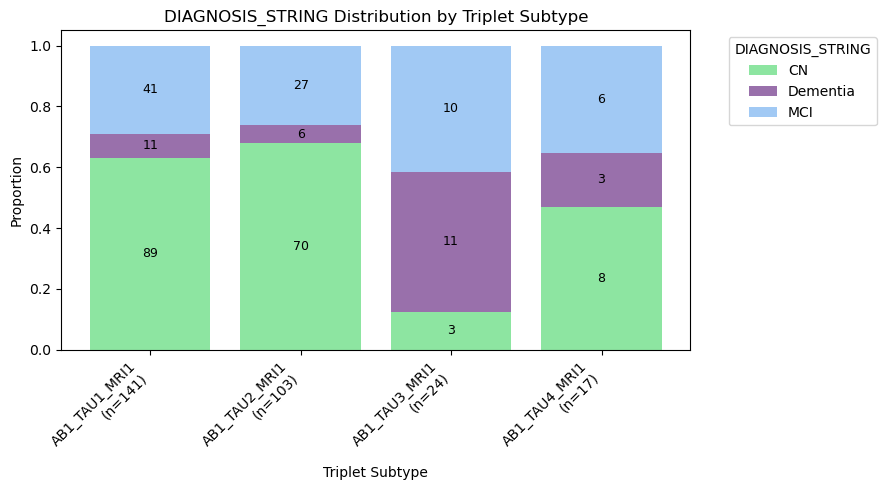


 PTGENDER (Categorical)
→ Chi-squared p = 0.5440 | Cramér’s V = 0.087


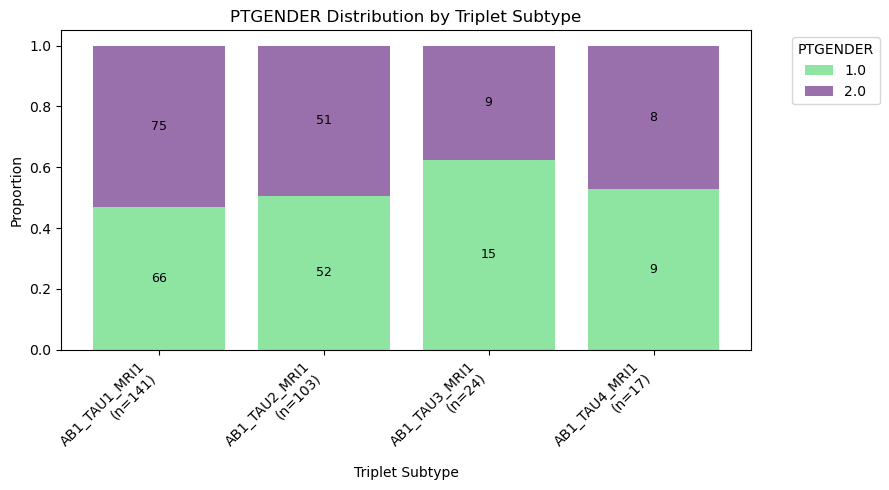


 APOE4 (Categorical)
→ Chi-squared p = 0.0496 | Cramér’s V = 0.149

Post hoc (adjusted residuals with Bonferroni correction):
No significant residuals after correction.


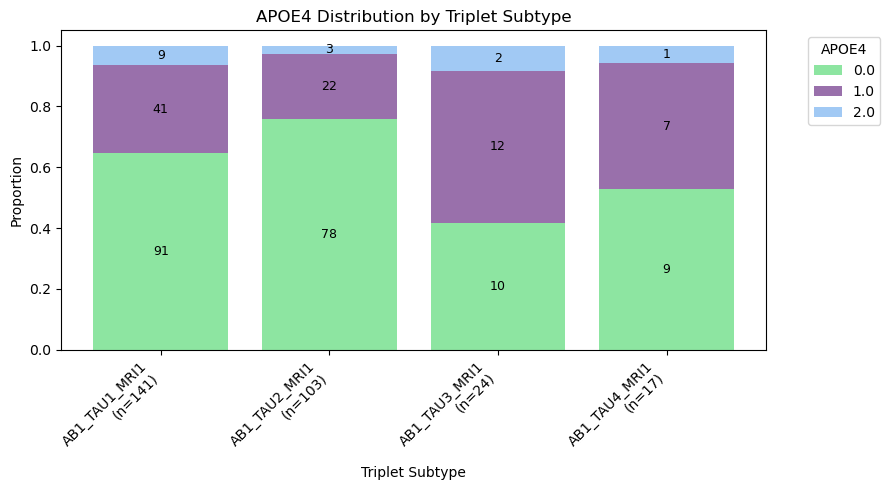

In [11]:
def triplet_subtype_analysis(df, combo_col, continuous_vars, categorical_vars, mmse_score, retire_age):
    colors = ['#8de5a1', '#9970AB', '#a1c9f4', '#ffb482', '#ff9f9b', '#d0bbff']

    # Filter triplets with >=10 subjects
    triplet_counts = df[combo_col].value_counts()
    valid_triplets = triplet_counts[triplet_counts >= 10].index.tolist()
    df = df[df[combo_col].isin(valid_triplets)]
    triplets = sorted(valid_triplets)
    k = len(triplets)

    if k < 2:
        print("Not enough valid triplets with ≥10 subjects. Aborting.")
        return

    print(f"\n\n====== Multimodal Triplet Subtype Analysis ({k} triplets) ======")

    # CONTINUOUS VARIABLES
    for var in continuous_vars:
        print(f"\n {var.upper()} (Continuous)")
        df_var = df.dropna(subset=[var, combo_col])

        if var == mmse_score:
            df_var = df_var[df_var[var] > 0]
        if var == retire_age:
            df_var = df_var[df_var[var] > 0]

        grouped = [df_var[df_var[combo_col] == s][var] for s in triplets]
        sizes = [len(g) for g in grouped]
        print(f"  Group sizes: {dict(zip(triplets, sizes))}")
        if any(n < 5 for n in sizes):
            print(" Small sample size detected in at least one group.")

        normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)

        if k == 2:
            x, y = grouped
            if normal:
                stat, p = ttest_ind(x, y, equal_var=False)
                d = cohen_d(x, y)
                print(f"→ Welch's t-test p = {p:.4f} | Cohen’s d = {d:.3f}")
            else:
                stat, p = mannwhitneyu(x, y)
                print(f"→ Mann-Whitney U test p = {p:.4f}")
        else:
            if normal:
                stat, p = f_oneway(*grouped)
                df1, df2 = k - 1, len(df_var) - k
                eta2 = eta_squared(stat, (df1, df2))
                print(f"→ ANOVA p = {p:.4f} | Eta² = {eta2:.3f}")
                if p < 0.05:
                    tukey_data = pd.concat([
                        pd.Series(g, name=var).to_frame().assign(subtype=s)
                        for g, s in zip(grouped, triplets)
                    ])
                    tukey = pairwise_tukeyhsd(tukey_data[var], tukey_data['subtype'])
                    print("\nTukey HSD post hoc results:")
                    print(tukey.summary())
            else:
                stat, p = kruskal(*grouped)
                eps2 = epsilon_squared(stat, len(df_var), k)
                print(f"→ Kruskal-Wallis p = {p:.4f} | Epsilon² = {eps2:.3f}")
                if p < 0.05:
                    posthoc_results = pairwise_posthoc_mannwhitney(df_var, var, combo_col)
                    sig_pairs = posthoc_results[posthoc_results['significant']]
                    print("\nPost hoc pairwise Mann-Whitney U test results (Bonferroni corrected):")
                    print(sig_pairs if not sig_pairs.empty else "No significant pairwise differences found.")

        # Plot
        plt.figure(figsize=(9, 5))
        sns.violinplot(x=combo_col, y=var, data=df_var)
        plt.title(f'Triplet Subtype - {var}')
        plt.xlabel("Triplet Subtype")
        plt.ylabel(var)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # CATEGORICAL VARIABLES
    for var in categorical_vars:
        print(f"\n {var.upper()} (Categorical)")
        if df[var].isnull().all():
            print(" Variable missing entirely.")
            continue

        table = pd.crosstab(df[combo_col], df[var])
        chi2, p, _, expected = chi2_contingency(table, correction=False)
        v = cramers_v(table)
        print(f"→ Chi-squared p = {p:.4f} | Cramér’s V = {v:.3f}")

        if p < 0.05:
            print("\nPost hoc (adjusted residuals with Bonferroni correction):")
            residuals = (table - expected) / np.sqrt(expected)
            flattened = residuals.stack().reset_index()
            flattened.columns = ['Subtype', var, 'z']
            flattened['p'] = 2 * (1 - norm.cdf(np.abs(flattened['z'])))
            flattened['p_adj'] = np.minimum(flattened['p'] * len(flattened), 1.0)
            sig = flattened[flattened['p_adj'] < 0.05].copy()

            if not sig.empty:
                sig['direction'] = np.where(sig['z'] > 0, 'Overrepresented', 'Underrepresented')
                sig = sig.sort_values('p_adj')
                print(sig[['Subtype', var, 'p', 'p_adj', 'direction']])
            else:
                print("No significant residuals after correction.")

        # Barplot
        prop_df = table.div(table.sum(1), axis=0)
        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

        fig, ax = plt.subplots(figsize=(9, 5))
        bottom = np.zeros(len(prop_df))

        for i, category in enumerate(prop_df.columns):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(
                x=np.arange(len(prop_df)),
                height=proportions,
                bottom=bottom,
                label=category,
                color=colors[i % len(colors)]
            )

            for j, bar in enumerate(bars):
                count = counts[j]
                if count > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + bar.get_height() / 2,
                        f'{int(count)}',
                        ha='center', va='center',
                        fontsize=9,
                        color='black'
                    )
            bottom += proportions

        ax.set_title(f'{var} Distribution by Triplet Subtype')
        ax.set_ylabel("Proportion")
        ax.set_xlabel("Triplet Subtype")
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels, rotation=45, ha='right')
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

triplet_subtype_analysis(
    final_combined_df,
    combo_col='subtype_combo',
    continuous_vars=continuous_vars,
    categorical_vars=categorical_vars,
    mmse_score=mmse_score,  # or your MMSE column name
    retire_age=retire_age  # or your retirement age column name
)




====== Multimodal Triplet Subtype Analysis (4 triplets) ======
Age: ANOVA p=0.0490, eta²=0.028
MMSCORE: KW p=0.0000, eps²=0.104
PTEDUCAT: KW p=0.1135, eps²=0.011
DIAGNOSIS_STRING: Chi² p=0.0000, Cramér's V=0.278
PTGENDER: Chi² p=0.5440, Cramér's V=0.087
APOE4: Chi² p=0.0496, Cramér's V=0.149


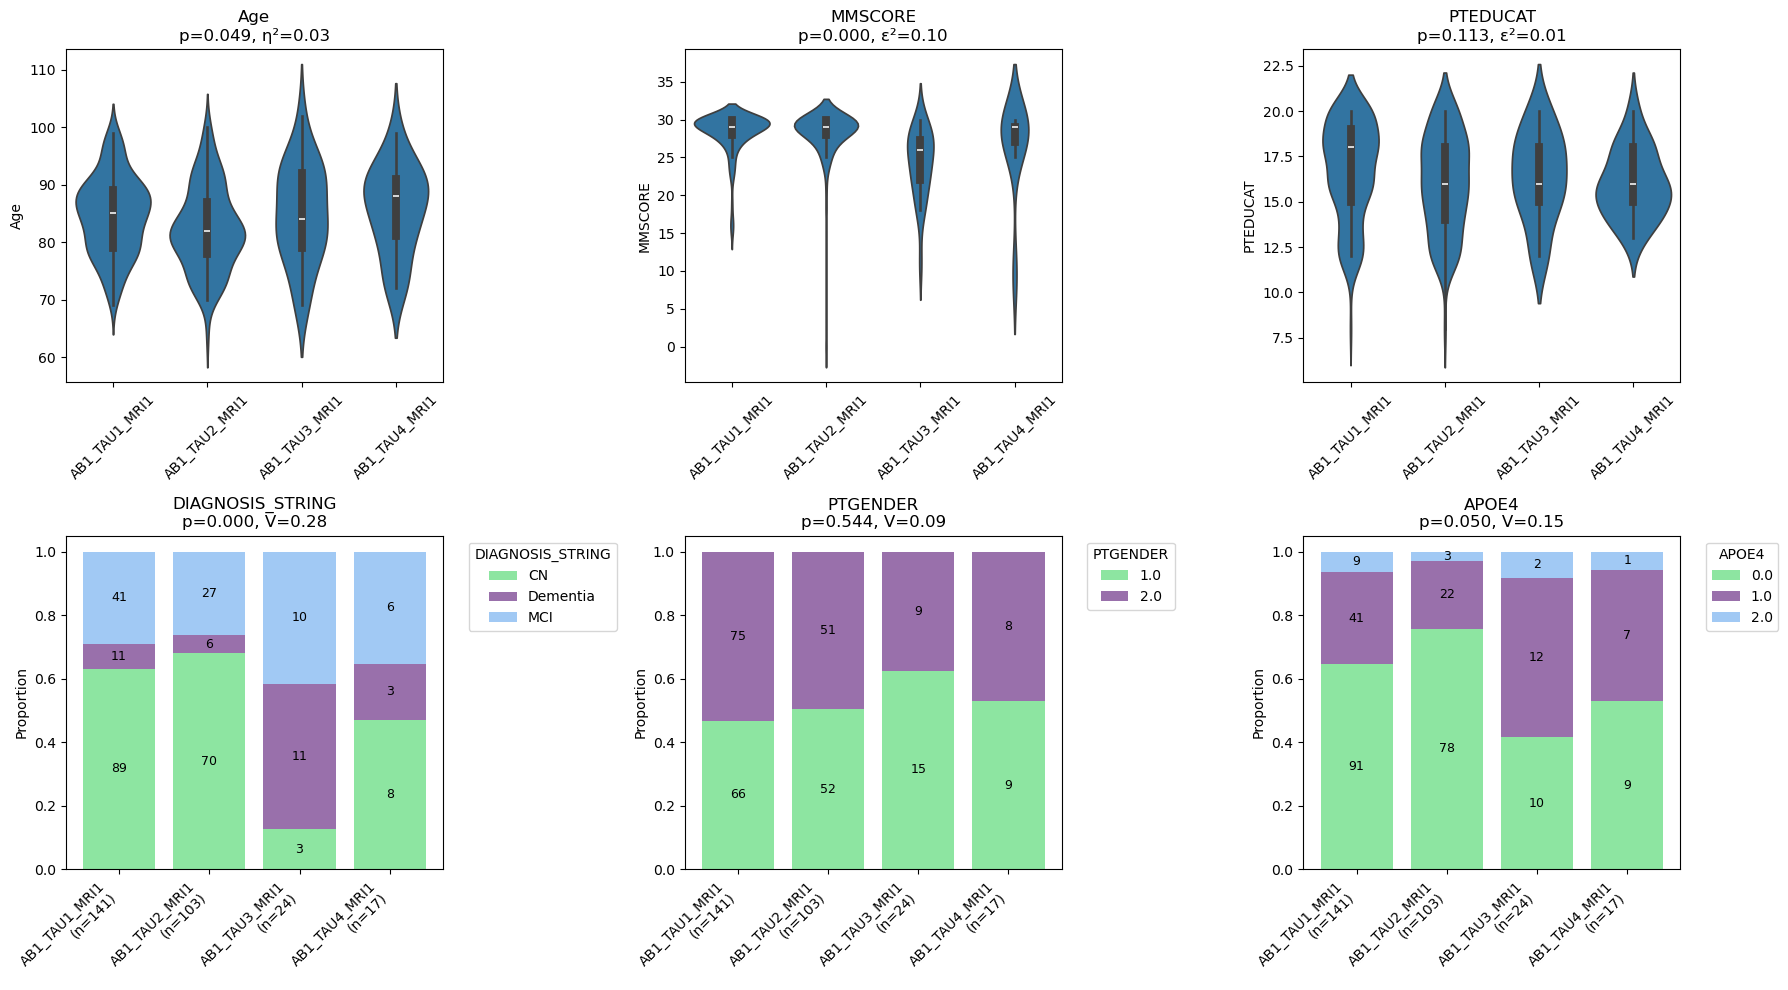

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# === effect sizes ===
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)

def eta_squared(F, df):
    return F * df[0] / (F * df[0] + df[1])

def epsilon_squared(H, n, k):
    return (H - k + 1) / (n - k)

def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

# === main function ===
def triplet_subtype_analysis(df, combo_col, continuous_vars, categorical_vars, mmse_score="MMSE"):
    colors = ['#8de5a1', '#9970AB', '#a1c9f4', '#ffb482', '#ff9f9b', '#d0bbff']

    # Filter triplets with ≥10 subjects
    triplet_counts = df[combo_col].value_counts()
    valid_triplets = triplet_counts[triplet_counts >= 10].index.tolist()
    df = df[df[combo_col].isin(valid_triplets)]
    triplets = sorted(valid_triplets)
    k = len(triplets)

    if k < 2:
        print("Not enough valid triplets with ≥10 subjects. Aborting.")
        return

    print(f"\n\n====== Multimodal Triplet Subtype Analysis ({k} triplets) ======")

    # === Create subplot grid ===
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 cols
    axes = axes.flatten()

    # === CONTINUOUS VARIABLES ===
    for i, var in enumerate(continuous_vars):
        ax = axes[i]
        df_var = df.dropna(subset=[var, combo_col])

        if var == mmse_score:
            df_var = df_var[df_var[var] > 0]

        grouped = [df_var[df_var[combo_col] == s][var] for s in triplets]

        title = var  # default title

        # Statistical tests
        if k == 2:
            x, y = grouped
            normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)
            if normal:
                stat, p = ttest_ind(x, y, equal_var=False)
                d = cohen_d(x, y)
                title = f"{var}\np={p:.3f}, d={d:.2f}"
                print(f"{var}: Welch t p={p:.4f}, d={d:.3f}")
            else:
                stat, p = mannwhitneyu(x, y)
                title = f"{var}\np={p:.3f} (MWU)"
                print(f"{var}: MWU p={p:.4f}")
        else:
            normal = all(shapiro(g)[1] > 0.05 for g in grouped if len(g) >= 3)
            if normal:
                stat, p = f_oneway(*grouped)
                df1, df2 = k - 1, len(df_var) - k
                eta2 = eta_squared(stat, (df1, df2))
                title = f"{var}\np={p:.3f}, η²={eta2:.2f}"
                print(f"{var}: ANOVA p={p:.4f}, eta²={eta2:.3f}")
            else:
                stat, p = kruskal(*grouped)
                eps2 = epsilon_squared(stat, len(df_var), k)
                title = f"{var}\np={p:.3f}, ε²={eps2:.2f}"
                print(f"{var}: KW p={p:.4f}, eps²={eps2:.3f}")

        # Plot
        sns.violinplot(x=combo_col, y=var, data=df_var, ax=ax)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)

    # === CATEGORICAL VARIABLES ===
    for j, var in enumerate(categorical_vars):
        ax = axes[3 + j]
        if df[var].isnull().all():
            continue

        table = pd.crosstab(df[combo_col], df[var])
        prop_df = table.div(table.sum(1), axis=0)

        # stats
        chi2, p, dof, exp = chi2_contingency(table, correction=False)
        cv = cramers_v(table)
        title = f"{var}\np={p:.3f}, V={cv:.2f}"
        print(f"{var}: Chi² p={p:.4f}, Cramér's V={cv:.3f}")

        subtype_counts = table.sum(axis=1)
        new_labels = [f"{s}\n(n={n})" for s, n in subtype_counts.items()]

        bottom = np.zeros(len(prop_df))
        for i, category in enumerate(prop_df.columns):
            proportions = prop_df[category].values
            counts = table[category].values
            bars = ax.bar(
                x=np.arange(len(prop_df)),
                height=proportions,
                bottom=bottom,
                label=category,
                color=colors[i % len(colors)]
            )
            for k, bar in enumerate(bars):
                count = counts[k]
                if count > 0:
                    ax.text(bar.get_x() + bar.get_width() / 2,
                            bar.get_y() + bar.get_height() / 2,
                            f'{int(count)}', ha='center', va='center', fontsize=9)
            bottom += proportions

        ax.set_title(title, fontsize=12)
        ax.set_ylabel("Proportion")
        ax.set_xticks(range(len(new_labels)))
        ax.set_xticklabels(new_labels, rotation=45, ha='right')
        ax.legend(title=var, bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.savefig("triplet_subtype_analysis_subplot.png", dpi=300)
    plt.show()



triplet_subtype_analysis(
    final_combined_df,       # your main dataframe
    "subtype_combo",         # triplet column
    continuous_vars,
    categorical_vars
)


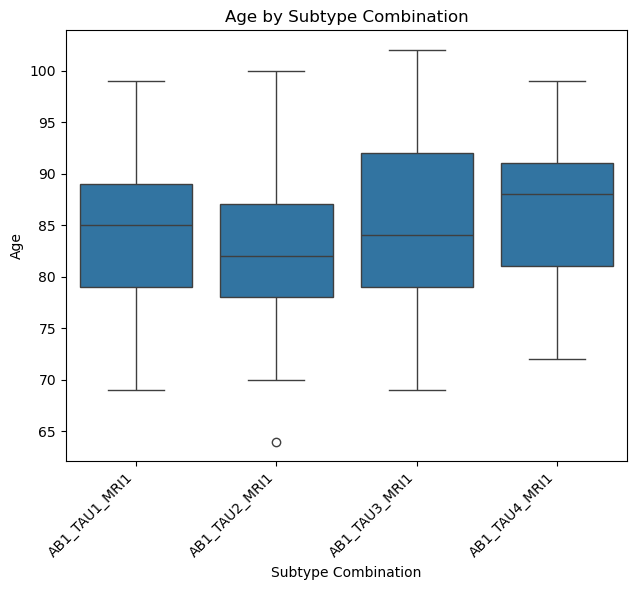


Subtype Combo Age Summary:
                  n   mean   std  median  min  max
subtype_combo                                    
AB1_TAU1_MRI1  141  84.71  6.77    85.0   69   99
AB1_TAU2_MRI1  103  82.39  7.28    82.0   64  100
AB1_TAU3_MRI1   24  84.92  8.44    84.0   69  102
AB1_TAU4_MRI1   17  85.71  7.60    88.0   72   99


In [13]:
# Define custom summary stats function if not already done
def stats(df, group_col, value_col):
    return (
        df.groupby(group_col)[value_col]
        .agg(['count', 'mean', 'std', 'median', 'min', 'max'])
        .rename(columns={'count': 'n'})
        .round(2)
    )

# Clean age > 0
multi_clean = final_combined_df[final_combined_df[age] > 0].copy()

# Keep only subtype combinations with >9 subjects
combo_counts = multi_clean['subtype_combo'].value_counts()
valid_combos = combo_counts[combo_counts > 9].index.tolist()
multi_clean = multi_clean[multi_clean['subtype_combo'].isin(valid_combos)]

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(data=multi_clean, x='subtype_combo', y=age)
plt.title('Age by Subtype Combination')
plt.xlabel('Subtype Combination')
plt.ylabel('Age')
plt.xticks(rotation=45, ha='right')  # angled labels for readability

plt.tight_layout()
plt.show()

# Summary stats
age_multi_summary = stats(multi_clean, 'subtype_combo', age)
print("\nSubtype Combo Age Summary:\n", age_multi_summary)


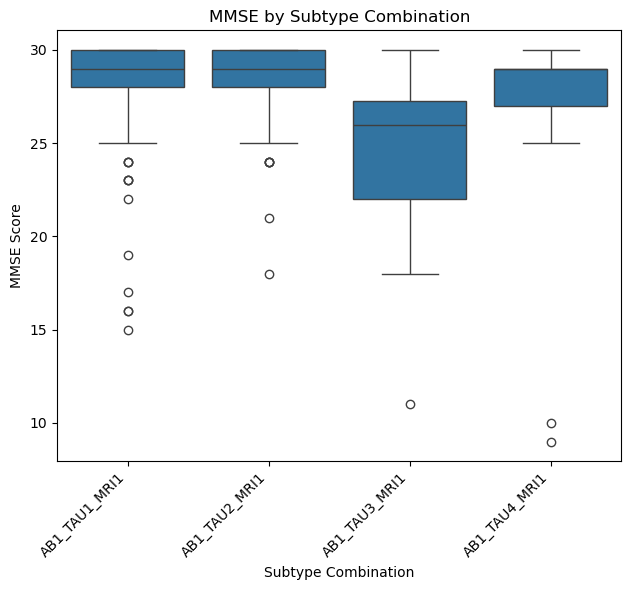


Subtype Combo MMSE Summary:
                  n   mean   std  median   min   max
subtype_combo                                      
AB1_TAU1_MRI1  141  28.27  2.85    29.0  15.0  30.0
AB1_TAU2_MRI1  102  28.44  2.05    29.0  18.0  30.0
AB1_TAU3_MRI1   24  24.12  4.54    26.0  11.0  30.0
AB1_TAU4_MRI1   17  26.29  6.47    29.0   9.0  30.0


In [14]:
# Clean MMSE > 0
multi_clean = final_combined_df[final_combined_df[mmse_score] > 0].copy()

# Keep only subtype combinations with >9 subjects
combo_counts = multi_clean['subtype_combo'].value_counts()
valid_combos = combo_counts[combo_counts > 9].index.tolist()
multi_clean = multi_clean[multi_clean['subtype_combo'].isin(valid_combos)]

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(data=multi_clean, x='subtype_combo', y=mmse_score)
plt.title('MMSE by Subtype Combination')
plt.xlabel('Subtype Combination')
plt.ylabel('MMSE Score')
plt.xticks(rotation=45, ha='right')  # angled labels for readability

plt.tight_layout()
plt.show()

# Summary stats
mmse_multi_summary = stats(multi_clean, 'subtype_combo', mmse_score)
print("\nSubtype Combo MMSE Summary:\n", mmse_multi_summary)


AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=0.000, r=0.11, p=0.7247
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.003, r=-0.39, p=0.2365
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.43, p=0.2189
AB | Frontal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.20, p=0.6290


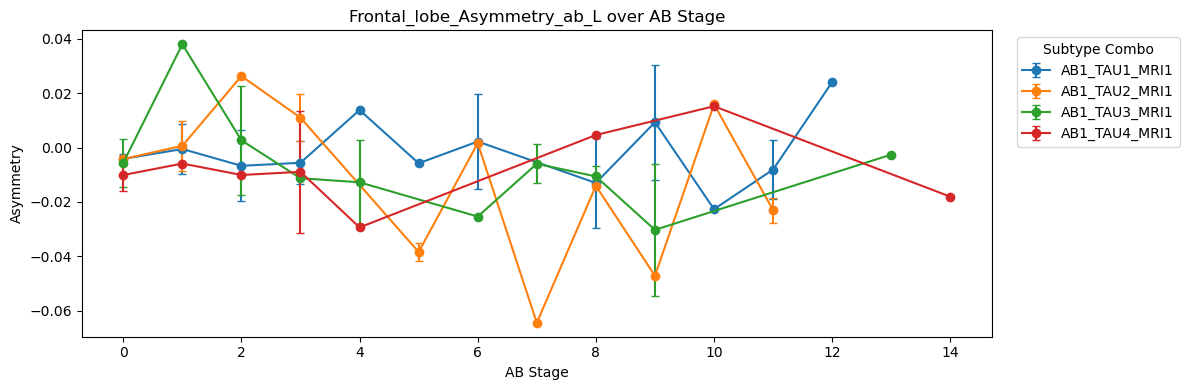

AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=-0.000, r=-0.11, p=0.7247
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.003, r=0.39, p=0.2365
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.43, p=0.2189
AB | Frontal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.20, p=0.6290


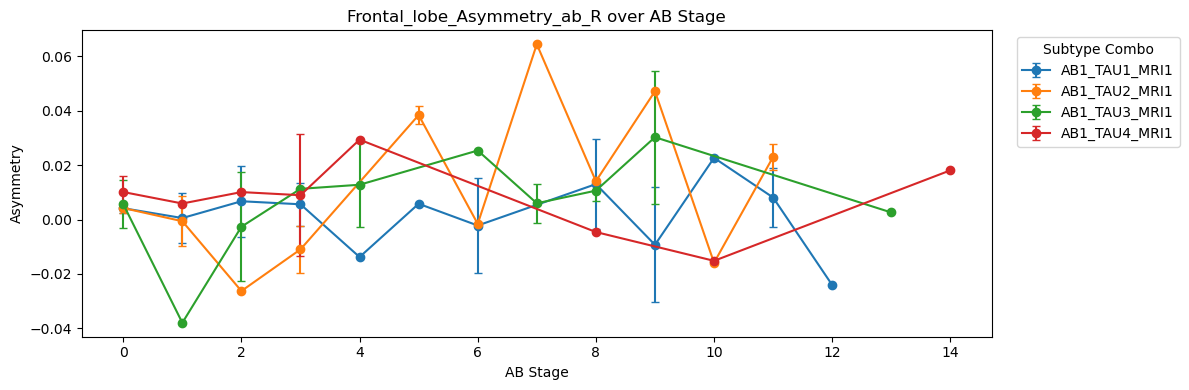

AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=0.002, r=0.17, p=0.6030
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.009, r=-0.68, p=0.0220
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.33, p=0.3482
AB | Occipital_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.24, p=0.5659


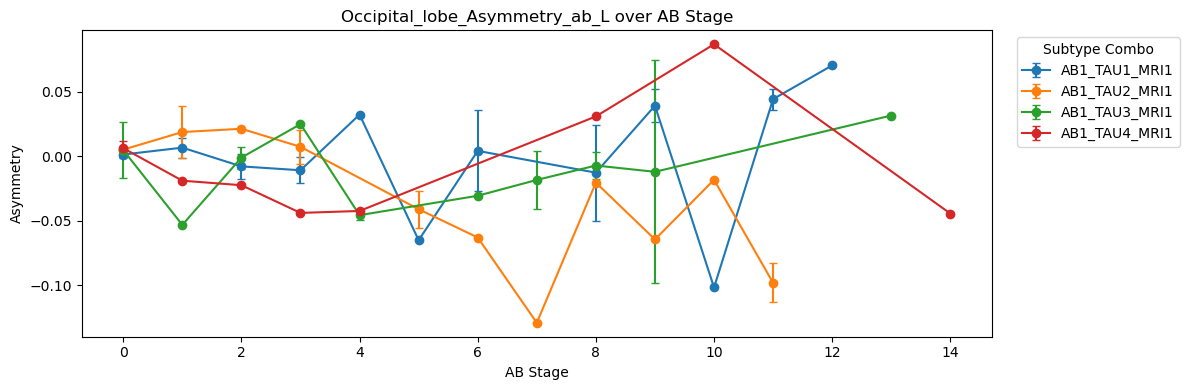

AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=-0.002, r=-0.17, p=0.6030
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.009, r=0.68, p=0.0220
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.33, p=0.3482
AB | Occipital_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.24, p=0.5659


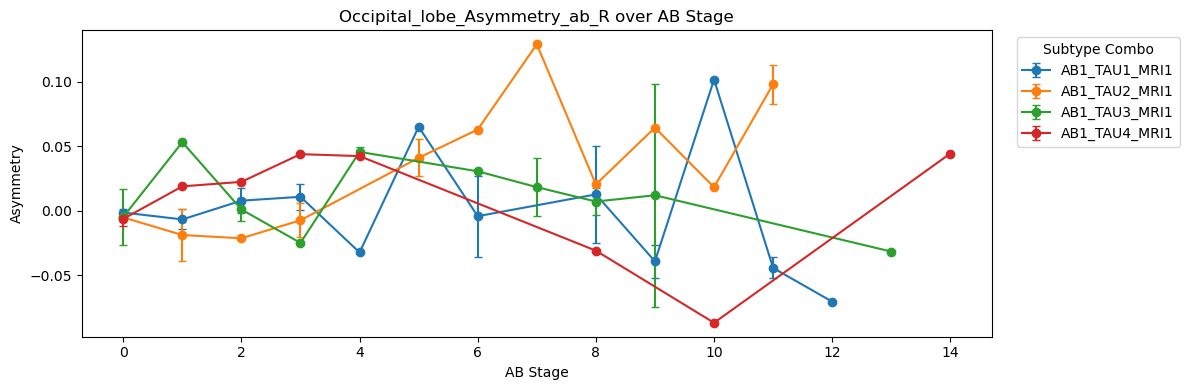

AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.11, p=0.7345
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.005, r=-0.43, p=0.1894
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.31, p=0.3874
AB | Parietal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.29, p=0.4906


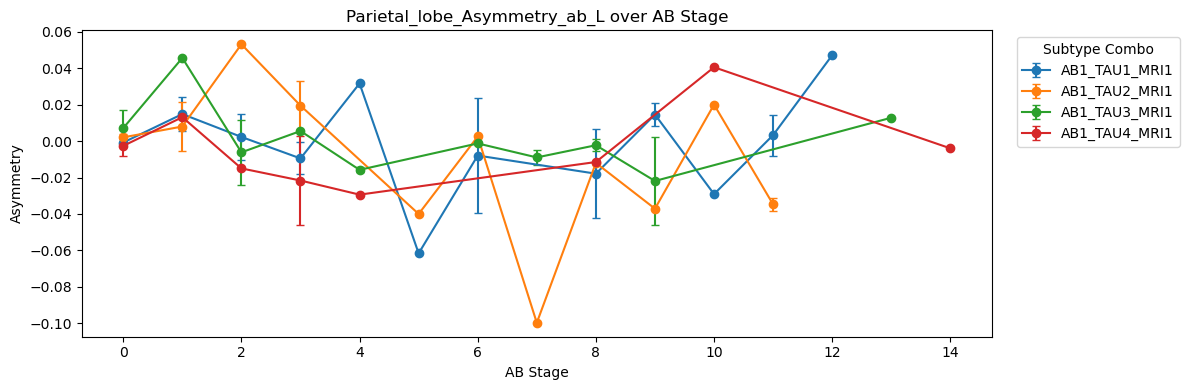

AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.11, p=0.7345
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.005, r=0.43, p=0.1894
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.31, p=0.3874
AB | Parietal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.29, p=0.4906


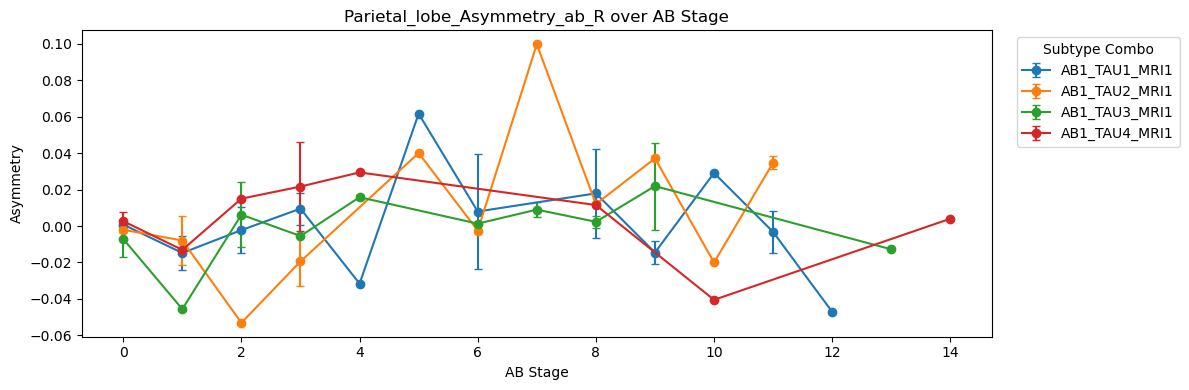

AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=0.001, r=0.17, p=0.5902
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.006, r=-0.44, p=0.1752
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.09, p=0.7973
AB | Temporal_lobe_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.23, p=0.5913


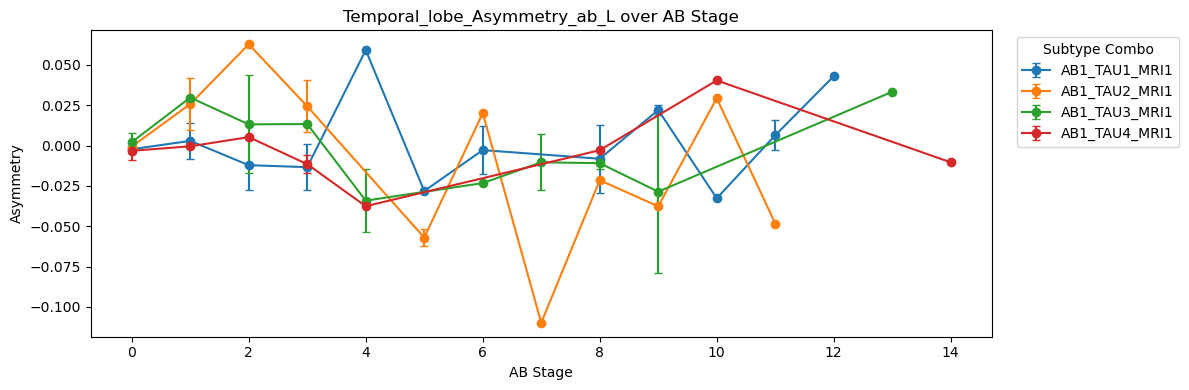

AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=-0.001, r=-0.17, p=0.5902
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.006, r=0.44, p=0.1752
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.09, p=0.7973
AB | Temporal_lobe_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.23, p=0.5913


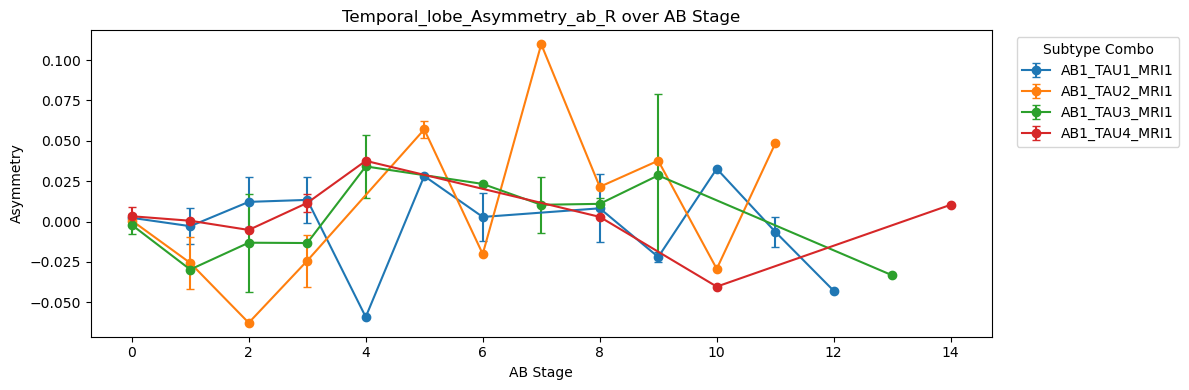

AB | MTL_Asymmetry_ab_L | Combo AB1_TAU1_MRI1 | Slope=-0.000, r=-0.08, p=0.8026
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU2_MRI1 | Slope=-0.004, r=-0.43, p=0.1915
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.67, p=0.0331
AB | MTL_Asymmetry_ab_L | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.56, p=0.1465


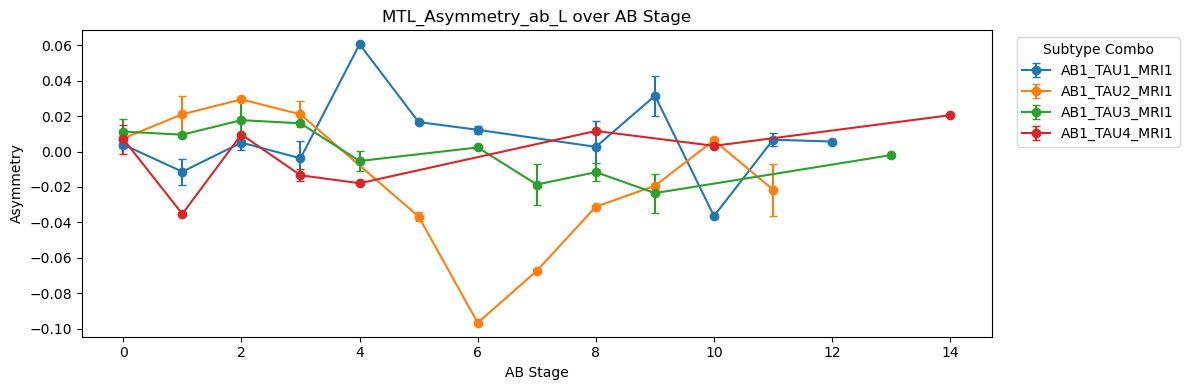

AB | MTL_Asymmetry_ab_R | Combo AB1_TAU1_MRI1 | Slope=0.000, r=0.08, p=0.8026
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU2_MRI1 | Slope=0.004, r=0.43, p=0.1915
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.67, p=0.0331
AB | MTL_Asymmetry_ab_R | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.56, p=0.1465


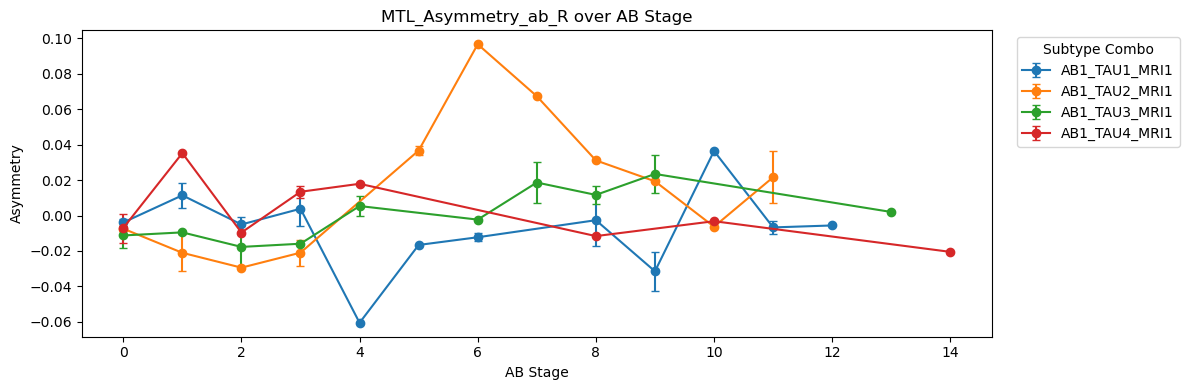

TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.009, r=0.65, p=0.1615
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.004, r=-0.74, p=0.4716
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.003, r=-0.55, p=0.0998
TAU | Frontal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.001, r=-0.06, p=0.9186


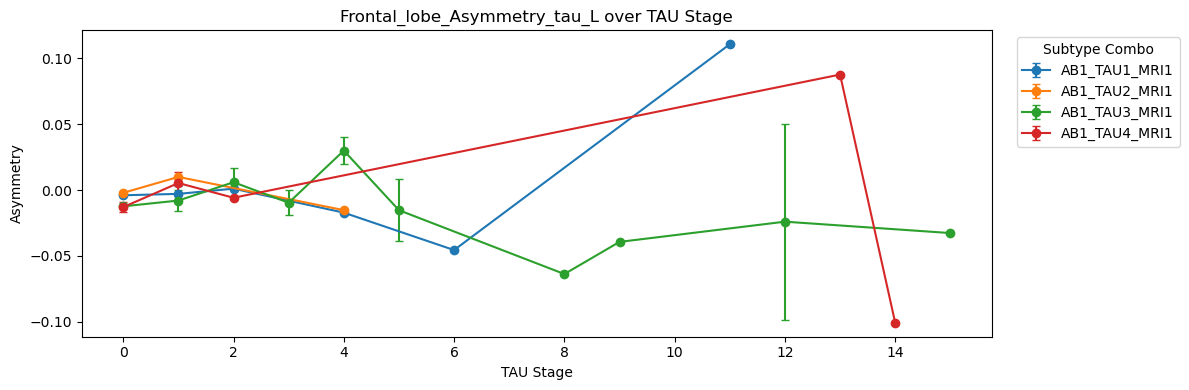

TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.009, r=-0.65, p=0.1615
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.004, r=0.74, p=0.4716
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.003, r=0.55, p=0.0998
TAU | Frontal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.001, r=0.06, p=0.9186


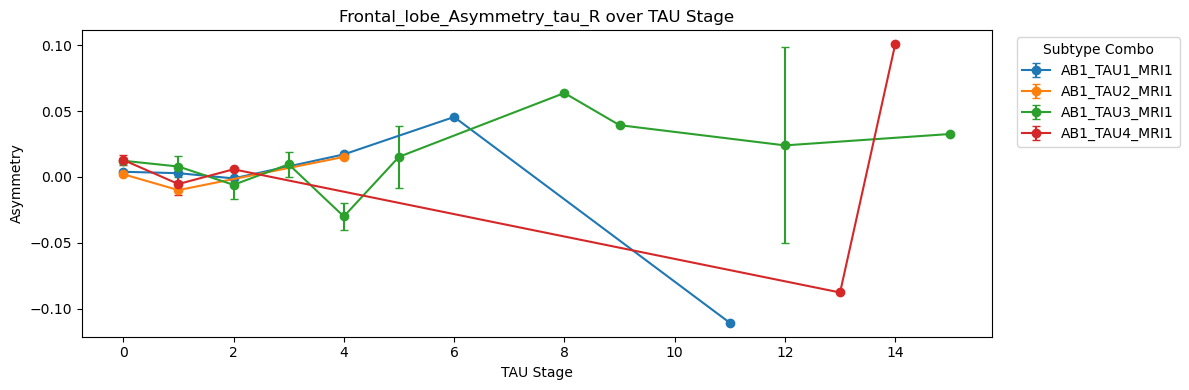

TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.022, r=0.78, p=0.0701
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.048, r=-0.99, p=0.1010
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.09, p=0.8058
TAU | Occipital_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.006, r=-0.44, p=0.4575


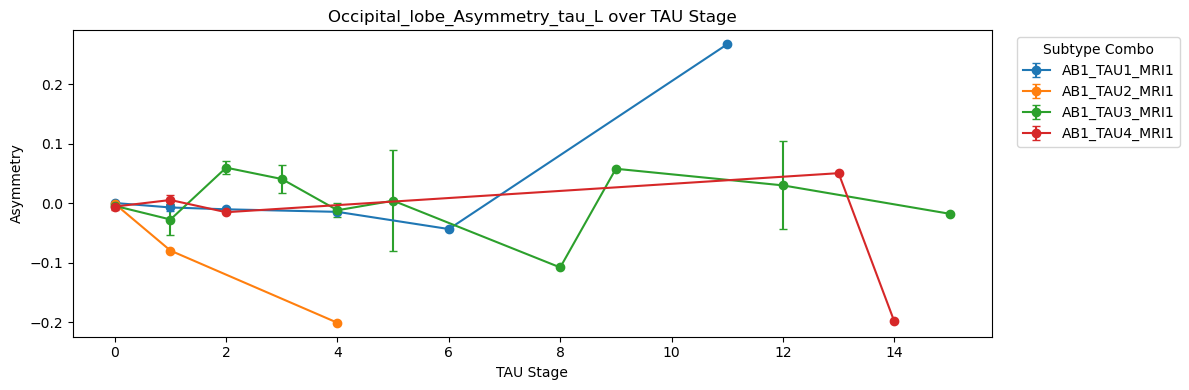

TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.022, r=-0.78, p=0.0701
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.048, r=0.99, p=0.1010
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.09, p=0.8058
TAU | Occipital_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.006, r=0.44, p=0.4575


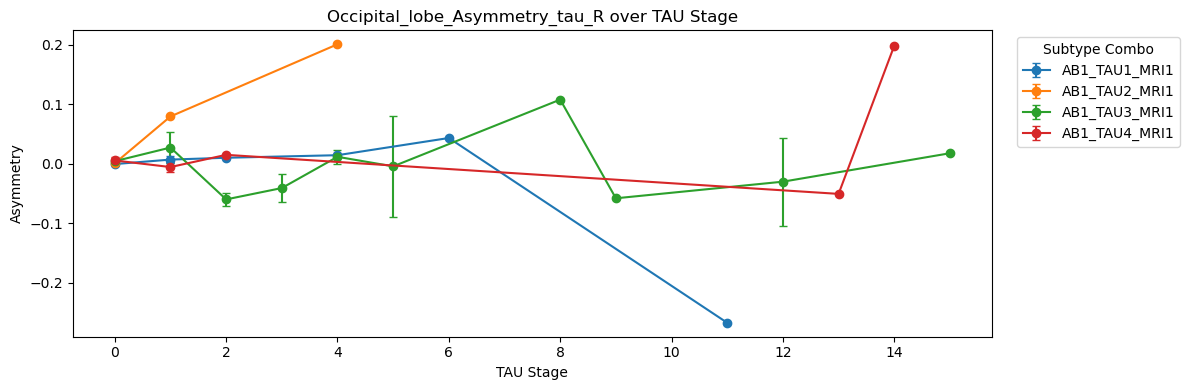

TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.012, r=0.53, p=0.2820
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.021, r=-0.95, p=0.2105
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.001, r=-0.16, p=0.6519
TAU | Parietal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.22, p=0.7218


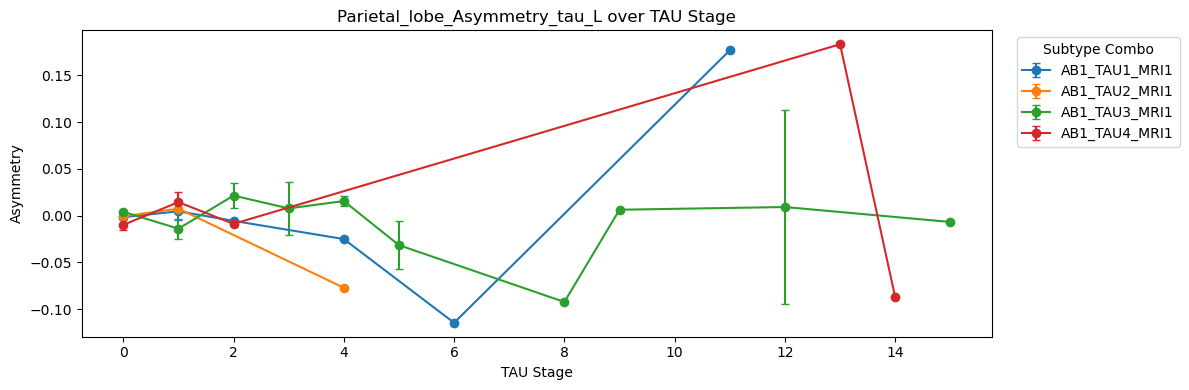

TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.012, r=-0.53, p=0.2820
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.021, r=0.95, p=0.2105
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.001, r=0.16, p=0.6519
TAU | Parietal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.22, p=0.7218


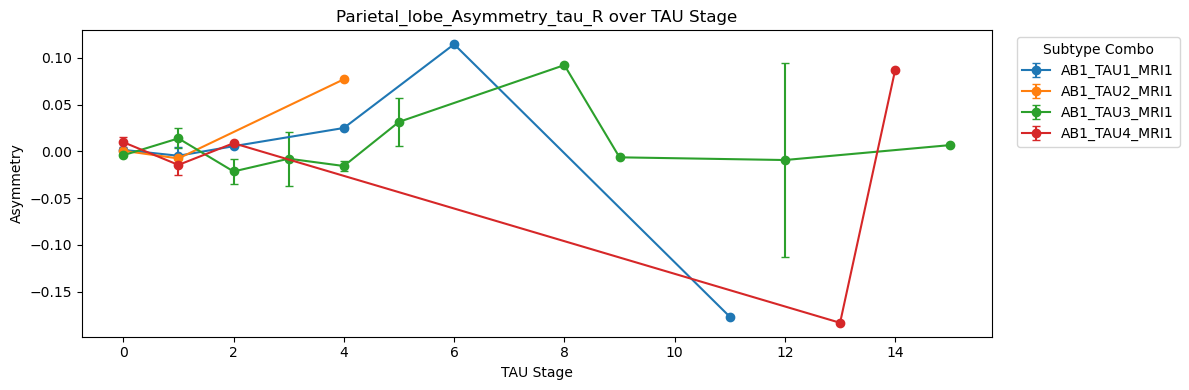

TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=0.008, r=0.35, p=0.4904
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.030, r=-0.90, p=0.2917
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=-0.004, r=-0.40, p=0.2541
TAU | Temporal_lobe_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.33, p=0.5878


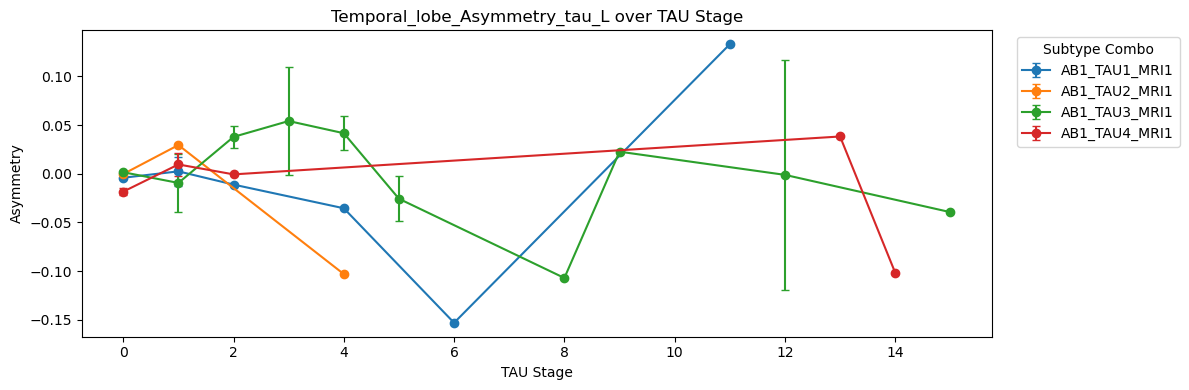

TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=-0.008, r=-0.35, p=0.4904
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.030, r=0.90, p=0.2917
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=0.004, r=0.40, p=0.2541
TAU | Temporal_lobe_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.33, p=0.5878


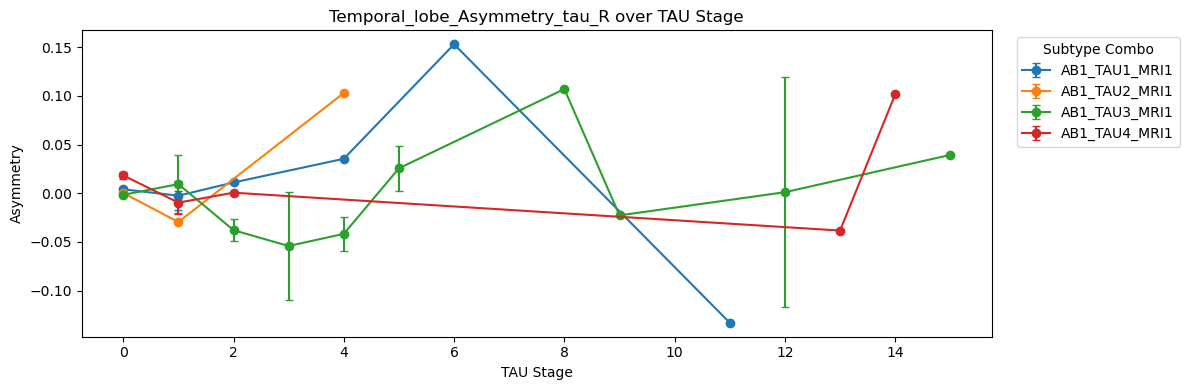

TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU1_MRI1 | Slope=-0.002, r=-0.66, p=0.1525
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU2_MRI1 | Slope=-0.015, r=-0.81, p=0.3989
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.10, p=0.7850
TAU | MTL_Asymmetry_tau_L | Combo AB1_TAU4_MRI1 | Slope=-0.003, r=-0.89, p=0.0446


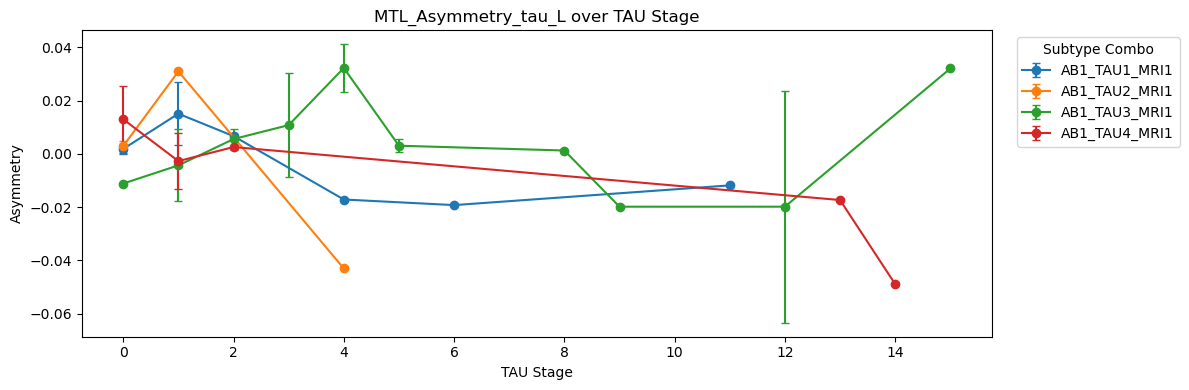

TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU1_MRI1 | Slope=0.002, r=0.66, p=0.1525
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU2_MRI1 | Slope=0.015, r=0.81, p=0.3989
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.10, p=0.7850
TAU | MTL_Asymmetry_tau_R | Combo AB1_TAU4_MRI1 | Slope=0.003, r=0.89, p=0.0446


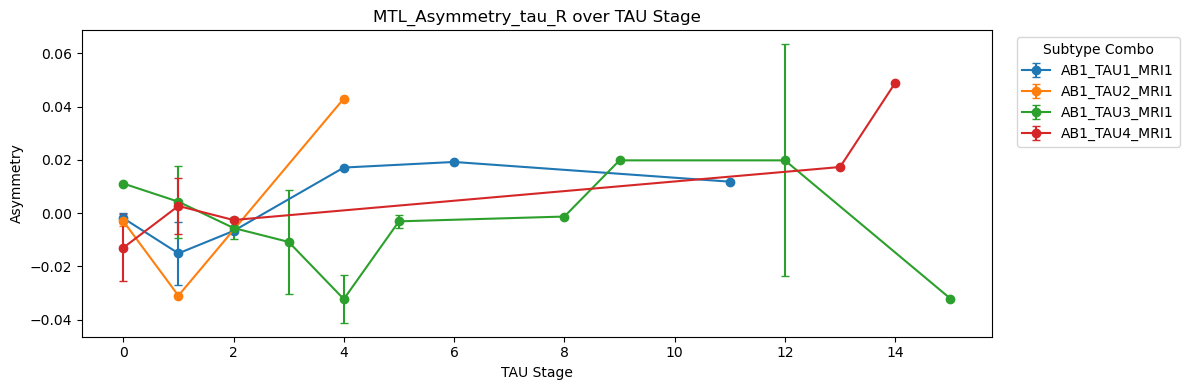

MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.002, r=-0.40, p=0.5092
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.001, r=0.20, p=0.7062
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.19, p=0.7601
MRI | Frontal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.002, r=-0.53, p=0.4726


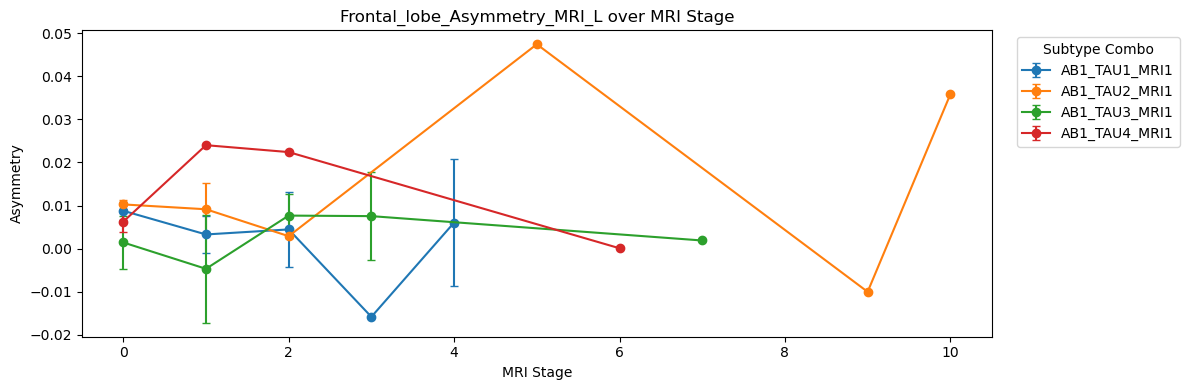

MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.002, r=0.40, p=0.5092
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.001, r=-0.20, p=0.7062
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.19, p=0.7601
MRI | Frontal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.002, r=0.53, p=0.4726


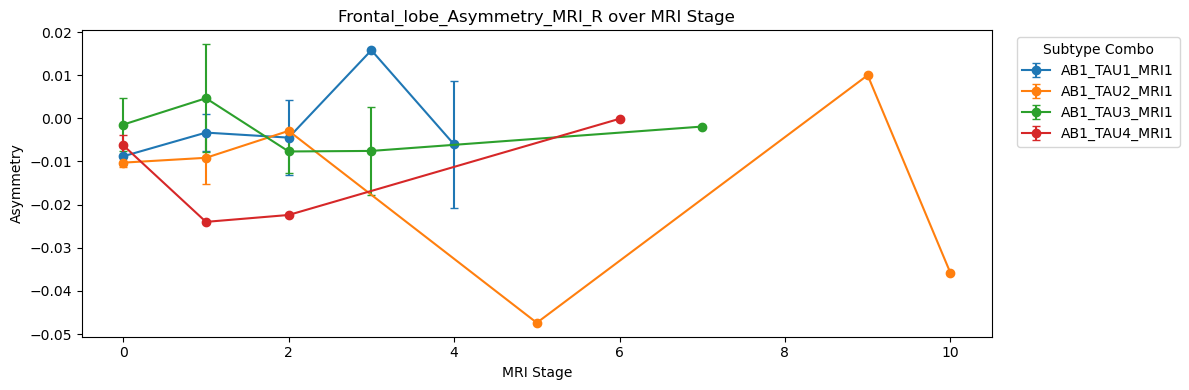

MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.015, r=-0.89, p=0.0412
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=-0.001, r=-0.13, p=0.8080
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=-0.000, r=-0.02, p=0.9738
MRI | Occipital_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.016, r=-0.72, p=0.2776


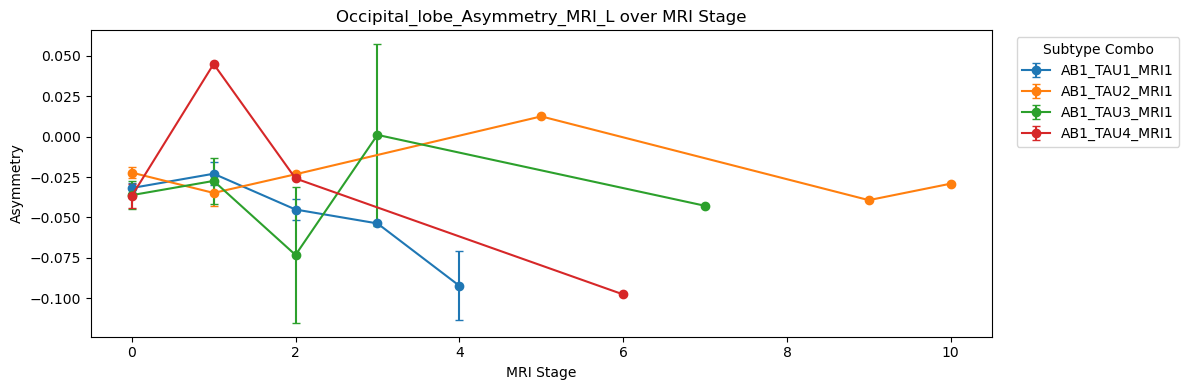

MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.015, r=0.89, p=0.0412
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=0.001, r=0.13, p=0.8080
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=0.000, r=0.02, p=0.9738
MRI | Occipital_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.016, r=0.72, p=0.2776


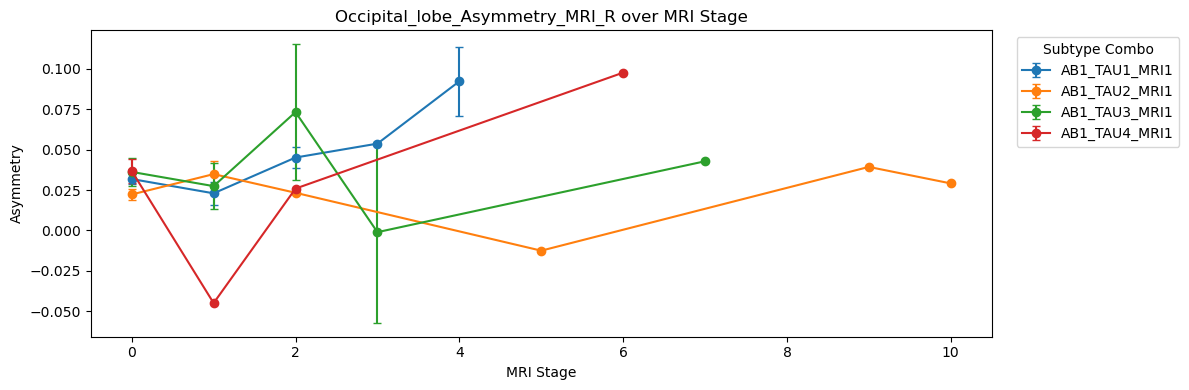

MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.006, r=-0.83, p=0.0817
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.001, r=0.14, p=0.7979
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.73, p=0.1643
MRI | Parietal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.006, r=-0.61, p=0.3934


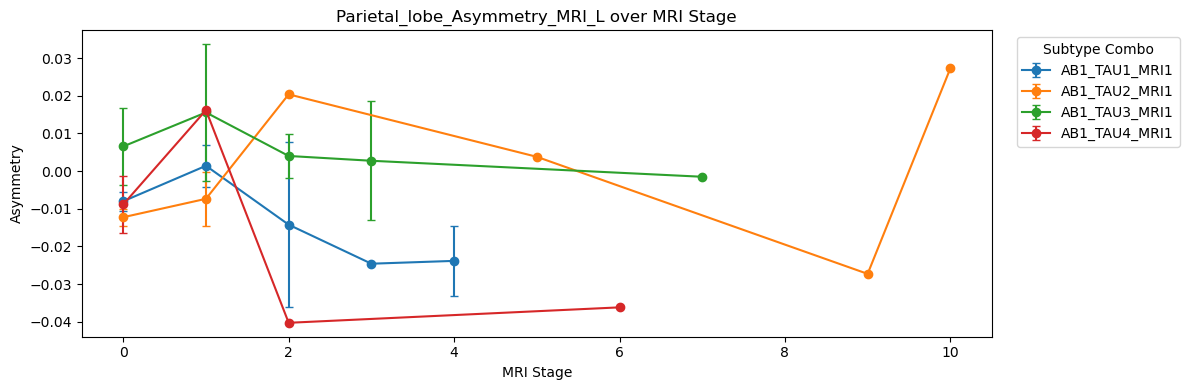

MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.006, r=0.83, p=0.0817
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.001, r=-0.14, p=0.7979
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.73, p=0.1643
MRI | Parietal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.006, r=0.61, p=0.3934


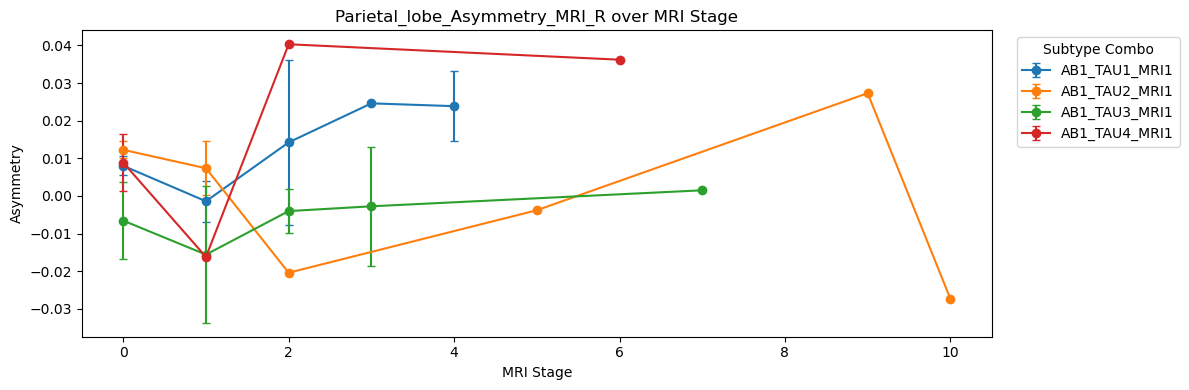

MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.023, r=-0.82, p=0.0889
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.001, r=0.06, p=0.9076
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=0.002, r=0.54, p=0.3443
MRI | Temporal_lobe_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=-0.027, r=-0.79, p=0.2078


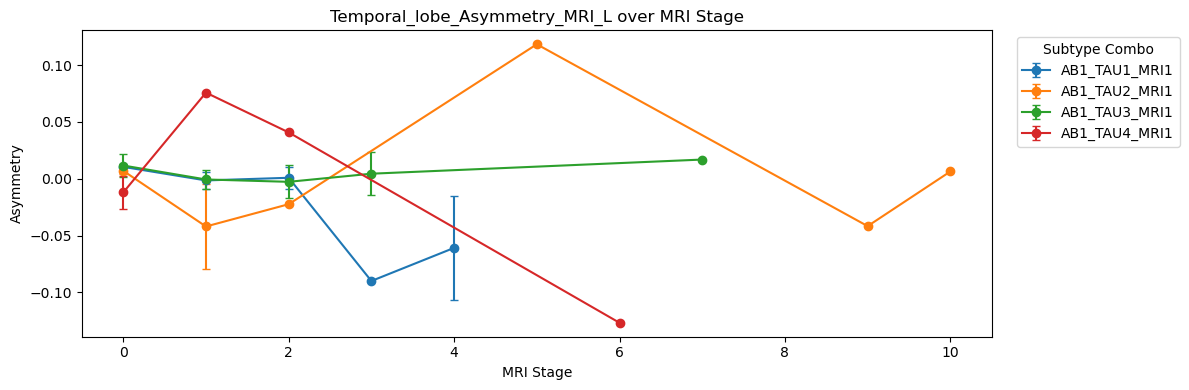

MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.023, r=0.82, p=0.0889
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.001, r=-0.06, p=0.9076
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=-0.002, r=-0.54, p=0.3443
MRI | Temporal_lobe_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=0.027, r=0.79, p=0.2078


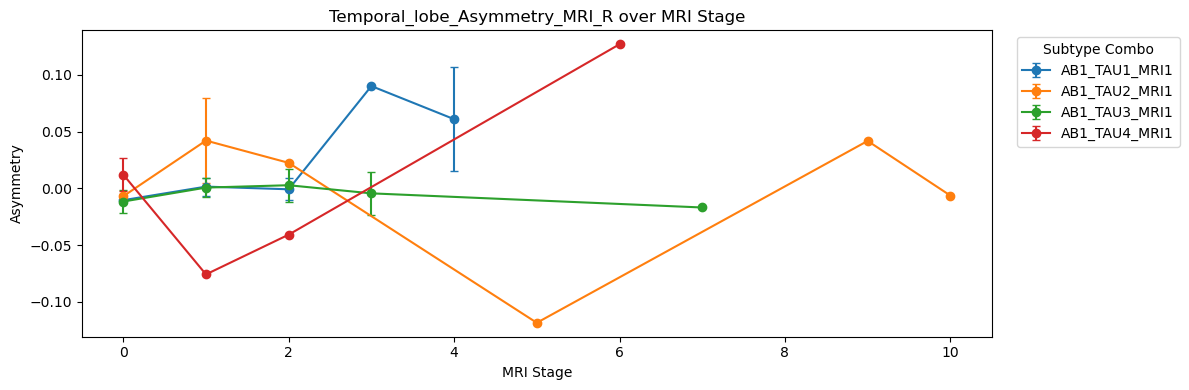

MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU1_MRI1 | Slope=-0.015, r=-0.83, p=0.0800
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU2_MRI1 | Slope=0.007, r=0.33, p=0.5182
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU3_MRI1 | Slope=-0.015, r=-0.81, p=0.0955
MRI | MTL_Asymmetry_MRI_L | Combo AB1_TAU4_MRI1 | Slope=0.005, r=0.17, p=0.8323


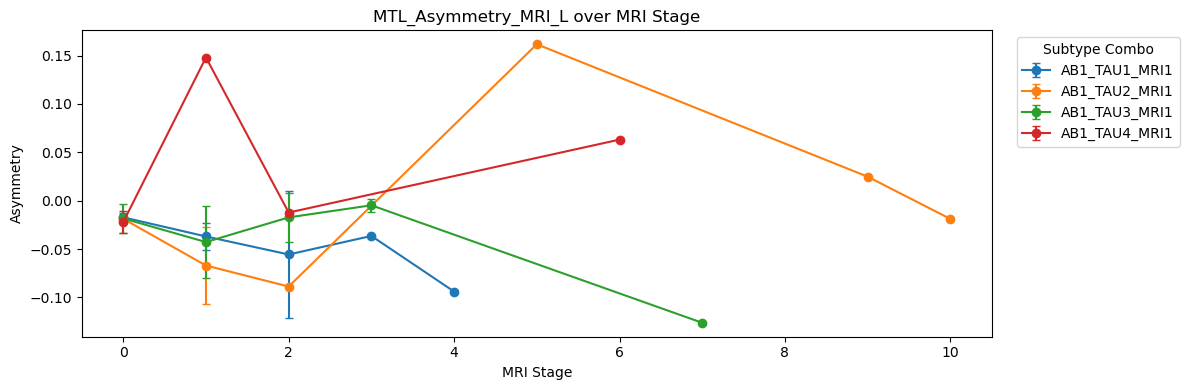

MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU1_MRI1 | Slope=0.015, r=0.83, p=0.0800
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU2_MRI1 | Slope=-0.007, r=-0.33, p=0.5182
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU3_MRI1 | Slope=0.015, r=0.81, p=0.0955
MRI | MTL_Asymmetry_MRI_R | Combo AB1_TAU4_MRI1 | Slope=-0.005, r=-0.17, p=0.8323


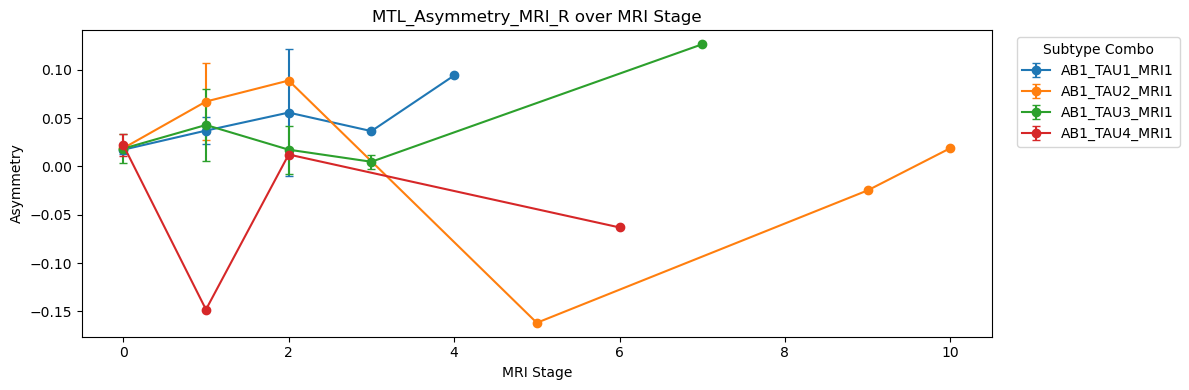


====== Statistically Significant Asymmetry Findings (p < 0.05) ======
  Modality                          Region  Subtype_Combo     Slope         r  \
0       AB   Occipital_lobe_Asymmetry_ab_L  AB1_TAU2_MRI1 -0.008956 -0.677525   
1       AB   Occipital_lobe_Asymmetry_ab_R  AB1_TAU2_MRI1  0.008956  0.677525   
2       AB              MTL_Asymmetry_ab_L  AB1_TAU3_MRI1 -0.002377 -0.672509   
3       AB              MTL_Asymmetry_ab_R  AB1_TAU3_MRI1  0.002377  0.672509   
6      MRI  Occipital_lobe_Asymmetry_MRI_L  AB1_TAU1_MRI1 -0.015160 -0.893230   
7      MRI  Occipital_lobe_Asymmetry_MRI_R  AB1_TAU1_MRI1  0.015160  0.893230   
4      TAU             MTL_Asymmetry_tau_L  AB1_TAU4_MRI1 -0.003092 -0.887334   
5      TAU             MTL_Asymmetry_tau_R  AB1_TAU4_MRI1  0.003092  0.887334   

          p  
0  0.021985  
1  0.021985  
2  0.033120  
3  0.033120  
6  0.041203  
7  0.041203  
4  0.044621  
5  0.044621  


In [15]:
asymmetry_vars = {
    'AB': [
        'Frontal_lobe_Asymmetry_ab_L', 'Frontal_lobe_Asymmetry_ab_R',
        'Occipital_lobe_Asymmetry_ab_L', 'Occipital_lobe_Asymmetry_ab_R',
        'Parietal_lobe_Asymmetry_ab_L', 'Parietal_lobe_Asymmetry_ab_R',
        'Temporal_lobe_Asymmetry_ab_L', 'Temporal_lobe_Asymmetry_ab_R',
        'MTL_Asymmetry_ab_L', 'MTL_Asymmetry_ab_R',
    ],
    'TAU': [
        'Frontal_lobe_Asymmetry_tau_L', 'Frontal_lobe_Asymmetry_tau_R',
        'Occipital_lobe_Asymmetry_tau_L', 'Occipital_lobe_Asymmetry_tau_R',
        'Parietal_lobe_Asymmetry_tau_L', 'Parietal_lobe_Asymmetry_tau_R',
        'Temporal_lobe_Asymmetry_tau_L', 'Temporal_lobe_Asymmetry_tau_R',
        'MTL_Asymmetry_tau_L', 'MTL_Asymmetry_tau_R',
    ],
    'MRI': [
        'Frontal_lobe_Asymmetry_MRI_L', 'Frontal_lobe_Asymmetry_MRI_R',
        'Occipital_lobe_Asymmetry_MRI_L', 'Occipital_lobe_Asymmetry_MRI_R',
        'Parietal_lobe_Asymmetry_MRI_L', 'Parietal_lobe_Asymmetry_MRI_R',
        'Temporal_lobe_Asymmetry_MRI_L', 'Temporal_lobe_Asymmetry_MRI_R',
        'MTL_Asymmetry_MRI_L', 'MTL_Asymmetry_MRI_R',
    ]
}

modality_stage_cols = {
    'AB': 'ab_ml_stage',
    'TAU': 'tau_ml_stage',
    'MRI': 'mri_ml_stage'
}

modality_subtype_cols = {
    'AB': 'ab_ml_subtype',
    'TAU': 'tau_ml_subtype',
    'MRI': 'mri_ml_subtype'
}

combo_col = 'subtype_combo'
triplet_counts = final_combined_df[combo_col].value_counts()
valid_combos = triplet_counts[triplet_counts >= 10].index.tolist()

significant_results = []

for modality, asym_vars in asymmetry_vars.items():
    stage_col = modality_stage_cols[modality]
    subtype_col = modality_subtype_cols[modality]

    for region in asym_vars:
        if region not in final_combined_df.columns:
            continue

        plt.figure(figsize=(12, 4))

        for subtype_combo in sorted(valid_combos):
            sub_df = final_combined_df[
                (final_combined_df[combo_col] == subtype_combo) &
                (final_combined_df[stage_col].notna())
            ]

            grouped = sub_df.groupby(stage_col)[region]
            means = grouped.mean()
            sems = grouped.sem()

            if means.empty:
                continue

            plt.errorbar(means.index, means.values, yerr=sems, label=f'{subtype_combo}',
                         marker='o', capsize=3)

            # Linear regression & print per combo-region-modality
            if len(means) > 1:
                slope, intercept, r, pval, stderr = linregress(means.index, means.values)
                print(f"{modality} | {region} | Combo {subtype_combo} | "
                      f"Slope={slope:.3f}, r={r:.2f}, p={pval:.4f}")

                # Store if significant
                if pval < 0.05:
                    significant_results.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype_Combo': subtype_combo,
                        'Slope': slope,
                        'r': r,
                        'p': pval
                    })

        plt.title(f"{region} over {modality} Stage")
        plt.xlabel(f"{modality} Stage")
        plt.ylabel("Asymmetry")
        plt.legend(title="Subtype Combo", bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# Final summary of all significant findings
sig_df = pd.DataFrame(significant_results)
if not sig_df.empty:
    print("\n====== Statistically Significant Asymmetry Findings (p < 0.05) ======")
    print(sig_df.sort_values(['Modality', 'p']))
else:
    print("\nNo statistically significant asymmetry trends detected (p < 0.05).")


In [16]:
asym_onsets = []

# Loop through each modality
for modality in ['AB', 'TAU', 'MRI']:
    subtype_col = f'{modality.lower()}_ml_subtype'  # ab_ml_subtype, etc.
    stage_col = f'{modality.lower()}_ml_stage'      # ab_ml_stage, etc.
    asym_vars = asymmetry_vars[modality]

    # Drop rows missing relevant columns
    df_mod = final_combined_df.dropna(subset=[subtype_col, stage_col])

    subtypes = sorted(df_mod[subtype_col].unique())

    for region in asym_vars:
        if region not in df_mod.columns:
            continue

        for subtype in subtypes:
            sub_df = df_mod[df_mod[subtype_col] == subtype]
            grouped = sub_df.groupby(stage_col)[region]

            for stage, values in grouped:
                values = values.dropna()
                if len(values) < 5:
                    continue

                t_stat, p_val = ttest_1samp(values, 0)
                mean_val = values.mean()

                if p_val < 0.05 and abs(mean_val) > 0.05:
                    asym_onsets.append({
                        'Modality': modality,
                        'Region': region,
                        'Subtype': subtype+1,
                        'Stage': stage,
                        'MeanAsym': round(mean_val, 3),
                        'p': round(p_val, 4)
                    })
                    break  # First significant stage = onset

# Format and print results
onset_df = pd.DataFrame(asym_onsets)
onset_df = onset_df.sort_values(by=['Modality', 'Subtype', 'Region', 'Stage'])

print("\n==== Asymmetry Onset by Subtype & Region (first stage with significant asymmetry) ====\n")
print(onset_df)

# Optional summary: earliest stage per region-subtype
early_asym_counts = onset_df.groupby(['Modality', 'Subtype', 'Region'])['Stage'].min().sort_values()
print("\n==== Earliest Significant Asymmetry Stage per Region & Subtype ====\n")
print(early_asym_counts)



==== Asymmetry Onset by Subtype & Region (first stage with significant asymmetry) ====

  Modality                          Region  Subtype  Stage  MeanAsym       p
0      MRI  Occipital_lobe_Asymmetry_MRI_L      1.0    2.0    -0.053  0.0213
1      MRI  Occipital_lobe_Asymmetry_MRI_R      1.0    2.0     0.053  0.0213

==== Earliest Significant Asymmetry Stage per Region & Subtype ====

Modality  Subtype  Region                        
MRI       1.0      Occipital_lobe_Asymmetry_MRI_L    2.0
                   Occipital_lobe_Asymmetry_MRI_R    2.0
Name: Stage, dtype: float64



====== Memory Score Across Stages in AB ======
AB1_TAU1_MRI1 | Slope = -0.151, r = -0.42, p = 0.1758
AB1_TAU2_MRI1 | Slope = -0.351, r = -0.40, p = 0.2271
AB1_TAU3_MRI1 | Slope = 0.193, r = 0.23, p = 0.5303
AB1_TAU4_MRI1 | Slope = 0.316, r = 0.23, p = 0.5814


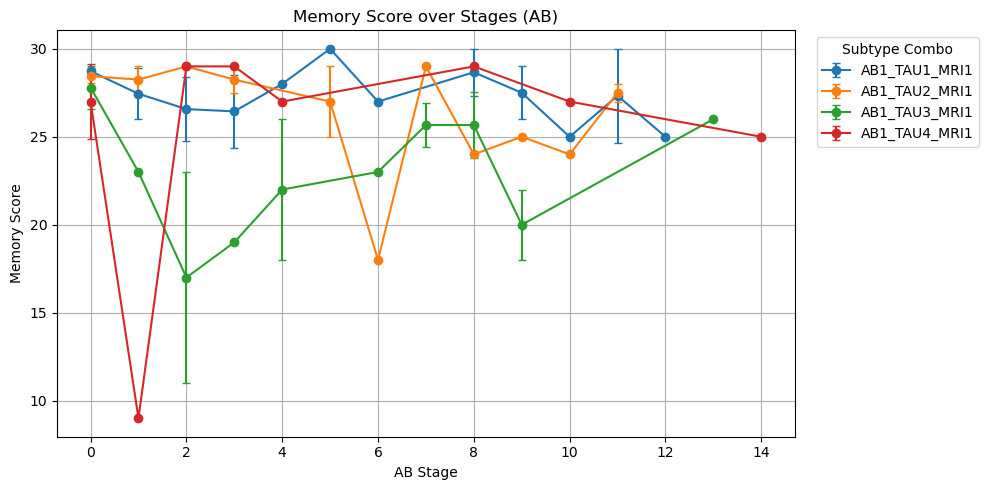


====== Memory Score Across Stages in TAU ======
AB1_TAU1_MRI1 | Slope = -0.987, r = -0.72, p = 0.1094
AB1_TAU2_MRI1 | Slope = 0.268, r = 0.23, p = 0.8490
AB1_TAU3_MRI1 | Slope = -0.623, r = -0.62, p = 0.0584
AB1_TAU4_MRI1 | Slope = -0.801, r = -0.69, p = 0.1932


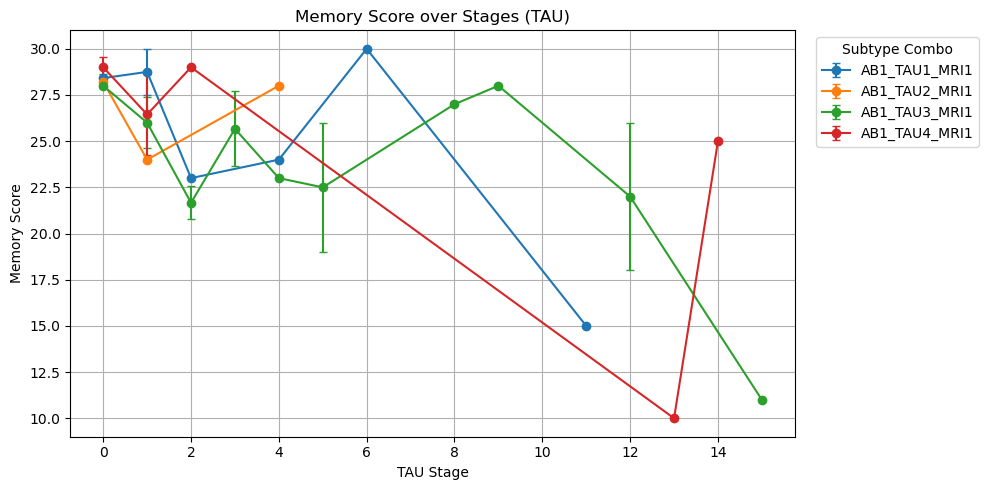


====== Memory Score Across Stages in MRI ======
AB1_TAU1_MRI1 | Slope = -2.797, r = -0.94, p = 0.0169
AB1_TAU2_MRI1 | Slope = -0.367, r = -0.34, p = 0.5074
AB1_TAU3_MRI1 | Slope = -0.022, r = -0.01, p = 0.9844
AB1_TAU4_MRI1 | Slope = -3.199, r = -0.93, p = 0.0666


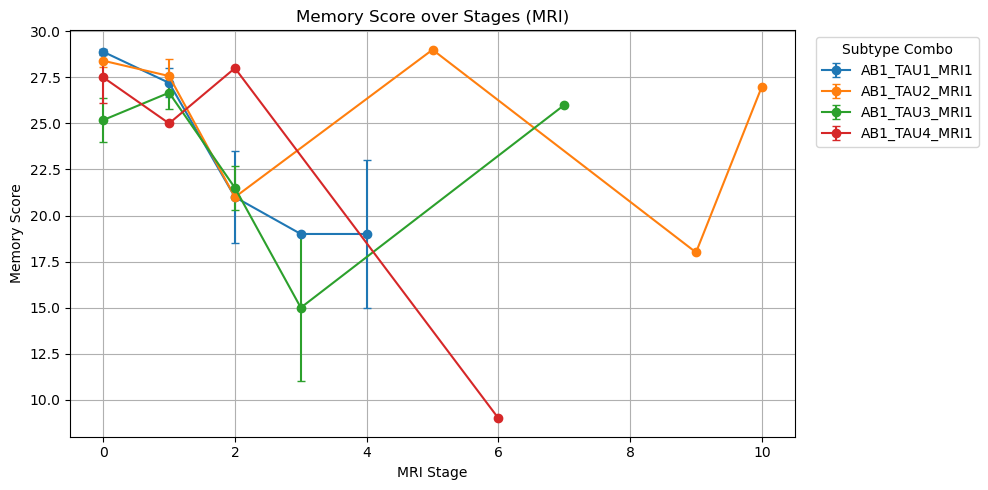

In [17]:
# Define SuStaIn stage column per modality
modality_stage_cols = {
    'AB': 'ab_ml_stage',
    'TAU': 'tau_ml_stage',
    'MRI': 'mri_ml_stage'
}

# Replace with your actual memory score column (e.g., 'ADNI_MEM')
memory_col = mmse_score  # or use mmse_score if defined earlier

# Filter combos with enough data
combo_col = 'subtype_combo'
valid_combos = final_combined_df[combo_col].value_counts()
valid_combos = valid_combos[valid_combos >= 10].index.tolist()  # Only combos with ≥10 subjects

# Loop through each modality stage
for modality, stage_col in modality_stage_cols.items():
    print(f"\n====== Memory Score Across Stages in {modality} ======")

    df = final_combined_df.copy()

    if stage_col not in df.columns:
        print(f"  Stage column '{stage_col}' not found.")
        continue

    if memory_col not in df.columns:
        print(f"  Memory score column '{memory_col}' not found.")
        continue

    plt.figure(figsize=(10, 5))

    for combo in sorted(valid_combos):
        sub_df = df[(df[combo_col] == combo) & (df[stage_col].notna())]

        grouped = sub_df.groupby(stage_col)[memory_col]
        means = grouped.mean()
        sems = grouped.sem()

        if means.empty:
            continue

        plt.errorbar(means.index, means.values, yerr=sems,
                     label=combo, marker='o', capsize=3)

        if len(means) > 1:
            slope, _, r, pval, _ = linregress(means.index, means.values)
            print(f"{combo} | Slope = {slope:.3f}, r = {r:.2f}, p = {pval:.4f}")

    plt.title(f"Memory Score over Stages ({modality})")
    plt.xlabel(f"{modality} Stage")
    plt.ylabel("Memory Score")
    plt.legend(title='Subtype Combo', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [18]:
# === Step 1: Load model predictions ===
triplet_df = pd.read_csv("predicted_triplet_scores.csv")

# === Step 2: Ensure all possible triplets are present ===
all_triplets = [f"AB{a}_TAU{t}_MRI{m}" for a in range(1, 3)
                                         for t in range(1, 5)
                                         for m in range(1, 5)]

triplet_score_dict = dict(zip(triplet_df["Triplet"], triplet_df["Score"]))
triplet_df_full = pd.DataFrame({
    "Triplet": all_triplets,
    "Predicted_Score": [triplet_score_dict.get(triplet, 0.0) for triplet in all_triplets]
})

# === Step 3: Model rank (tie-aware, alphabetic tiebreak) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Predicted_Score", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Model_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 4: Observed counts using subtype_combo ===
combo_counts = final_combined_df["subtype_combo"].value_counts().to_dict()
triplet_df_full["Observed_Count"] = triplet_df_full["Triplet"].map(combo_counts).fillna(0).astype(int)

# === Step 5: Observed rank (tie-aware) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Observed_Count", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Observed_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 6: Sort back to Triplet order ===
triplet_df_full = triplet_df_full.sort_values("Triplet").reset_index(drop=True)

# === Step 7: Spearman correlation ===
corr, pval = spearmanr(triplet_df_full["Model_Rank"], triplet_df_full["Observed_Rank"])
print(f"Spearman correlation between model and observed triplet rankings: r = {corr:.3f}, p = {pval:.4f}")

# === Step 8: Show top N triplets ===
triplets = triplet_df_full.sort_values("Model_Rank")

# Format floats to 2 decimal places
pd.options.display.float_format = "{:.6f}".format

# Display nicely
display_cols = ["Triplet", "Model_Rank", "Observed_Rank", "Observed_Count", "Predicted_Score"]
print(triplets[display_cols].to_string(index=False))

# Reset to default float format if needed
pd.reset_option("display.float_format")


Spearman correlation between model and observed triplet rankings: r = 0.923, p = 0.0000
      Triplet  Model_Rank  Observed_Rank  Observed_Count  Predicted_Score
AB1_TAU1_MRI1           1              1             141         0.035491
AB1_TAU2_MRI1           2              2             103         0.023974
AB1_TAU3_MRI1           3              3              24         0.004253
AB2_TAU1_MRI1           4             20               0         0.001302
AB1_TAU4_MRI1           5              4              17         0.001256
AB1_TAU2_MRI2           6             13               1         0.000550
AB2_TAU2_MRI1           7             10               2         0.000420
AB1_TAU1_MRI2           8              6               3         0.000324
AB1_TAU1_MRI3           9              7               2         0.000300
AB1_TAU1_MRI4          10              5               4         0.000218
AB1_TAU2_MRI4          11              9               2         0.000208
AB1_TAU2_MRI3          1

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# === Step 1: Load model predictions ===
triplet_df = pd.read_csv("predicted_triplet_scores.csv")

# === Step 2: Ensure all possible triplets are present ===
all_triplets = [f"AB{a}_TAU{t}_MRI{m}" for a in range(1, 3)
                                         for t in range(1, 5)
                                         for m in range(1, 5)]

triplet_score_dict = dict(zip(triplet_df["Triplet"], triplet_df["Score"]))
triplet_df_full = pd.DataFrame({
    "Triplet": all_triplets,
    "Predicted_Score": [triplet_score_dict.get(triplet, 0.0) for triplet in all_triplets]
})

# === Step 3: Model rank (tie-aware, alphabetic tiebreak) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Predicted_Score", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Model_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 4: Observed counts using subtype_combo ===
combo_counts = final_combined_df["subtype_combo"].value_counts().to_dict()
triplet_df_full["Observed_Count"] = triplet_df_full["Triplet"].map(combo_counts).fillna(0).astype(int)

# === Step 5: Observed rank (tie-aware) ===
triplet_df_full = triplet_df_full.sort_values(
    by=["Observed_Count", "Triplet"], ascending=[False, True]
).reset_index(drop=True)
triplet_df_full["Observed_Rank"] = range(1, len(triplet_df_full) + 1)

# === Step 6: Sort back to Triplet order ===
triplet_df_full = triplet_df_full.sort_values("Triplet").reset_index(drop=True)

# === Step 7a: Spearman correlation (all triplets) ===
corr_all, pval_all = spearmanr(triplet_df_full["Model_Rank"], triplet_df_full["Observed_Rank"])
print(f"Spearman correlation (all triplets): r = {corr_all:.3f}, p = {pval_all:.4f}")

# === Step 7b: Spearman correlation (observed triplets only) ===
observed_triplets = triplet_df_full[triplet_df_full["Observed_Count"] > 0]
corr_obs, pval_obs = spearmanr(observed_triplets["Model_Rank"], observed_triplets["Observed_Rank"])
print(f"Spearman correlation (observed triplets only): r = {corr_obs:.3f}, p = {pval_obs:.4f}")

# === Step 8: Show observed triplets only ===
triplets = observed_triplets.sort_values("Model_Rank")

# Format floats to 6 decimal places
pd.options.display.float_format = "{:.6f}".format

display_cols = ["Triplet", "Model_Rank", "Observed_Rank", "Observed_Count", "Predicted_Score"]
print(triplets[display_cols].to_string(index=False))

# Reset to default float format
pd.reset_option("display.float_format")


Spearman correlation (all triplets): r = 0.923, p = 0.0000
Spearman correlation (observed triplets only): r = 0.698, p = 0.0080
      Triplet  Model_Rank  Observed_Rank  Observed_Count  Predicted_Score
AB1_TAU1_MRI1           1              1             141         0.035491
AB1_TAU2_MRI1           2              2             103         0.023974
AB1_TAU3_MRI1           3              3              24         0.004253
AB1_TAU4_MRI1           5              4              17         0.001256
AB1_TAU2_MRI2           6             13               1         0.000550
AB2_TAU2_MRI1           7             10               2         0.000420
AB1_TAU1_MRI2           8              6               3         0.000324
AB1_TAU1_MRI3           9              7               2         0.000300
AB1_TAU1_MRI4          10              5               4         0.000218
AB1_TAU2_MRI4          11              9               2         0.000208
AB1_TAU2_MRI3          12              8               2  

## 2. Longitudinal Testsets

In [20]:
data_long_mri = pd.read_csv('Test_MRI_Modality_5.csv')
data_long_ab = pd.read_csv('Test_AB_Modality_6.csv')
data_long_tau = pd.read_csv('Test_TAU_Modality_7.csv')


# store biomarker labels as a variable
biomarkers_mri = data_long_mri.columns[11:16]
biomarkers_ab = data_long_ab.columns[10:15]
biomarkers_tau = data_long_tau.columns[10:15]

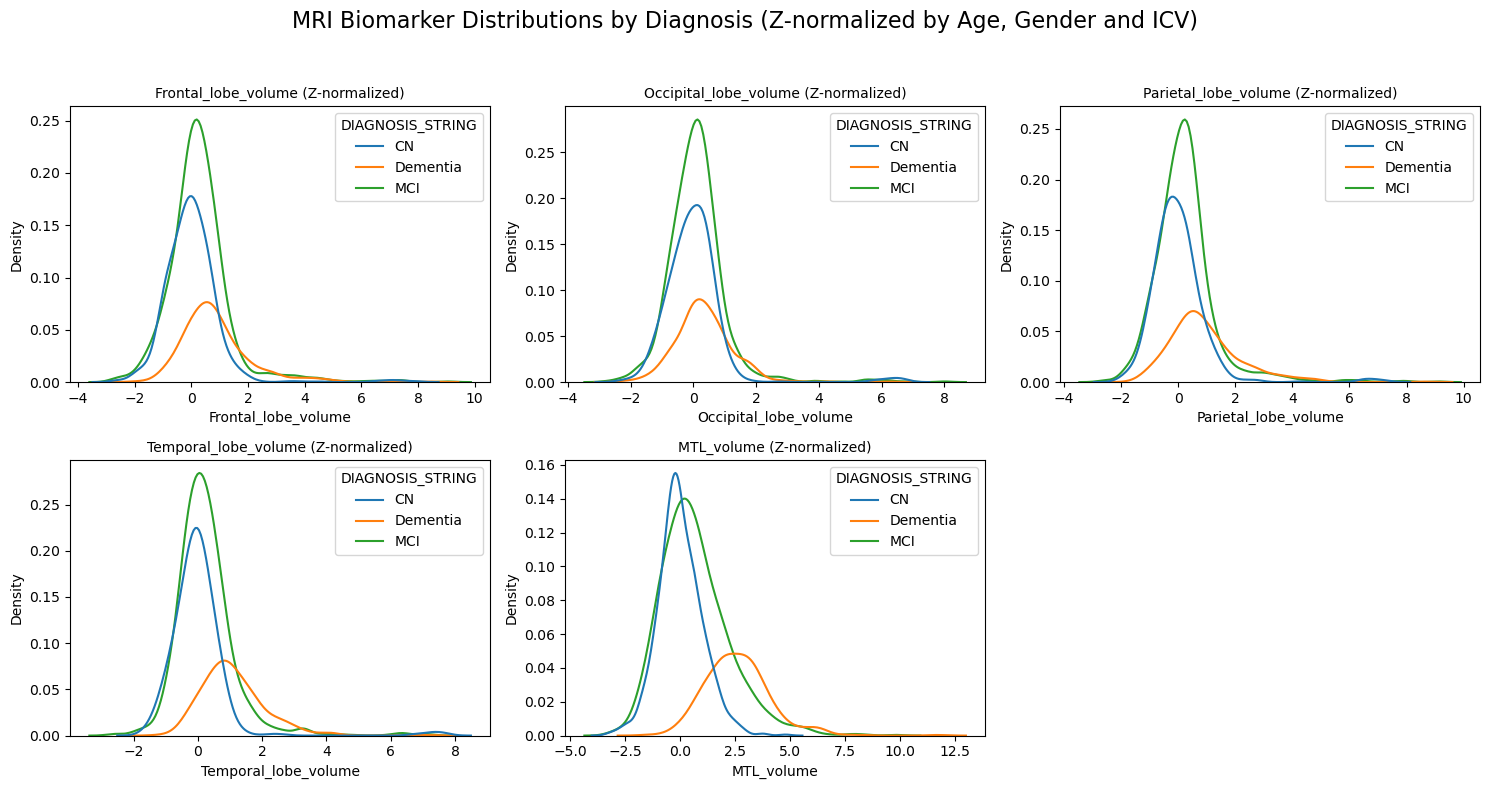

In [21]:
#Normalisation of the Multi MRI data 

# Make a copy of data_mri to store normalized values
zdata_long_mri = pd.DataFrame(data_long_mri.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_mri: 
    model = smf.wls(f'{biomarker} ~ Age + ICV_CorticalVolume + C(PTGENDER)', data=data_long_mri[data_long_mri['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_mri[['Age', 'ICV_CorticalVolume', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_mri[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_mri['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_mri['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_mri[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_mri)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_mri):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_mri, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("MRI Biomarker Distributions by Diagnosis (Z-normalized by Age, Gender and ICV)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



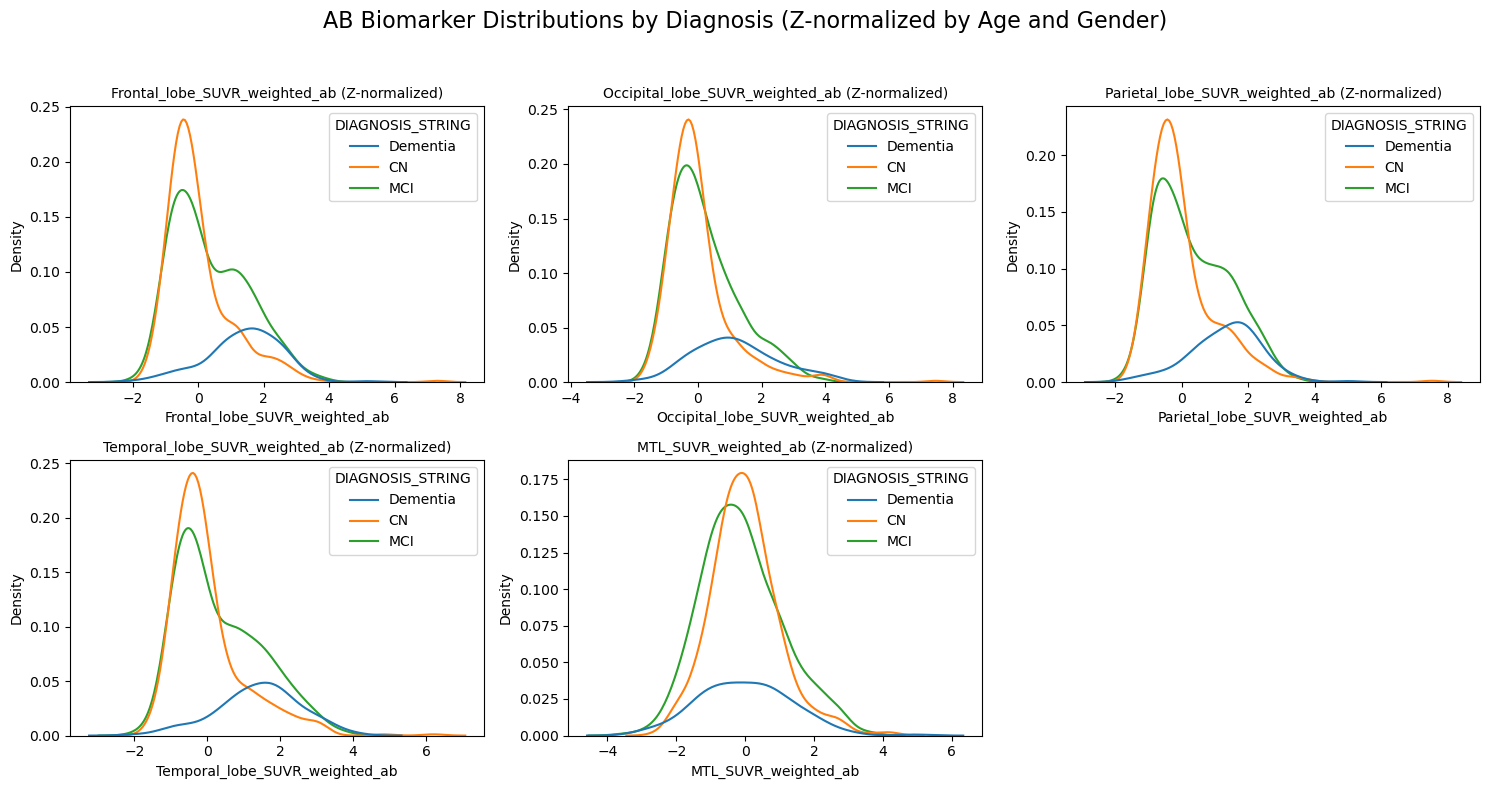

In [22]:
#Normalisation of the Multi AB data 

# Make a copy of data_mri to store normalized values
zdata_long_ab = pd.DataFrame(data_long_ab.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_ab: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_long_ab[data_long_ab['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_ab[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_ab[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_ab['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_ab['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_ab[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_ab)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_ab):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_ab, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("AB Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


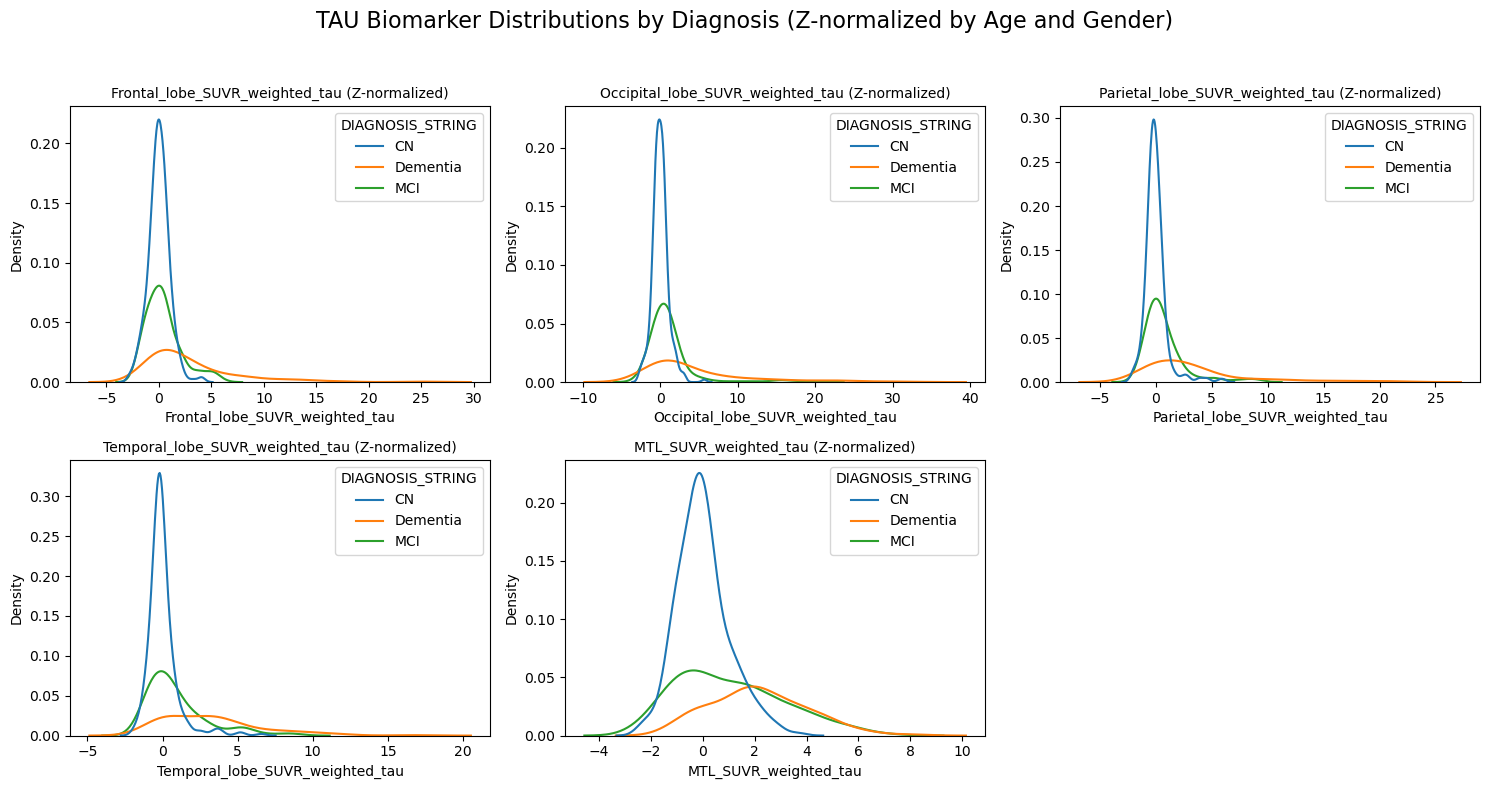

In [23]:
#Normalisation of the Multi TAU data 

# Make a copy of data_mri to store normalized values
zdata_long_tau = pd.DataFrame(data_long_tau.copy())

# Step 1: Normalize all biomarkers to Fit model on CN group only
for biomarker in biomarkers_tau: 
    model = smf.wls(f'{biomarker} ~ Age + C(PTGENDER)', data=data_long_tau[data_long_tau['DIAGNOSIS_STRING'] == 'CN']).fit()
    predicted = model.predict(data_long_tau[['Age', 'PTGENDER']]) # Predict values for all subjects using this CN-based model
    w_score = (data_long_tau[biomarker] - predicted) / model.resid.std() # Compute z-scores (W-score): residuals / std of residuals in CN
    mean_cn = w_score[data_long_tau['DIAGNOSIS_STRING'] == 'CN'].mean() # Calculate mean w-score per diagnosis
    mean_dem = w_score[data_long_tau['DIAGNOSIS_STRING'] == 'Dementia'].mean()
    # If DEM group has a lower mean than CN → flip negative values
    if mean_dem < mean_cn:
        sustain_ready = -w_score
    else:
        sustain_ready = w_score  # Leave as-is
    zdata_long_tau[biomarker] = sustain_ready 

# Step 2: Plot KDE distributions of normalized biomarkers
n = len(biomarkers_tau)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), constrained_layout=True)

for i, biomarker in enumerate(biomarkers_tau):
    ax = axs[i // cols, i % cols]
    sns.kdeplot(data=zdata_long_tau, x=biomarker, hue="DIAGNOSIS_STRING", ax=ax)
    ax.set_title(f"{biomarker} (Z-normalized)", fontsize=10)

# Turn off unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axs[j // cols, j % cols])

plt.suptitle("TAU Biomarker Distributions by Diagnosis (Z-normalized by Age and Gender)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [24]:
#Run the new data into the old models and assign subtype and stage per indivividual

# Assign subtypes/stages for each modality
results_long_mri, prob_long_mri_subtype, prob_long_mri_stage, prob_long_mri_subtype_stage = assign_sustain_subtypes(zdata_long_mri, biomarkers_mri, sustain_input_mri, samples_sequence_mri, samples_f_mri, "mri")
results_long_ab, prob_long_ab_subtype, prob_long_ab_stage, prob_long_ab_subtype_stage = assign_sustain_subtypes(zdata_long_ab, biomarkers_ab, sustain_input_ab, samples_sequence_ab, samples_f_ab, "ab")
results_long_tau, prob_long_tau_subtype, prob_long_tau_stage, prob_long_tau_subtype_stage = assign_sustain_subtypes(zdata_long_tau, biomarkers_tau, sustain_input_tau, samples_sequence_tau, samples_f_tau, "tau")

# Join results to the normalized z-scored dataframes
zdata_long_mri = zdata_long_mri.join(results_long_mri)
zdata_long_ab  = zdata_long_ab.join(results_long_ab)
zdata_long_tau = zdata_long_tau.join(results_long_tau)

# Sort by RID and Date
zdata_long_mri = zdata_long_mri.sort_values([rid, dat]).copy()
zdata_long_ab  = zdata_long_ab.sort_values([rid, dat]).copy()
zdata_long_tau = zdata_long_tau.sort_values([rid, dat]).copy()



In [25]:
def compute_consistency(df, modality, stage_diff_threshold=1):
    sub_col = f"{modality}_ml_subtype"
    stage_col = f"{modality}_ml_stage"

    results = []
    for rid, group in df.groupby("RID"):
        group_sorted = group.sort_values("EXAMDATE")

        # Extract subtype + stage values
        subtypes = group_sorted[sub_col].dropna().tolist()
        stages = group_sorted[stage_col].dropna().tolist()

        # Default values
        subtype_consistent = False
        stage_stable = False

        if len(subtypes) > 0:
            # Subtype consistency: all the same
            subtype_consistent = len(set(subtypes)) == 1

            # Stage stability: only check if subtype is consistent
            if subtype_consistent and len(stages) > 0:
                stage_stable = (max(stages) - min(stages)) <= stage_diff_threshold

        results.append({
            "RID": rid,
            "subtype_consistent": subtype_consistent,
            "stage_stable": stage_stable
        })

    return pd.DataFrame(results)

# --- Overall summary ---
def consistency_overview(df, modality):
    total = len(df)
    consistent_subtype = df["subtype_consistent"].sum()
    stable_stage = df["stage_stable"].sum()
    both_consistent = ((df["subtype_consistent"]) & (df["stage_stable"])).sum()

    print(f"\n--- {modality.upper()} CONSISTENCY SUMMARY ---")
    print(f"Total subjects: {total}")
    print(f"Consistent subtype: {consistent_subtype} ({consistent_subtype/total:.1%})")
    print(f"Stable stage (≤1 diff): {stable_stage} ({stable_stage/total:.1%})")

# Diagnosis shift quantification
def quantify_diagnosis_shifts(df, modality):
    total_subjects = df["RID"].nunique()
    dx_shift_counts = Counter()
    shifted_subjects = 0

    for rid, group in df.groupby("RID"):
        dx_ordered = group.sort_values("EXAMDATE")[dx].dropna().tolist()
        dx_unique = list(pd.Series(dx_ordered).drop_duplicates())

        if len(dx_unique) > 1:
            shifted_subjects += 1
            for i in range(1, len(dx_ordered)):
                if dx_ordered[i] != dx_ordered[i-1]:
                    dx_shift_counts[(dx_ordered[i-1], dx_ordered[i])] += 1

    print(f"\n{modality} DIAGNOSIS SHIFT ANALYSIS")
    print(f"Total subjects: {total_subjects}")
    print(f"Subjects with diagnosis shift: {shifted_subjects} ({shifted_subjects / total_subjects:.1%})")
    print("\nMost common diagnosis transitions (from → to):")
    for (from_dx, to_dx), count in dx_shift_counts.most_common():
        proportion = count / total_subjects
        print(f"{from_dx} → {to_dx}: {count} times ({proportion:.1%})")

# Subtype shift quantification
def quantify_subtype_shifts(df, modality):
    sub_col = f"{modality}_ml_subtype"

    shift_counts = Counter()
    total_subjects = df["RID"].nunique()
    shifted_subjects = 0

    for rid, group in df.groupby("RID"):
        subtypes = list(group[sub_col].dropna().unique())
        if len(subtypes) > 1:
            shifted_subjects += 1
            ordered = group.sort_values("EXAMDATE")[sub_col].tolist()
            for i in range(1, len(ordered)):
                if ordered[i] != ordered[i-1]:
                    shift_counts[(ordered[i-1], ordered[i])] += 1

    print(f"\n{modality.upper()} SUBTYPE SHIFT ANALYSIS")
    print(f"Total subjects: {total_subjects}")
    print(f"Subjects with subtype shift: {shifted_subjects} ({shifted_subjects / total_subjects:.1%})")
    print("\nMost common subtype transitions (from → to):")
    for (from_sub, to_sub), count in shift_counts.most_common():
        proportion = count / total_subjects
        print(f"{from_sub} → {to_sub}: {count} times ({proportion:.1%})")



# Create consistency tables for each modality, summaries, run quantifications for diagnosisand subtypes
#AB
ab_consistency = compute_consistency(zdata_long_ab, "ab")
consistency_overview(ab_consistency, "ab")
quantify_diagnosis_shifts(zdata_long_ab, "AB") 
quantify_subtype_shifts(zdata_long_ab, "ab")
#TAU
tau_consistency = compute_consistency(zdata_long_tau, "tau")
consistency_overview(tau_consistency, "tau")
quantify_diagnosis_shifts(zdata_long_tau, "TAU") 
quantify_subtype_shifts(zdata_long_tau, "tau")
#MRI
mri_consistency = compute_consistency(zdata_long_mri, "mri")
consistency_overview(mri_consistency, "mri")
quantify_diagnosis_shifts(zdata_long_mri, "MRI") 
quantify_subtype_shifts(zdata_long_mri, "mri")



--- AB CONSISTENCY SUMMARY ---
Total subjects: 464
Consistent subtype: 458 (98.7%)
Stable stage (≤1 diff): 357 (76.9%)

AB DIAGNOSIS SHIFT ANALYSIS
Total subjects: 464
Subjects with diagnosis shift: 118 (25.4%)

Most common diagnosis transitions (from → to):
MCI → Dementia: 67 times (14.4%)
CN → MCI: 29 times (6.2%)
MCI → CN: 23 times (5.0%)
CN → Dementia: 4 times (0.9%)
Dementia → MCI: 1 times (0.2%)

AB SUBTYPE SHIFT ANALYSIS
Total subjects: 464
Subjects with subtype shift: 6 (1.3%)

Most common subtype transitions (from → to):
0.0 → 1.0: 4 times (0.9%)
1.0 → 0.0: 2 times (0.4%)

--- TAU CONSISTENCY SUMMARY ---
Total subjects: 234
Consistent subtype: 172 (73.5%)
Stable stage (≤1 diff): 156 (66.7%)

TAU DIAGNOSIS SHIFT ANALYSIS
Total subjects: 234
Subjects with diagnosis shift: 42 (17.9%)

Most common diagnosis transitions (from → to):
MCI → Dementia: 20 times (8.5%)
CN → MCI: 16 times (6.8%)
MCI → CN: 7 times (3.0%)
Dementia → MCI: 1 times (0.4%)

TAU SUBTYPE SHIFT ANALYSIS
Total su

In [26]:
# Detect diagnosis regressions (DEM->MCI->CN) with time difference
def find_diagnosis_regressions(df, dx_col=dx, rid_col="RID", date_col=dat):
    # Define diagnosis severity order
    severity = {"CN": 0, "MCI": 1, "Dementia": 2}

    regressions = []

    for rid, group in df.groupby(rid_col):
        group_sorted = group.sort_values(date_col)
        dx_list = group_sorted[dx_col].dropna().tolist()
        dx_dates = pd.to_datetime(group_sorted[date_col]).tolist()

        if len(dx_list) < 2:
            continue

        for i in range(1, len(dx_list)):
            prev_dx = dx_list[i-1]
            curr_dx = dx_list[i]
            if prev_dx in severity and curr_dx in severity:
                if severity[curr_dx] < severity[prev_dx]:  # regression detected
                    days_diff = (dx_dates[i] - dx_dates[i-1]).days
                    years_diff = days_diff / 365.25
                    regressions.append({
                        "RID": rid,
                        "from_dx": prev_dx,
                        "to_dx": curr_dx,
                        "from_date": dx_dates[i-1],
                        "to_date": dx_dates[i],
                        "years_between": round(years_diff, 2)
                    })

    return pd.DataFrame(regressions)


# Apply to each modality
regress_ab = find_diagnosis_regressions(zdata_long_ab, dx_col=dx)
regress_tau = find_diagnosis_regressions(zdata_long_tau, dx_col=dx)
regress_mri = find_diagnosis_regressions(zdata_long_mri, dx_col=dx)

# Display results
print("\n--- AB DIAGNOSIS REGRESSIONS ---")
print(regress_ab)
print(f"\nThe mean number of years between regression subjects examination dates is: ")
print(regress_ab["years_between"].mean())

print("\n--- TAU DIAGNOSIS REGRESSIONS ---")
print(regress_tau)
print(f"\nThe mean number of years between regression subjects examination dates is: ")
print(regress_tau["years_between"].mean())

print("\n--- MRI DIAGNOSIS REGRESSIONS ---")
print(regress_mri)
print(f"\nThe mean number of years between regression subjects examination dates is: ")
print(regress_mri["years_between"].mean())



--- AB DIAGNOSIS REGRESSIONS ---
     RID   from_dx to_dx  from_date    to_date  years_between
0   2007       MCI    CN 2010-07-06 2013-05-09           2.84
1   2010       MCI    CN 2010-07-08 2012-07-12           2.01
2   2018       MCI    CN 2012-06-13 2018-12-04           6.48
3   2073       MCI    CN 2012-09-18 2014-10-07           2.05
4   2184       MCI    CN 2010-12-01 2017-10-09           6.86
5   2233       MCI    CN 2014-03-05 2019-01-29           4.90
6   2394       MCI    CN 2019-07-30 2023-10-26           4.24
7   4004       MCI    CN 2015-04-30 2017-10-10           2.45
8   4061       MCI    CN 2013-06-25 2019-11-26           6.42
9   4072       MCI    CN 2013-07-10 2015-07-24           2.04
10  4168       MCI    CN 2013-09-12 2015-09-14           2.00
11  4184       MCI    CN 2013-09-12 2017-10-30           4.13
12  4214       MCI    CN 2013-10-16 2015-10-16           2.00
13  4310       MCI    CN 2011-11-11 2013-11-08           1.99
14  4381       MCI    CN 2014-02-21 

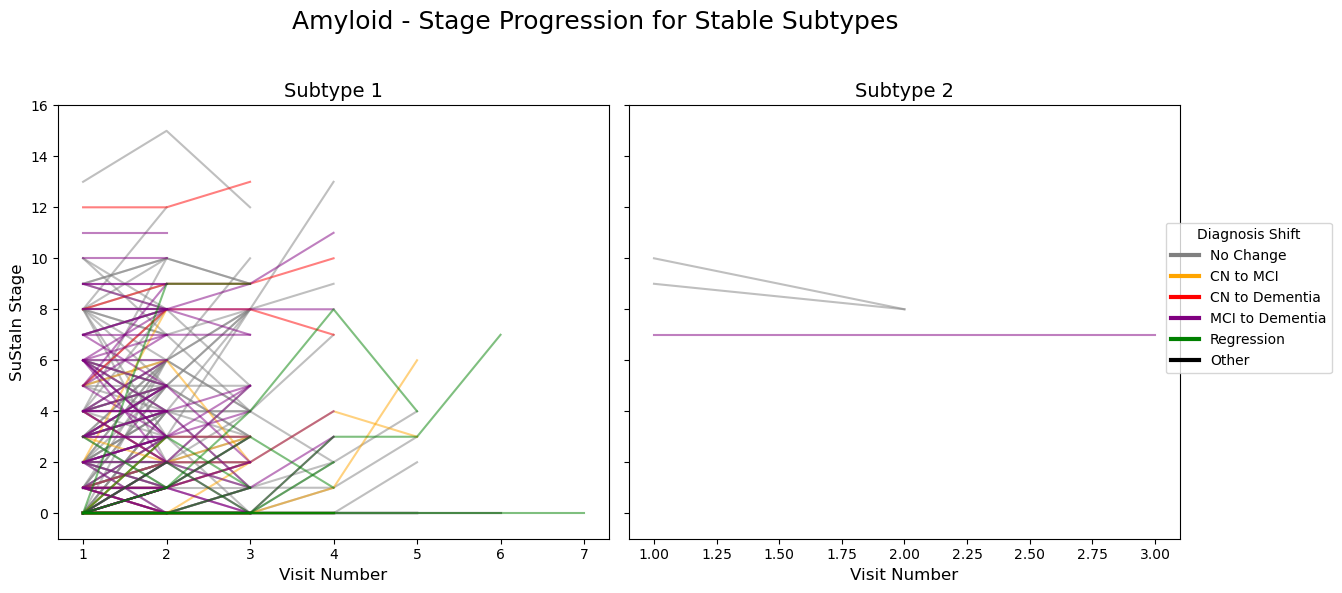

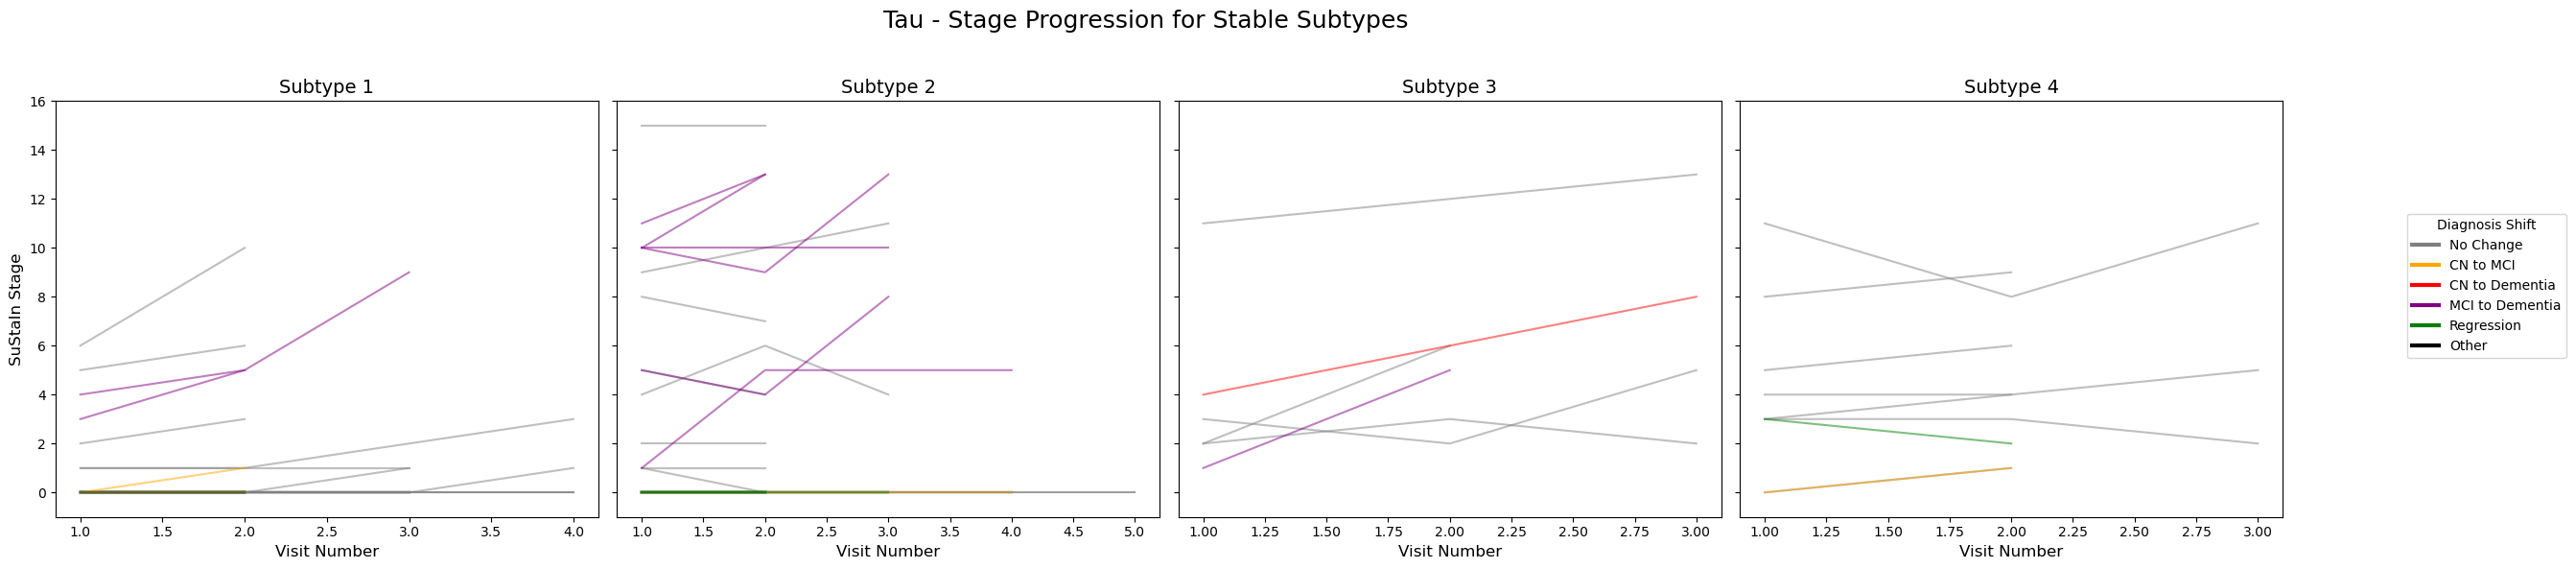

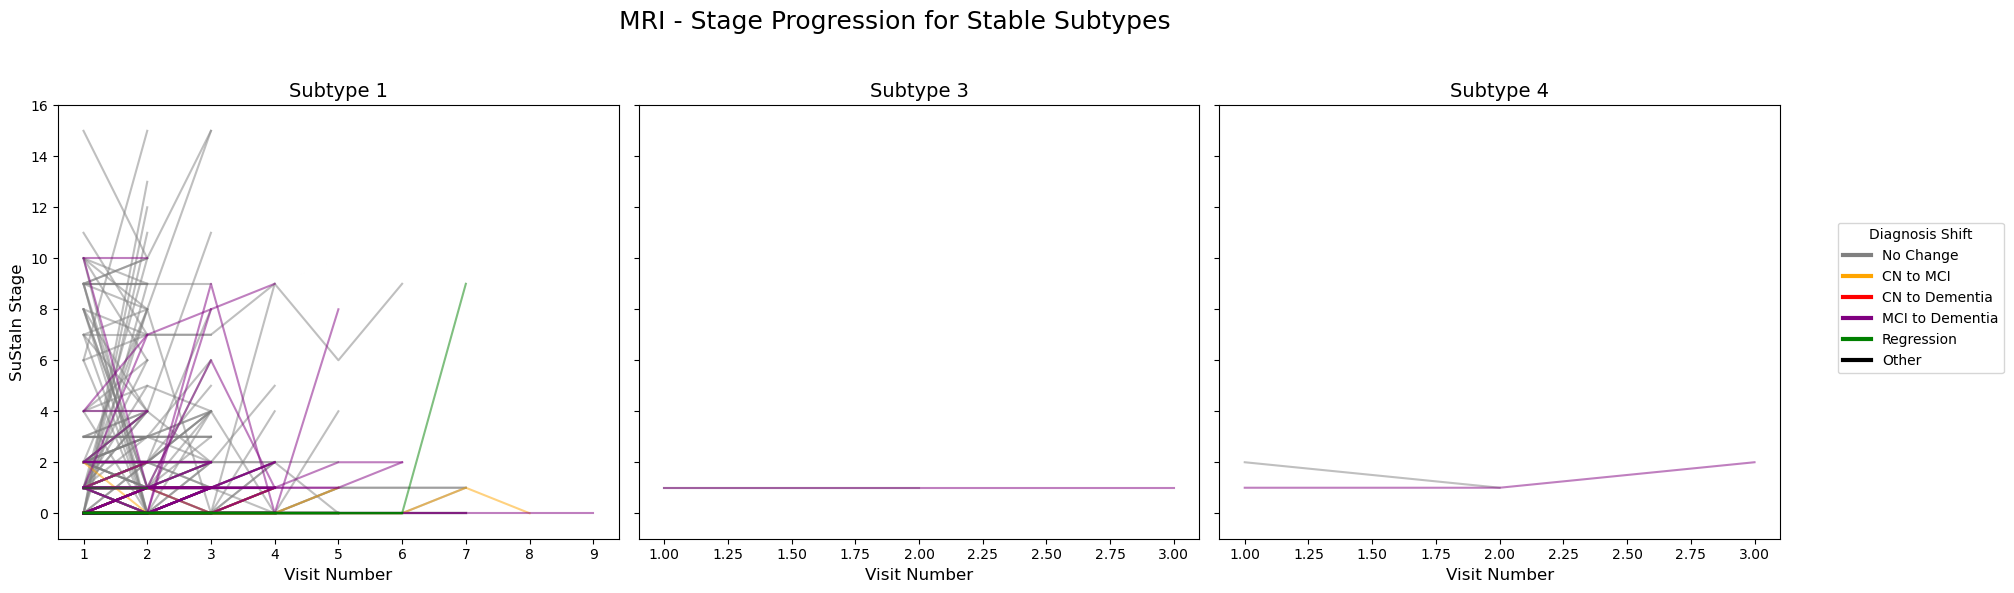

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0   CN to Dementia     Increase      3   75.000000   
1       0.0   CN to Dementia       Stable      1   25.000000   
2       0.0        CN to MCI     Decrease      3   12.500000   
3       0.0        CN to MCI     Increase      7   29.166667   
4       0.0        CN to MCI       Stable     14   58.333333   
5       0.0  MCI to Dementia     Decrease     17   26.562500   
6       0.0  MCI to Dementia     Increase     23   35.937500   
7       0.0  MCI to Dementia       Stable     24   37.500000   
8       0.0        No Change     Decrease     23    6.686047   
9       0.0        No Change     Increase     70   20.348837   
10      0.0        No Change       Stable    251   72.965116   
11      0.0       Regression     Decrease      1    5.263158   
12      0.0       Regression     Increase      7   36.842105   
13      0.0       Regression       Stable     11   57.894737   
14      1.0  MCI to Dementia       Stable      1  100.000000   
15      1.0        No Change     Decrease      2  100.000000   

    Mean_Stage_Change  
0            1.250000  
1            1.250000  
2            0.625000  
3            0.625000  
4            0.625000  
5            0.281250  
6            0.281250  
7            0.281250  
8            0.337209  
9            0.337209  
10           0.337209  
11           1.210526  
12           1.210526  
13           1.210526  
14           0.000000  
15          -1.500000

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0        CN to MCI     Increase      1   25.000000   
1       0.0        CN to MCI       Stable      3   75.000000   
2       0.0  MCI to Dementia     Increase      2   66.666667   
3       0.0  MCI to Dementia       Stable      1   33.333333   
4       0.0        No Change     Increase      6    8.450704   
5       0.0        No Change       Stable     65   91.549296   
6       0.0       Regression       Stable      1  100.000000   
7       1.0        CN to MCI       Stable      4  100.000000   
8       1.0  MCI to Dementia     Increase      5   83.333333   
9       1.0  MCI to Dementia       Stable      1   16.666667   
10      1.0        No Change     Decrease      3    4.687500   
11      1.0        No Change     Increase      1    1.562500   
12      1.0        No Change       Stable     60   93.750000   
13      1.0       Regression       Stable      4  100.000000   
14      2.0   CN to Dementia     Increase      1  100.000000   
15      2.0  MCI to Dementia     Increase      1  100.000000   
16      2.0        No Change     Increase      3   75.000000   
17      2.0        No Change       Stable      1   25.000000   
18      3.0        CN to MCI     Increase      1  100.000000   
19      3.0        No Change     Decrease      1   14.285714   
20      3.0        No Change     Increase      5   71.428571   
21      3.0        No Change       Stable      1   14.285714   
22      3.0       Regression     Decrease      1  100.000000   

    Mean_Stage_Change  
0            0.250000  
1            0.250000  
2            2.333333  
3            2.333333  
4            0.140845  
5            0.140845  
6            0.000000  
7            0.000000  
8            2.500000  
9            2.500000  
10          -0.015625  
11          -0.015625  
12          -0.015625  
13           0.000000  
14           4.000000  
15           4.000000  
16           2.000000  
17           2.000000  
18           1.000000  
19           0.571429  
20           0.571429  
21           0.571429  
22          -1.000000

Subtype  Diagnosis_Shift Stage_Change  Count  Percentage  \
0       0.0   CN to Dementia     Increase      1  100.000000   
1       0.0        CN to MCI     Decrease      1    2.941176   
2       0.0        CN to MCI     Increase      4   11.764706   
3       0.0        CN to MCI       Stable     29   85.294118   
4       0.0  MCI to Dementia     Decrease      2    2.531646   
5       0.0  MCI to Dementia     Increase     29   36.708861   
6       0.0  MCI to Dementia       Stable     48   60.759494   
7       0.0        No Change     Decrease     25    3.415301   
8       0.0        No Change     Increase    120   16.393443   
9       0.0        No Change       Stable    587   80.191257   
10      0.0       Regression     Increase      1    3.333333   
11      0.0       Regression       Stable     29   96.666667   
12      2.0  MCI to Dementia       Stable      1  100.000000   
13      2.0        No Change       Stable      1  100.000000   
14      3.0  MCI to Dementia     Increase      1  100.000000   
15      3.0        No Change     Decrease      1  100.000000   

    Mean_Stage_Change  
0            1.000000  
1            0.088235  
2            0.088235  
3            0.088235  
4            0.582278  
5            0.582278  
6            0.582278  
7            0.214481  
8            0.214481  
9            0.214481  
10           0.300000  
11           0.300000  
12           0.000000  
13           0.000000  
14           1.000000  
15          -1.000000

In [27]:
# Diagnosis shift function 
def get_diag_shift(group):
    diag_start = group.iloc[0][dx]
    diag_end = group.iloc[-1][dx]
    if diag_start == diag_end:
        return "No Change"
    elif diag_start == "CN" and diag_end == "MCI":
        return "CN to MCI"
    elif diag_start == "CN" and diag_end == "Dementia":
        return "CN to Dementia"
    elif diag_start == "MCI" and diag_end == "Dementia":
        return "MCI to Dementia"
    elif (diag_start == "Dementia" and diag_end in ["MCI", "CN"]) or \
         (diag_start == "MCI" and diag_end == "CN"):
        return "Regression"
    else:
        return "Other"

# Colors for diagnosis shift
shift_colors = {
    "No Change": "gray",
    "CN to MCI": "orange",
    "CN to Dementia": "red",
    "MCI to Dementia": "purple",
    "Regression": "green",
    "Other": "black"
}

def plot_stable_subtypes_by_stage(df, modality_label, mod):
    df = df.sort_values(["RID", dat]).copy()
    df["Visit_Number"] = df.groupby("RID").cumcount() + 1

    # Add diagnosis shift per subject
    diag_shift_per_subject = df.groupby("RID").apply(get_diag_shift).reset_index(name="Diagnosis_Shift")
    df = df.merge(diag_shift_per_subject, on="RID", how="left")

    subtype_col = f"{mod}_ml_subtype"
    stage_col = f"{mod}_ml_stage"

    # Keep only subjects stable in subtype
    stable_subjects = df.groupby("RID")[subtype_col].nunique()
    stable_subjects = stable_subjects[stable_subjects == 1].index
    df_stable = df[df["RID"].isin(stable_subjects)].copy()
    df_stable["Subtype"] = df_stable[subtype_col]

    subtypes = sorted(df_stable["Subtype"].dropna().unique())

    n_subtypes = len(subtypes)
    fig, axes = plt.subplots(nrows=1, ncols=n_subtypes, figsize=(6 * n_subtypes, 6), sharey=True)
    if n_subtypes == 1:
        axes = [axes]

    summary = []

    for i, subtype in enumerate(subtypes):
        ax = axes[i]
        sub_df = df_stable[df_stable["Subtype"] == subtype]
        ax.set_title(f"Subtype {int(subtype)+1}", fontsize=14)

        for shift, color in shift_colors.items():
            shift_df = sub_df[sub_df["Diagnosis_Shift"] == shift]
            subject_ids = shift_df["RID"].unique()

            for rid in subject_ids:
                subj_data = shift_df[shift_df["RID"] == rid].sort_values("Visit_Number")
                stages = subj_data[stage_col].values

                if len(stages) < 2:
                    direction = "Stable"
                    stage_diff = 0
                else:
                    if all(x == stages[0] for x in stages):
                        direction = "Stable"
                        stage_diff = 0
                    else:
                        if stages[-1] > stages[0]:
                            direction = "Increase"
                        elif stages[-1] < stages[0]:
                            direction = "Decrease"
                        else:
                            direction = "Stable"
                        stage_diff = stages[-1] - stages[0]

                summary.append({
                    "Subtype": subtype,
                    "Diagnosis_Shift": shift,
                    "RID": rid,
                    "Stage_Change": direction,
                    "Stage_Diff": stage_diff  # Add stage difference
                })

                # Plot progression line
                ax.plot(subj_data["Visit_Number"], subj_data[stage_col], color=color, alpha=0.5)

        ax.set_xlabel("Visit Number", fontsize=12)
        ax.set_ylim(df_stable[stage_col].min() - 1, df_stable[stage_col].max() + 1)
        if i == 0:
            ax.set_ylabel("SuStaIn Stage", fontsize=12)

    handles = [plt.Line2D([0], [0], color=color, lw=3) for color in shift_colors.values()]
    fig.legend(handles, shift_colors.keys(), title="Diagnosis Shift", loc="center right", bbox_to_anchor=(1.12, 0.5))
    fig.suptitle(f"{modality_label} - Stage Progression for Stable Subtypes", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Create summary DataFrame
    summary_df = pd.DataFrame(summary)

    # Count and percent by Subtype, Diagnosis_Shift, Stage_Change
    count_df = summary_df.groupby(["Subtype", "Diagnosis_Shift", "Stage_Change"]).size().reset_index(name="Count")
    count_df["Percentage"] = count_df.groupby(["Subtype", "Diagnosis_Shift"])["Count"].transform(lambda x: 100 * x / x.sum())

    # ✅ Add mean stage increase per group (Subtype + Diagnosis_Shift)
    mean_stage_change = summary_df.groupby(["Subtype", "Diagnosis_Shift"])["Stage_Diff"].mean().reset_index(name="Mean_Stage_Change")

    # Merge into count_df
    count_df = count_df.merge(mean_stage_change, on=["Subtype", "Diagnosis_Shift"], how="left")

    return count_df, summary_df

# Run modality dataframes:
ab_summary, ab_subject_level = plot_stable_subtypes_by_stage(zdata_long_ab, "Amyloid", "ab")
tau_summary, tau_subject_level = plot_stable_subtypes_by_stage(zdata_long_tau, "Tau", "tau")
mri_summary, mri_subject_level = plot_stable_subtypes_by_stage(zdata_long_mri, "MRI", "mri")



display.display(ab_summary)
display.display(tau_summary)
display.display(mri_summary)


In [28]:
from IPython.display import display

def compute_stage_change_counts(subject_level_df, modality_name):
    progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
    progression_df = subject_level_df[subject_level_df["Diagnosis_Shift"].isin(progression_shifts)]

    # Count unique subjects per Stage_Change category
    stage_counts = (
        progression_df.groupby("Stage_Change")["RID"].nunique()
        .reset_index(name="Count")
    )

    # Total subjects across all categories for this modality (sum of counts)
    total_counts = stage_counts["Count"].sum()

    # Calculate proportion per category relative to total subjects in all categories (sums to 100%)
    stage_counts["Proportion"] = stage_counts["Count"] / total_counts * 100
    stage_counts["Modality"] = modality_name
    stage_counts["Total_Progressors"] = total_counts

    return stage_counts

# Compute counts and proportions for each modality
ab_stats = compute_stage_change_counts(ab_subject_level, "Amyloid")
tau_stats = compute_stage_change_counts(tau_subject_level, "Tau")
mri_stats = compute_stage_change_counts(mri_subject_level, "MRI")

# Combine modality-specific stats
combined_stats = pd.concat([ab_stats, tau_stats, mri_stats], ignore_index=True)

# Compute Overall counts and proportions by combining all modalities first
all_progressors = pd.concat([ab_subject_level, tau_subject_level, mri_subject_level], ignore_index=True)
progression_shifts = ["CN to MCI", "CN to Dementia", "MCI to Dementia"]
all_progressors = all_progressors[all_progressors["Diagnosis_Shift"].isin(progression_shifts)]

# Deduplicate per RID and Stage_Change for overall calculation
all_progressors_unique = all_progressors.drop_duplicates(subset=["RID", "Stage_Change"])

# Compute overall counts
overall_stage_counts = (
    all_progressors_unique.groupby("Stage_Change")["RID"].nunique()
    .reset_index(name="Count")
)

overall_total_counts = overall_stage_counts["Count"].sum()
overall_stage_counts["Proportion"] = overall_stage_counts["Count"] / overall_total_counts * 100
overall_stage_counts["Modality"] = "Overall"
overall_stage_counts["Total_Progressors"] = overall_total_counts

# Append overall stats to combined
final_stats = pd.concat([combined_stats, overall_stage_counts], ignore_index=True)

# Set custom order for Modality so Overall is last
modality_order = ["Amyloid", "Tau", "MRI", "Overall"]
final_stats["Modality"] = pd.Categorical(final_stats["Modality"], categories=modality_order, ordered=True)

# Pivot for clean display
final_summary_table = (
    final_stats.pivot_table(
        index=["Modality", "Total_Progressors"],
        columns="Stage_Change",
        values=["Count", "Proportion"],
        fill_value=0
    )
    .sort_index(axis=1, level=1)
    .sort_index(level=0)  # Sort by Modality with custom order
)


# Swap levels so Stage_Change is top-level, Count/Proportion second-level
final_summary_table = final_summary_table.swaplevel(axis=1).sort_index(axis=1, level=0)


print("Diagnosis worsening vs Stage progression for subjects with stable subtype assignment")
display(final_summary_table)


Diagnosis worsening vs Stage progression for subjects with stable subtype assignment


Stage_Change               Decrease            Increase            Stable  \
                              Count Proportion    Count Proportion  Count   
Modality Total_Progressors                                                  
Amyloid  93                      20  21.505376       33  35.483871     40   
Tau      20                       0   0.000000       11  55.000000      9   
MRI      116                      3   2.586207       35  30.172414     78   
Overall  204                     23  11.274510       70  34.313725    111   

Stage_Change                           
                           Proportion  
Modality Total_Progressors             
Amyloid  93                 43.010753  
Tau      20                 45.000000  
MRI      116                67.241379  
Overall  204                54.411765

In [29]:
# Get regression RIDs from detection
ab_regression_rids = set(regress_ab["RID"])
tau_regression_rids = set(regress_tau["RID"])
mri_regression_rids = set(regress_mri["RID"])

def compute_stage_change_counts(subject_level_df, modality_name, regression_rids):
    # Filter for subjects that actually regressed
    regression_df = subject_level_df[subject_level_df["RID"].isin(regression_rids)]

    # Count unique subjects per Stage_Change category
    stage_counts = (
        regression_df.groupby("Stage_Change")["RID"].nunique()
        .reset_index(name="Count")
    )

    total_counts = stage_counts["Count"].sum()
    stage_counts["Proportion"] = stage_counts["Count"] / total_counts * 100
    stage_counts["Modality"] = modality_name
    stage_counts["Total_Regressors"] = total_counts

    return stage_counts

# Apply using detected regression RIDs
ab_stats = compute_stage_change_counts(ab_subject_level, "Amyloid", ab_regression_rids)
tau_stats = compute_stage_change_counts(tau_subject_level, "Tau", tau_regression_rids)
mri_stats = compute_stage_change_counts(mri_subject_level, "MRI", mri_regression_rids)

# Combine modality-specific stats
combined_stats = pd.concat([ab_stats, tau_stats, mri_stats], ignore_index=True)

# Compute overall
all_regression_rids = ab_regression_rids.union(tau_regression_rids).union(mri_regression_rids)
all_regressors = pd.concat([ab_subject_level, tau_subject_level, mri_subject_level], ignore_index=True)
overall_stage_counts = (
    all_regressors[all_regressors["RID"].isin(all_regression_rids)]
    .groupby("Stage_Change")["RID"].nunique()
    .reset_index(name="Count")
)

overall_total_counts = overall_stage_counts["Count"].sum()
overall_stage_counts["Proportion"] = overall_stage_counts["Count"] / overall_total_counts * 100
overall_stage_counts["Modality"] = "Overall"
overall_stage_counts["Total_Regressors"] = overall_total_counts

# Append overall
final_stats = pd.concat([combined_stats, overall_stage_counts], ignore_index=True)

# Set custom order
modality_order = ["Amyloid", "Tau", "MRI", "Overall"]
final_stats["Modality"] = pd.Categorical(final_stats["Modality"], categories=modality_order, ordered=True)

# Pivot for clean display
final_summary_table = (
    final_stats.pivot_table(
        index=["Modality", "Total_Regressors"],
        columns="Stage_Change",
        values=["Count", "Proportion"],
        fill_value=0
    )
    .sort_index(axis=1, level=1)
    .sort_index(level=0)
)

# Swap levels so Stage_Change is top-level, Count/Proportion second-level
final_summary_table = final_summary_table.swaplevel(axis=1).sort_index(axis=1, level=0)
print("Diagnosis regression vs Stage progression for subjects with stable subtype assignment")
display(final_summary_table)


Diagnosis regression vs Stage progression for subjects with stable subtype assignment


Stage_Change              Decrease            Increase            Stable  \
                             Count Proportion    Count Proportion  Count   
Modality Total_Regressors                                                  
Amyloid  23                      2   8.695652        8  34.782609     13   
Tau      6                       1  16.666667        0   0.000000      5   
MRI      43                      0   0.000000        2   4.651163     41   
Overall  69                      3   4.347826       13  18.840580     53   

Stage_Change                          
                          Proportion  
Modality Total_Regressors             
Amyloid  23                56.521739  
Tau      6                 83.333333  
MRI      43                95.348837  
Overall  69                76.811594

In [30]:
# Detect diagnosis worsenings (CN->MCI->DEM) with time and stage difference
def find_diagnosis_worsenings(df, modality, dx_col=dx, rid_col="RID", date_col=dat):
    # Define diagnosis severity order
    severity = {"CN": 0, "MCI": 1, "Dementia": 2}

    stage_col = f"{modality}_ml_stage"
    worsenings = []

    for rid, group in df.groupby(rid_col):
        group_sorted = group.sort_values(date_col)
        dx_list = group_sorted[dx_col].dropna().tolist()
        dx_dates = pd.to_datetime(group_sorted[date_col]).tolist()
        stages = group_sorted[stage_col].tolist()

        if len(dx_list) < 2:
            continue

        for i in range(1, len(dx_list)):
            prev_dx = dx_list[i-1]
            curr_dx = dx_list[i]
            if prev_dx in severity and curr_dx in severity:
                if severity[curr_dx] > severity[prev_dx]:  # worsening detected
                    days_diff = (dx_dates[i] - dx_dates[i-1]).days
                    years_diff = days_diff / 365.25
                    stage_diff = None
                    if stages[i] is not None and stages[i-1] is not None:
                        try:
                            stage_diff = stages[i] - stages[i-1]
                        except:
                            stage_diff = None
                    worsenings.append({
                        "RID": rid,
                        "from_dx": prev_dx,
                        "to_dx": curr_dx,
                        "from_date": dx_dates[i-1],
                        "to_date": dx_dates[i],
                        "years_between": round(years_diff, 2),
                        "stage_from": stages[i-1],
                        "stage_to": stages[i],
                        "stage_diff": stage_diff
                    })

    return pd.DataFrame(worsenings)

# Apply to each modality
worse_ab = find_diagnosis_worsenings(zdata_long_ab, "ab", dx_col=dx)
worse_tau = find_diagnosis_worsenings(zdata_long_tau, "tau", dx_col=dx)
worse_mri = find_diagnosis_worsenings(zdata_long_mri, "mri", dx_col=dx)

# Display results + mean years_between
for name, df_worse in [("AB", worse_ab), ("TAU", worse_tau), ("MRI", worse_mri)]:
    print(f"\n--- {name} DIAGNOSIS WORSENINGS ---")
    print(df_worse)
    print(f"Mean years between worsenings: {df_worse['years_between'].mean():.2f}")
    print(f"Mean stage change: {df_worse['stage_diff'].mean():.2f}")



--- AB DIAGNOSIS WORSENINGS ---
     RID from_dx     to_dx  from_date    to_date  years_between  stage_from  \
0     61     MCI  Dementia 2013-02-06 2015-02-10           2.01         0.0   
1    106     MCI  Dementia 2013-01-22 2015-02-04           2.03         0.0   
2    112     MCI  Dementia 2015-05-19 2017-07-07           2.14         3.0   
3    123     MCI  Dementia 2013-03-21 2015-03-03           1.95         0.0   
4    138      CN       MCI 2013-11-19 2016-02-18           2.25         3.0   
..   ...     ...       ...        ...        ...            ...         ...   
95  6871      CN       MCI 2022-07-13 2024-08-08           2.07         0.0   
96  6878     MCI  Dementia 2020-08-04 2024-04-22           3.72         4.0   
97  6885     MCI  Dementia 2020-09-22 2024-10-17           4.07         7.0   
98  6887     MCI  Dementia 2020-10-05 2024-06-17           3.70         3.0   
99  6916     MCI  Dementia 2021-04-05 2024-07-31           3.32         6.0   

    stage_to  stag

In [31]:
def cn_progression_stage_changes(df, modality, dx_col=dx, rid_col="RID", date_col=dat):
    stage_col = f"{modality}_ml_stage"
    severity = {"CN": 0, "MCI": 1, "Dementia": 2}

    progression_records = []

    for rid, group in df.groupby(rid_col):
        group_sorted = group.sort_values(date_col)
        dx_list = group_sorted[dx_col].dropna().tolist()
        stage_list = group_sorted[stage_col].tolist()
        dates = pd.to_datetime(group_sorted[date_col]).tolist()

        if not dx_list or dx_list[0] != "CN":
            continue  # Only subjects starting as CN

        for i in range(1, len(dx_list)):
            prev_dx = dx_list[i-1]
            curr_dx = dx_list[i]

            if prev_dx in severity and curr_dx in severity:
                if severity[curr_dx] > severity[prev_dx]:  # first worsening
                    progression_records.append({
                        "RID": rid,
                        "from_dx": prev_dx,
                        "to_dx": curr_dx,
                        "from_stage": stage_list[i-1],
                        "to_stage": stage_list[i],
                        "from_date": dates[i-1],
                        "to_date": dates[i]
                    })
                    break  # Only keep the first worsening

    return pd.DataFrame(progression_records)

cn_prog_ab = cn_progression_stage_changes(zdata_long_ab, "ab")
cn_prog_tau = cn_progression_stage_changes(zdata_long_tau, "tau")
cn_prog_mri = cn_progression_stage_changes(zdata_long_mri, "mri")

print("\n--- CN Progression AB ---")
print(cn_prog_ab)

print("\n--- CN Progression Tau ---")
print(cn_prog_tau)

print("\n--- CN Progression MRI ---")
print(cn_prog_mri)



--- CN Progression AB ---
     RID from_dx     to_dx  from_stage  to_stage  from_date    to_date
0    138      CN       MCI         3.0       3.0 2013-11-19 2016-02-18
1    171      CN       MCI         0.0       0.0 2011-04-05 2013-04-10
2    173      CN       MCI         1.0       1.0 2012-02-15 2014-02-20
3    259      CN  Dementia        12.0      12.0 2013-03-14 2015-04-10
4    545      CN       MCI         1.0       2.0 2012-05-18 2014-07-15
5    602      CN       MCI         0.0       0.0 2012-12-11 2014-12-09
6   1352      CN       MCI         0.0       0.0 2015-04-08 2018-08-23
7   4041      CN  Dementia         0.0       0.0 2011-06-08 2013-05-13
8   4121      CN       MCI         0.0       0.0 2013-08-08 2015-09-21
9   4218      CN       MCI         0.0       0.0 2011-09-26 2013-09-09
10  4225      CN  Dementia         8.0       7.0 2015-10-20 2018-11-08
11  4262      CN       MCI         4.0       2.0 2011-10-11 2013-10-24
12  4270      CN       MCI         6.0       2.0 2

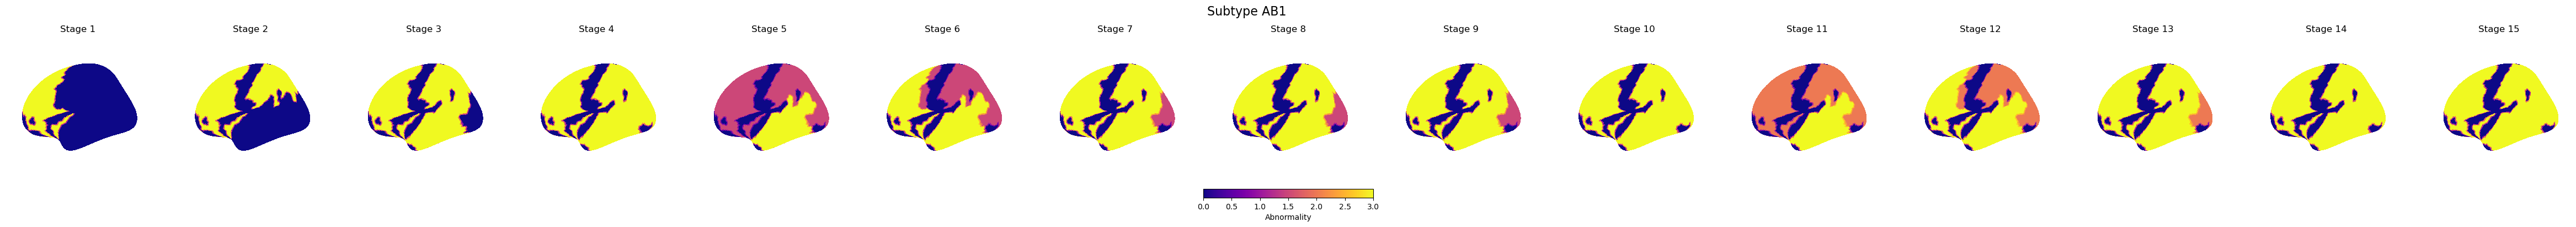

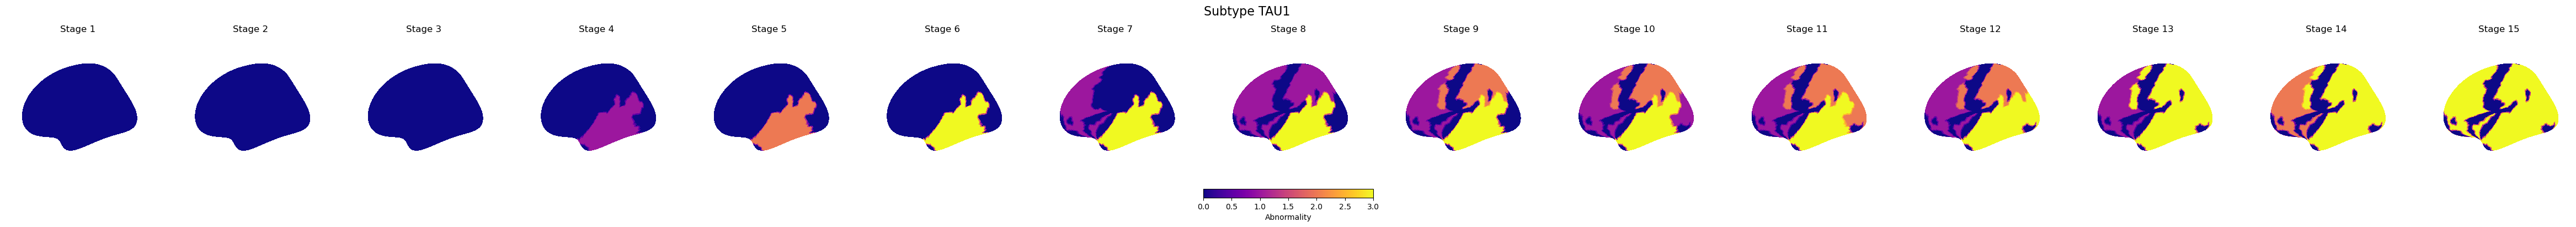

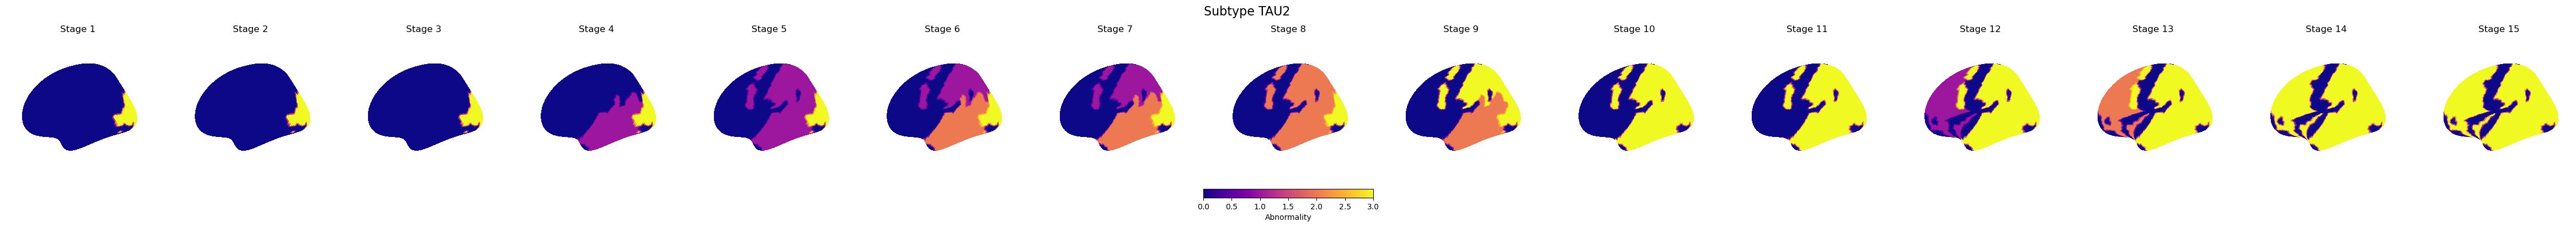

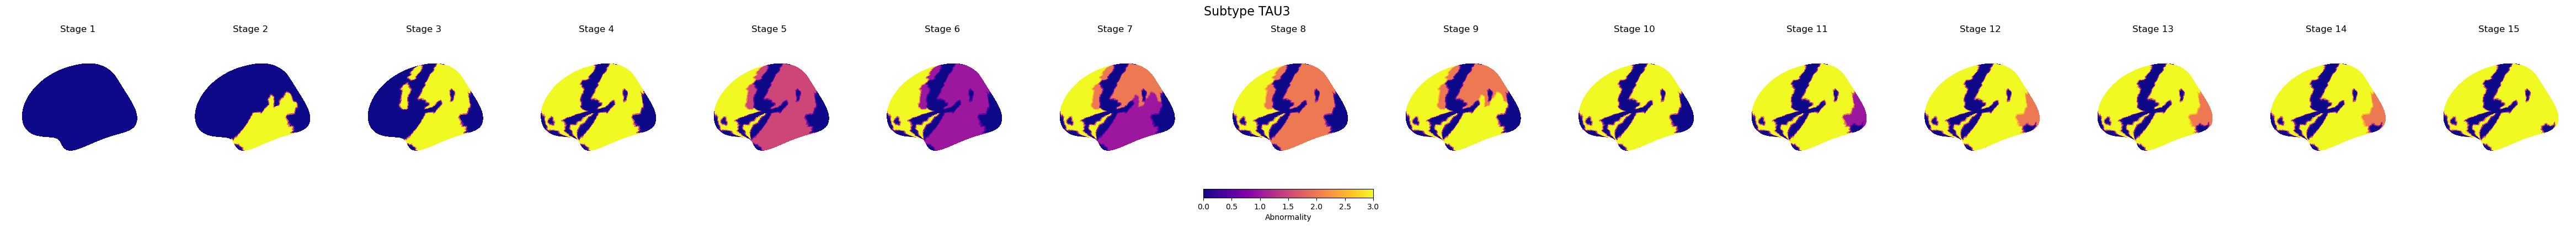

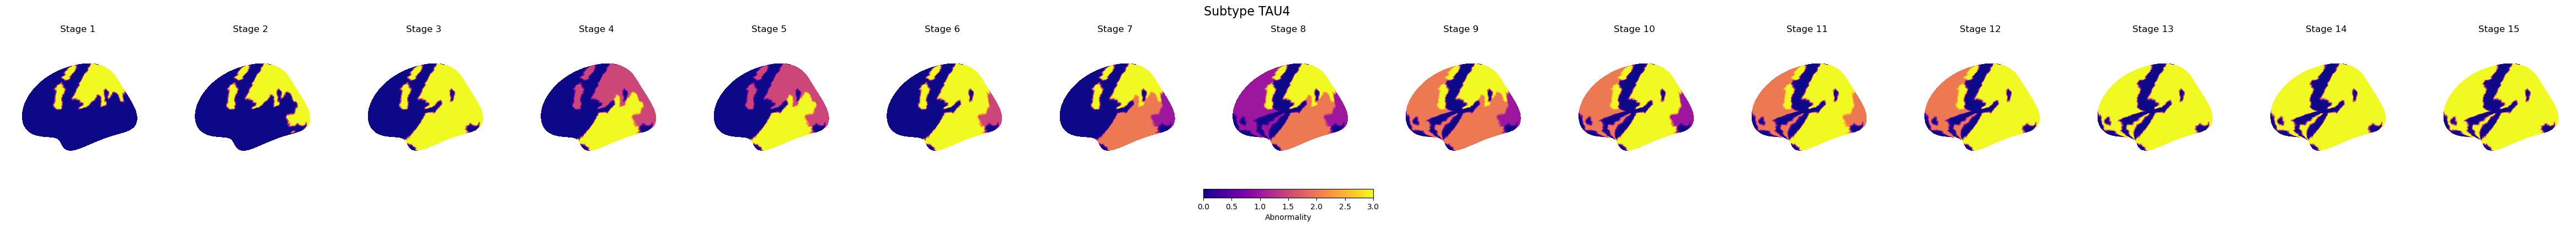

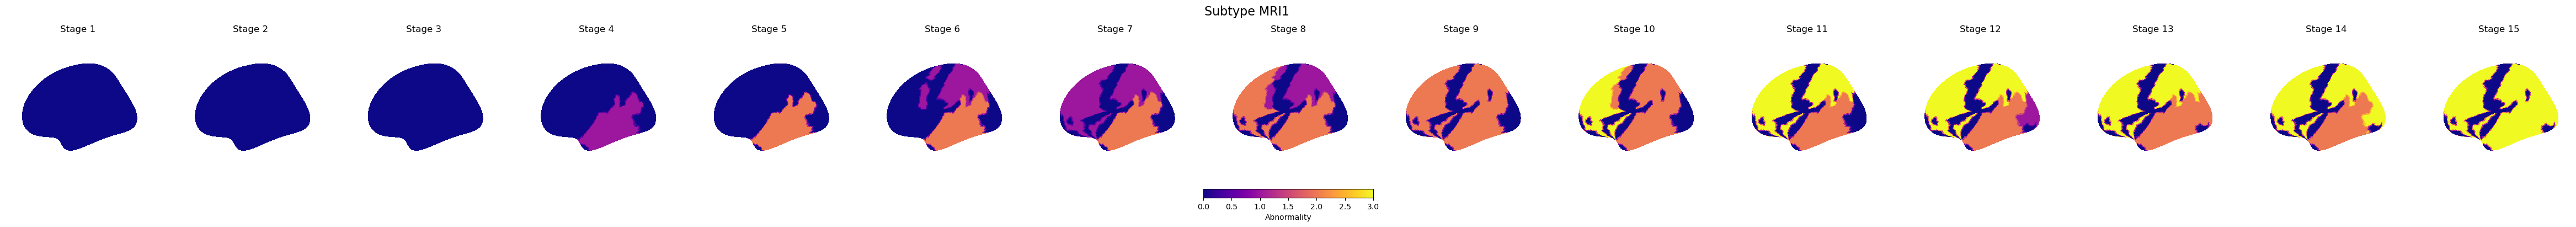

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, plotting

# -----------------------------
# Fetch Destrieux atlas
# -----------------------------
destrieux = datasets.fetch_atlas_surf_destrieux()
labels_data = destrieux['map_left']
label_names = destrieux['labels']
label_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in label_names]

# -----------------------------
# Define lobes
# -----------------------------
lobe_regions = {
    "Frontal": [
        "G_front_inf-Opercular", "G_front_inf-Orbital", "G_front_inf-Triangul",
        "G_front_middle", "G_front_sup", "G_Ins_lg_and_S_cent_ins",
        "G_insular_short", "G_orbital", "S_front_inf", "S_front_middle", "S_front_sup",
        "Lat_Fis-ant-Horizont", "Lat_Fis-ant-Vertical", "G_and_S_cingul-Ant",
        "G_and_S_cingul-Mid-Ant", "G_rectus", "G_subcallosal"
    ],
    "Parietal": [
        "G_pariet_inf-Angular", "G_pariet_inf-Supramar", "G_parietal_sup",
        "G_postcentral", "G_precuneus", "S_intrapariet_and_P_trans", "S_postcentral",
        "S_precentral-inf-part", "S_precentral-sup-part", "S_subparietal"
    ],
    "Temporal": [
        "G_oc-temp_lat-fusifor", "G_oc-temp_med-Lingual", "G_oc-temp_med-Parahip",
        "G_temp_sup-G_T_transv", "G_temp_sup-Lateral", "G_temp_sup-Plan_polar",
        "G_temp_sup-Plan_tempo", "G_temporal_inf", "G_temporal_middle",
        "S_temporal_inf", "S_temporal_sup", "S_temporal_transverse",
        "S_oc-temp_lat", "S_oc-temp_med_and_Lingual"
    ],
    "Occipital": [
        "G_cuneus", "G_occipital_middle", "G_occipital_sup", "Pole_occipital",
        "S_calcarine", "S_oc_middle_and_Lunatus", "S_oc_sup_and_transversal",
        "S_occipital_ant", "S_parieto_occipital"
    ],
    "MTL": [
        "G_hippocampus", "G_amygdala", "S_collat_transv_ant",
        "S_collat_transv_post", "S_suborbital"
    ]
}

# Map lobe → vertex indices
lobe_indices = {}
for lobe, regions in lobe_regions.items():
    indices = []
    for reg in regions:
        for idx, name in enumerate(label_names):
            if reg.lower() in name.lower():
                indices.extend(np.where(labels_data == idx)[0])
    lobe_indices[lobe] = indices

# -----------------------------
# Define subtype sequences
# -----------------------------
sequences = {
    "AB1": ["Frontal","Parietal","Temporal","Occipital","Temporal","Frontal","Parietal",
            "MTL","MTL","Occipital","Temporal","Frontal","Parietal","Occipital","MTL"],
    "TAU1": ["MTL","MTL","MTL","Temporal","Temporal","Temporal","Frontal","Parietal","Parietal",
             "Occipital","Occipital","Occipital","Parietal","Frontal","Frontal"],
    "TAU2": ["Occipital","Occipital","Occipital","Temporal","Parietal","Temporal","MTL",
             "Parietal","Parietal","Temporal","MTL","Frontal","Frontal","Frontal","MTL"],
    "TAU3": ["MTL","Temporal","Parietal","Frontal","Frontal","Frontal","Parietal","Temporal","Temporal",
             "Parietal","Occipital","Occipital","MTL","MTL","Occipital"],
    "TAU4": ["Parietal","Occipital","Temporal","Temporal","MTL","Parietal","Parietal","Frontal",
             "Frontal","Temporal","Occipital","Occipital","Frontal","MTL","MTL"],
    "MRI1": ["MTL","MTL","MTL","Temporal","Temporal","Parietal","Frontal","Frontal","Parietal",
             "Frontal","Parietal","Occipital","Occipital","Occipital","Temporal"]
}

# -----------------------------
# Load fsaverage
# -----------------------------
fsaverage = datasets.fetch_surf_fsaverage()

# -----------------------------
# Plot per subtype
# -----------------------------
for subtype, stages in sequences.items():
    n_stages = len(stages)
    cumulative_data = np.zeros(labels_data.shape)

    fig = plt.figure(figsize=(4*n_stages, 4))
    max_count = 0

    for i, lobe in enumerate(stages):
        cumulative_data[lobe_indices[lobe]] += 1
        max_count = max(max_count, np.max(cumulative_data))

        # Create 3D subplot for each stage
        ax = fig.add_subplot(1, n_stages, i+1, projection='3d')

        plotting.plot_surf_stat_map(
            fsaverage['infl_left'], cumulative_data,
            hemi='left', view='lateral',
            bg_map=fsaverage['sulc_left'],
            cmap='plasma',
            colorbar=False,
            axes=ax,
            title=f"Stage {i+1}"
        )

    # Single colorbar
    sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=max_count))
    cbar = fig.colorbar(sm, ax=fig.get_axes(), orientation='horizontal', fraction=0.05, pad=0.05)
    cbar.set_label('Abnormality')
    plt.suptitle(f"Subtype {subtype}", fontsize=16)
    plt.show()


/var/folders/nl/7qp9kcyn5c965d6fjctkjyd00000gn/T/ipykernel_34643/2442358445.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', n_colors)
/var/folders/nl/7qp9kcyn5c965d6fjctkjyd00000gn/T/ipykernel_34643/2442358445.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.08, 1, 0.92])


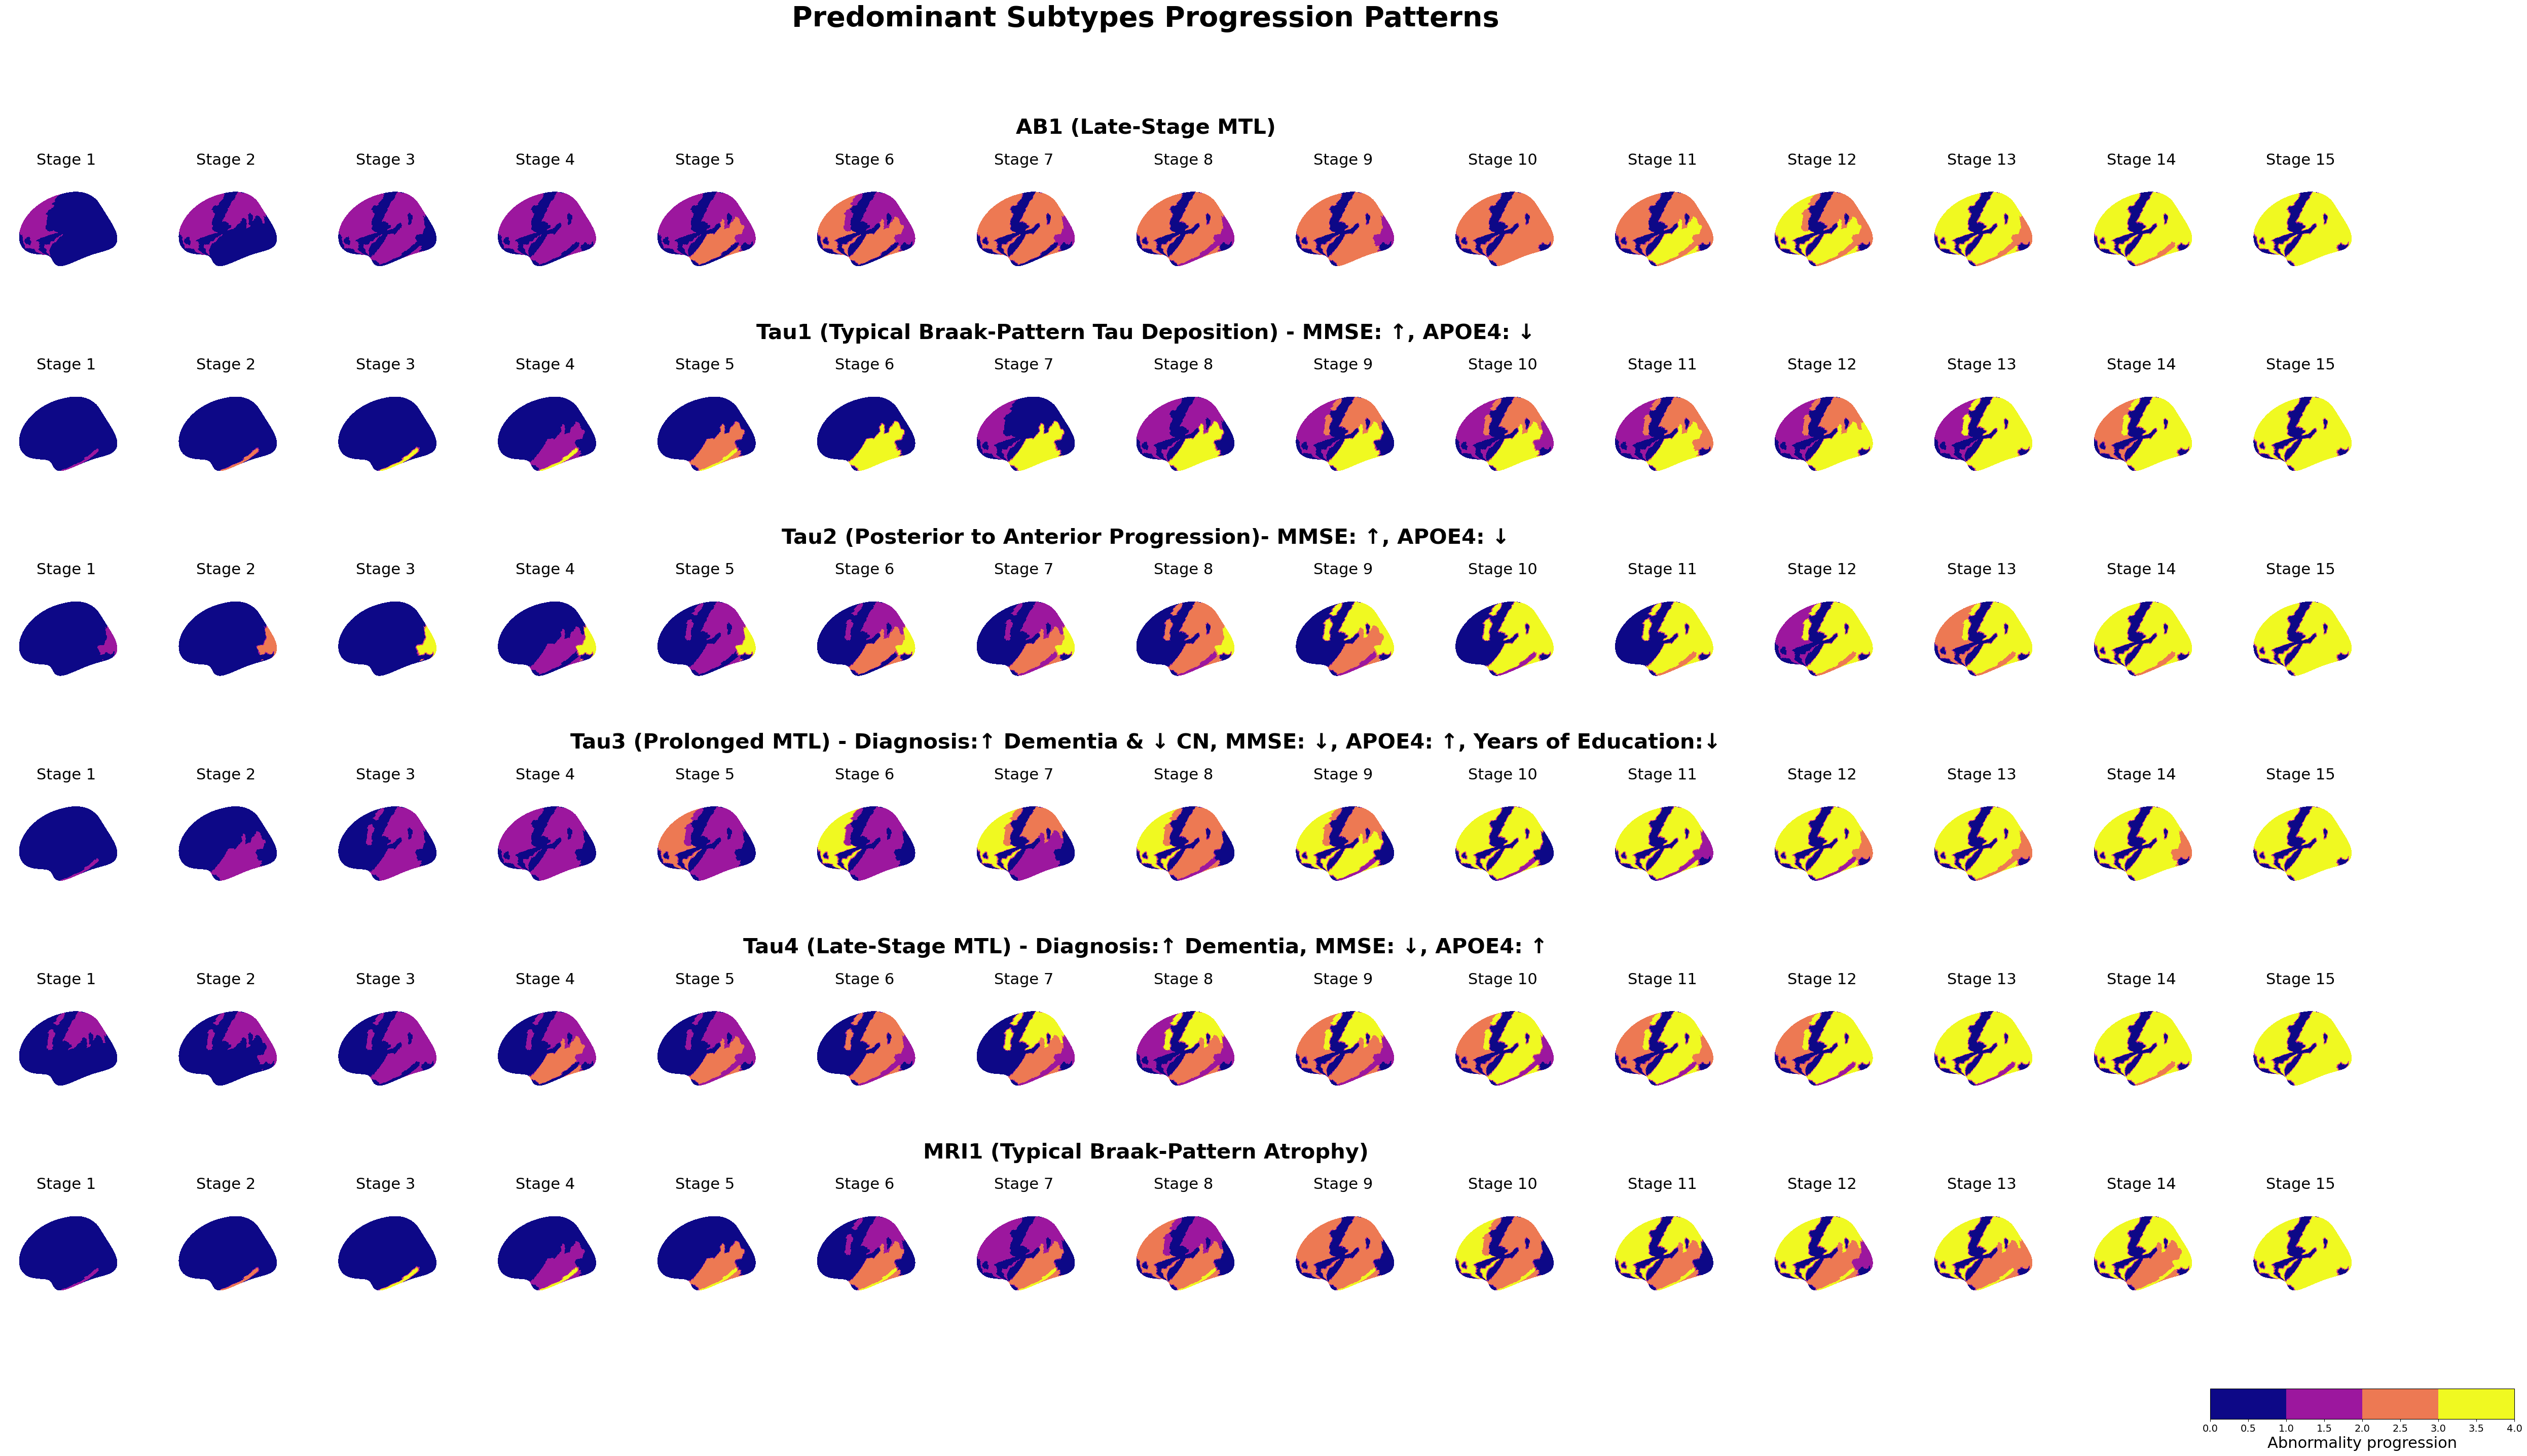

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, plotting
from matplotlib import cm

# sequences and lobe_regions
sequences = {
    "AB1 (Late-Stage MTL)": ["Frontal","Parietal","Temporal","Occipital","Temporal","Frontal","Parietal",
            "MTL","MTL","Occipital","Temporal","Frontal","Parietal","Occipital","MTL"],
    "Tau1 (Typical Braak-Pattern Tau Deposition) - MMSE: ↑, APOE4: ↓": ["MTL","MTL","MTL","Temporal","Temporal","Temporal","Frontal","Parietal","Parietal",
             "Occipital","Occipital","Occipital","Parietal","Frontal","Frontal"],
    "Tau2 (Posterior to Anterior Progression)- MMSE: ↑, APOE4: ↓": ["Occipital","Occipital","Occipital","Temporal","Parietal","Temporal","MTL",
             "Parietal","Parietal","Temporal","MTL","Frontal","Frontal","Frontal","MTL"],
    "Tau3 (Prolonged MTL) - Diagnosis:↑ Dementia & ↓ CN, MMSE: ↓, APOE4: ↑, Years of Education:↓": ["MTL","Temporal","Parietal","Frontal","Frontal","Frontal","Parietal","Temporal","Temporal",
             "Parietal","Occipital","Occipital","MTL","MTL","Occipital"],
    "Tau4 (Late-Stage MTL) - Diagnosis:↑ Dementia, MMSE: ↓, APOE4: ↑": ["Parietal","Occipital","Temporal","Temporal","MTL","Parietal","Parietal","Frontal",
             "Frontal","Temporal","Occipital","Occipital","Frontal","MTL","MTL"],
    "MRI1 (Typical Braak-Pattern Atrophy)": ["MTL","MTL","MTL","Temporal","Temporal","Parietal","Frontal","Frontal","Parietal",
             "Frontal","Parietal","Occipital","Occipital","Occipital","Temporal"]
}

lobe_regions = {
    "Frontal": [
        "G_front_inf-Opercular", "G_front_inf-Orbital", "G_front_inf-Triangul",
        "G_front_middle", "G_front_sup", "G_Ins_lg_and_S_cent_ins",
        "G_insular_short", "G_orbital", "S_front_inf", "S_front_middle", "S_front_sup",
        "Lat_Fis-ant-Horizont", "Lat_Fis-ant-Vertical", "G_and_S_cingul-Ant",
        "G_and_S_cingul-Mid-Ant", "G_rectus", "G_subcallosal"
    ],
    "Parietal": [
        "G_pariet_inf-Angular", "G_pariet_inf-Supramar", "G_parietal_sup",
        "G_postcentral", "G_precuneus", "S_intrapariet_and_P_trans", "S_postcentral",
        "S_precentral-inf-part", "S_precentral-sup-part", "S_subparietal"
    ],
    "Temporal": [
        "G_oc-temp_lat-fusifor", "G_oc-temp_med-Lingual", "G_oc-temp_med-Parahip",
        "G_temp_sup-G_T_transv", "G_temp_sup-Lateral", "G_temp_sup-Plan_polar",
        "G_temp_sup-Plan_tempo",  "G_temporal_middle",
        "S_temporal_inf", "S_temporal_sup", "S_temporal_transverse",
        "S_oc-temp_lat", "S_oc-temp_med_and_Lingual"
    ],
    "Occipital": [
        "G_cuneus", "G_occipital_middle", "G_occipital_sup", "Pole_occipital",
        "S_calcarine", "S_oc_middle_and_Lunatus", "S_oc_sup_and_transversal",
        "S_occipital_ant", "S_parieto_occipital"
    ],
    "MTL": [
        "G_temporal_inf","G_hippocampus", "G_amygdala", "S_collat_transv_ant",
        "S_collat_transv_post", "S_suborbital"
    ]
}



# Fetch Destrieux atlas
destrieux = datasets.fetch_atlas_surf_destrieux()
labels_data = destrieux['map_left']
label_names = [name.decode('utf-8') if isinstance(name, bytes) else name for name in destrieux['labels']]

# Map lobe → vertex indices
lobe_indices = {}
for lobe, regions in lobe_regions.items():
    indices = []
    for reg in regions:
        for idx, name in enumerate(label_names):
            if reg.lower() in name.lower():
                indices.extend(np.where(labels_data == idx)[0])
    lobe_indices[lobe] = indices

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage()

# -----------------------------
# Plot all subtypes in one figure with larger row gaps
# -----------------------------
n_colors = 4
cmap = cm.get_cmap('plasma', n_colors)

subtypes = list(sequences.keys())
n_rows = len(subtypes)
n_cols = max(len(stages) for stages in sequences.values())

# Create gridspec with larger vertical spacing
fig = plt.figure(figsize=(4*n_cols, 5*n_rows))  # increase height per row
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.4, wspace=0.3)  # larger hspace

for row, subtype in enumerate(subtypes):
    stages = sequences[subtype]
    lobe_color_idx = {}
    cumulative_data = np.zeros(labels_data.shape)

    for col, lobe in enumerate(stages):
        if lobe not in lobe_color_idx:
            lobe_color_idx[lobe] = 0
        else:
            lobe_color_idx[lobe] = min(lobe_color_idx[lobe]+1, n_colors-1)

        cumulative_data[lobe_indices[lobe]] = lobe_color_idx[lobe] + 1

        ax = fig.add_subplot(gs[row, col], projection='3d')
        plotting.plot_surf_stat_map(
            fsaverage['infl_left'], cumulative_data,
            hemi='left', view='lateral',
            bg_map=fsaverage['sulc_left'],
            cmap=cmap,
            colorbar=False,
            axes=ax,
            vmin=0,
            vmax=n_colors
        )
        ax.set_title(f"Stage {col+1}", fontsize=22)

    # Place subtype label above the row
    bbox = ax.get_position()
    y_pos = bbox.y1 + 0.02  # bigger margin above the row
    fig.text(
        0.5, y_pos,
        subtype,
        ha='center', va='bottom',
        fontsize=30, fontweight="bold"
    )

# Add a single colorbar for the whole figure
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=n_colors))
cbar_ax = fig.add_axes([0.85, 0.05, 0.1, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Abnormality progression', fontsize=22)
cbar.ax.tick_params(labelsize=14)

plt.suptitle("Predominant Subtypes Progression Patterns", fontsize=40, fontweight="bold")
plt.tight_layout(rect=[0, 0.08, 1, 0.92])
plt.savefig("all_subtypes_progression.png", dpi=300, bbox_inches='tight')
plt.show()
